# Case Study One

In [225]:
# Authors: 
# Elton Pan, Antonio del Rio Chanona

import pylab
import pandas as pd
import scipy.integrate as scp
import numpy as np
import seaborn as sns
from pylab import *
import csv
import os
import sys
import copy
import torch
from sklearn.preprocessing import StandardScaler
import collections
import numpy.random as rnd
from scipy.spatial.distance import cdist
import sobol_seq
from scipy.optimize import minimize
eps  = np.finfo(float).eps
import random
import time
import pickle
import imageio
matplotlib.rcParams['font.sans-serif'] = "Helvetica"
matplotlib.rcParams['font.family'] = "Helvetica"
matplotlib.rcParams['font.size'] = 20
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from IPython.display import Audio # Import sound alert dependencies
from IPython import display # For live plots
from mpl_toolkits import mplot3d
from ipywidgets import interact
def Done():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
# Insert whatever audio file you want above

############ Defining Environment ##############

class Model_env: 
    
    # --- initializing model --- #
    def __init__(self, parameters, tf):
        
        # Object variable definitions
        self.parameters       = parameters
        self.tf = tf  
        
    # --- dynamic model definition --- #    
    # model takes state and action of previous time step and integrates -- definition of ODE system at time, t
    def model(self, t, state):
        # internal definitions
        params = self.parameters
        u_L  = self.u0[0] # Control for light intensity
        u_Fn = self.u0[1] # Control for nitrate input
                
        # state vector # Added Cq as the third state element
        Cx  = state[0]
        Cn  = state[1]
        Cq  = state[2]
        
        # parameters # Updated with new params
        u_m = params['u_m']; k_s = params['k_s'];
        k_i = params['k_i']; K_N = params['K_N'];
        u_d = params['u_d']; Y_nx = params['Y_nx'];
        k_m = params['k_m']; k_sq = params['k_sq'];
        k_iq = params['k_iq']; k_d = params['k_d'];
        K_Np = params['K_Np'];
        
        # algebraic equations
        
        # variable rate equations
        dev_Cx = (u_m * u_L * Cx * Cn/(Cn+K_N))/(u_L+k_s+u_L**2/k_i) - u_d*Cx
        dev_Cn = (- Y_nx*u_m* u_L * Cx * Cn/(Cn+K_N))/(u_L+k_s+u_L**2/k_i) + u_Fn
        dev_Cq = (k_m * u_L * Cx)/(u_L+k_sq+u_L**2/k_iq) - k_d * Cq/(Cn+K_Np)

        return np.array([dev_Cx, dev_Cn, dev_Cq],dtype='float64') # Added Cq

    def simulation(self, x0, controls):
        # internal definitions
        model, tf     = self.model, self.tf
        self.controls = controls
        
        # initialize simulation
        current_state = x0
        
        # simulation #ONLY ONE STEP unlike the previous code shown above
        self.u0   = controls
        ode       = scp.ode(model)                      # define ode
        ode.set_integrator('lsoda', nsteps=3000)        # define integrator
        ode.set_initial_value(current_state, tf)         # set initial value
        current_state = list(ode.integrate(ode.t + tf)) # integrate system
        xt            = current_state                   # add current state Note: here we can add randomnes as: + RandomNormal noise
        
        return xt

    def MDP_simulation(self, x0, controls): #simulate ONLY ONE STEP
        xt          = self.simulation(x0, controls) #simulate
####         xt_discrete = self.discrete_env(xt) # make output state discrete
####         return xt_discrete
        return xt #remove this if you want to discretize

    def reward(self, state):
        reward = 100*state[-1][0] - state[-1][1]              # objective function 1
        return reward

p = {'u_m' : 0.0923*0.62, 'k_s' : 178.85, 'k_i' : 447.12, 'K_N' : 393.10,
'u_d' : 0.001, 'Y_nx' : 504.49, 'k_m' : 2.544*0.62*1e-4,  'k_sq' : 23.51,
'k_iq' : 800.0, 'k_d' : 0.281, 'K_Np' : 16.89}

tf       = 240./12. # assuming 12 steps, we divide the whole horizon (240 h) over 12 for one step


# Creating the model
MDP_BioEnv = Model_env(p, tf)


def transition(old_state, action):
    '''Gives the new state given the current state and action
       Arguments
       old state : [Cx, Cn, Cq, t] 
       action    : [u_L, u_Fn]
    
       Output 
       new state : [Cx, Cn, Cq, t]
       reward    : [Cq_Terminal]
       '''
    # If terminal state is reached (episode in final step)
    if abs(old_state[3] - 240.) < 0.1:
        reward    = copy.deepcopy(old_state[2])           # Reward at terminal state is concentration of q
        new_state = MDP_BioEnv.MDP_simulation(old_state[:-1], action)  # Take action and evolve using model
        new_state.append(old_state[-1] + tf)                           # Increment time by tf (20 h)
    
    # Else if past terminal state (episode has ended)
    elif (old_state[3] > 240.):
        reward    = 0         # Zero reward given
        new_state = old_state # Loop back to itself (no evolution)
    
    # Else non-terminal state (episode has not ended)
    else:
        reward    = 0         # Zero reward given
        new_state = MDP_BioEnv.MDP_simulation(old_state[:-1], action) # Take action and evolve using model
        new_state.append(old_state[-1] + tf)                          # Increment time by tf (20 h)

    return new_state, reward

def generate_random_episode(initial_state): 
    '''Generates an episode [
                             [ [Cx, Cn, Cq, t], [u_L, u_Fn], reward ]
                             ...
                             ...
                             ]
    with random policy with
    an initial state
    '''
    # Initial state
    state  = initial_state # initial state
    episode = []
    
    # Simulate 13 steps (not 12 because we want to exit the terminal step)
    for step in range(13):
        old_state = state                  # Save old state
        u_L  = np.random.uniform(120, 400) # Pick random u_L
        u_Fn = np.random.uniform(0, 40)    # Pick random u_Fn
        action = [u_L, u_Fn]
        
        state, reward = transition(state, action)
        episode       += [[old_state, action, reward]]
    return episode
# generate_random_episode(initial_state = [1.0,150.0,0,0]) # Test generate_random_episode


def extract_data_from_episode(episode, discount_factor = 0.9):
    '''
    Argument: An episode generated using the generate_random_episode() function
    
    Output: 13 Datapoints in the form of [[Cx, Cn, Cq, t, u_L, u_Fn], Q] for training 
            the Q-network
    '''
    Q_data = []
    for step in reversed(range(13)): # Each episode has 13 entries, and Q table is updated in reversed order
        state, action, reward = episode[step] 

        if step == 12: # If terminal state i.e. t = 240
            G = reward # Return = reward at terminal state
        else:
            G = reward + discount_factor * G  # Return = reward + discounted return of the PREVIOUS state
        
        u_L, u_Fn = action     #  Unpack controls
        state.append(u_L)       # Append u_L
        state.append(u_Fn)      # Append u_Fn
        data_point = [state, G] # Construct datapoint where state is index 0, and return is index 1
        Q_data += [data_point]
    return Q_data
# episode = generate_random_episode(initial_state = [1.0,150.0,0,0])
# extract_data_from_episode(episode, discount_factor = 0.9) # Test function

def standardize_state_Q(state): # For Q-network
    '''Argument: Un-standardized [Cx, Cn, Cq, t, u_L, u_Fn]
    Output: Standardized [Cx, Cn, Cq, t, u_L, u_Fn] using previously determined mean and std values''' 
    for feature in range(len(x_mean_Q)): 
        state[feature] = (state[feature] - x_mean_Q[feature])/x_std_Q[feature]
    return state

def unstandardize_state_Q(state): # For Q-network
    '''Argument: Standardized [Cx, Cn, Cq, t, u_L, u_Fn]
    Output: Un-standardized [Cx, Cn, Cq, t, u_L, u_Fn] using previously determined mean and std values''' 
    for feature in range(len(x_mean_Q)): 
        state[feature] = (state[feature] * x_std_Q[feature]) + x_mean_Q[feature]
    return state

def standardize_state_C(state): # For C-network
    '''Argument: Un-standardized [Cx, Cn, Cq, t_f - t, u_L, u_Fn]
    Output: Standardized [Cx, Cn, Cq, t_f - t, u_L, u_Fn] using previously determined mean and std values''' 
    for feature in range(len(x_mean_C)): 
        state[feature] = (state[feature] - x_mean_C[feature])/x_std_C[feature]
    return state

def unstandardize_state_C(state): # For C-network
    '''Argument: Standardized [Cx, Cn, Cq, t_f - t, u_L, u_Fn]
    Output: Un-standardized [Cx, Cn, Cq, t_f - t, u_L, u_Fn] using previously determined mean and std values''' 
    for feature in range(len(x_mean_C)): 
        state[feature] = (state[feature] * x_std_C[feature]) + x_mean_C[feature]
    return state

def take_random_action(epsilon): # Epsilon represents the probability of taking a random action
    if np.random.uniform(0,1) < epsilon:
        return True
    else:
        return False
    

def max_action(state):
    '''Argument: State   [Cx, Cn, Cq, t]
       Output  : Control [u_L, u_Fn] that maximizes Q_value using stochastic optimization'''
    
    # ROUND ONE: Get a ROUGH estimate of max action
    action_distribution = []
    for i in range(200): # Take 100 actions
        u_L  = np.random.uniform(120, 400) # Pick random u_L
        u_Fn = np.random.uniform(0, 40)    # Pick random u_Fn
        action_distribution += [[u_L, u_Fn]]

    inputs = []
    for a in action_distribution:
        s = state.copy()
        s.append(a[0]) # Append u_L
        s.append(a[1]) # Append u_Fn
        s = standardize_state_Q(s) # Standardize the input using function defined
        inputs += [s]
    inputs          = torch.tensor(inputs)
    index_of_highest_Q = np.argmax(Q_net(inputs).detach().numpy()) 

    # Unstandardize controls
    max_u_L  = (inputs[index_of_highest_Q][4] * x_std_Q[4]).item() + x_mean_Q[4]
    max_u_Fn = (inputs[index_of_highest_Q][5] * x_std_Q[5]).item() + x_mean_Q[5]
    max_control = [max_u_L, max_u_Fn]

    # ROUND TWO: Get a PRECISE estimate of max action
    action_distribution = []
    for i in range(200): # Take 100 actions
        u_L  = np.random.uniform(max(max_control[0]-50, 120), min(max_control[0]+50, 400))
        u_Fn = np.random.uniform(max(max_control[1]-5, 0), min(max_control[1]+5, 40))
        action_distribution += [[u_L, u_Fn]]

    inputs = []
    for a in action_distribution:
        s = state.copy()
        s.append(a[0]) # Append u_L
        s.append(a[1]) # Append u_Fn
        s = standardize_state_Q(s) # Standardize the input using function defined
        inputs += [s]

    inputs          = torch.tensor(inputs)
    index_of_highest_Q = np.argmax(Q_net(inputs).detach().numpy()) 

    # Unstandardize controls
    max_u_L  = (inputs[index_of_highest_Q][4] * x_std_Q[4]).item() + x_mean_Q[4]
    max_u_Fn = (inputs[index_of_highest_Q][5] * x_std_Q[5]).item() + x_mean_Q[5]
    max_control = [max_u_L, max_u_Fn] # Predict action with the highest Q value

    return max_control
# max_action([1.0, 150.0, 0, 0]) # Test function

def score_NN_policy(NN, initial_state, num_iterations = 10, get_control = False, g1_threshold = None, g2_threshold = None):
    total_score = 0
    sum_of_policies = []
    if g1_threshold == None: # If no threshold is given (non constrained NN)
        for j in range(num_iterations): 
            state     = initial_state.copy() # Initial state
            x_data    = [state[0]] # Store initial data
            N_data    = [state[1]]
            q_data    = [state[2]]
            t_data    = [state[3]]
            my_policy = []
            for i in range(12): #take ten steps
                action     = NN(state) # Predict action using NN
                state      = transition(state, action)[0]
                my_policy += [action]
                x_data    += [state[0]]
                N_data    += [state[1]]
                q_data    += [state[2]]
                t_data    += [state[3]]
            sum_of_policies += [my_policy] # Create list of lists
            score            = q_data[12]
            total_score     += score
    elif g1_threshold != None: # If threshold given (NN with constrained)
        for j in range(num_iterations): 
            state     = initial_state.copy() # Initial state
            x_data    = [state[0]] # Store initial data
            N_data    = [state[1]]
            q_data    = [state[2]]
            t_data    = [state[3]]
            my_policy = []
            for i in range(12): #take ten steps
#                 print('state after action:', state)
                state_for_NN = state.copy()
                action     = NN(state_for_NN, g1_threshold = g1_threshold, g2_threshold = g2_threshold) # Predict action using NN
#                 print('state before action:', state)
                state      = transition(state, action)[0]
                my_policy += [action]
                x_data    += [state[0]]
                N_data    += [state[1]]
                q_data    += [state[2]]
                t_data    += [state[3]]
            sum_of_policies += [my_policy] # Create list of lists
            score            = q_data[12]
            total_score     += score
    if get_control == True:
        return total_score/num_iterations, np.array(sum_of_policies)
    else:
        return total_score/num_iterations
# score_NN_policy(max_action, [1.0, 150.0, 0, 0], num_iterations = 10)

def generate_episode_with_NN(NN, initial_state, epsilon, g1_threshold = None, g2_threshold = None): 
    '''Generates an episode with the chosen action of each step having:
    Probability of epsilon       ---> random action
    Probability of (1 - epsilon) ---> greedy action (according to neural network)
    '''
    episode = []
    state = initial_state # Initial state
    
    if g1_threshold == None: # IF CONSTRAINTS ARE SWITCHED OFF
        for i in range(13): #take (12 + 1) steps
#             old_state = state # Old state for storing into episode
            old_state = copy.deepcopy(state)
    
            if take_random_action(epsilon): # Take random action
                u_L  = np.random.uniform(120, 400) # Pick random u_L
                u_Fn = np.random.uniform(0, 40)    # Pick random u_Fn
                action = [u_L, u_Fn]

            else:                           # Else take greedy action
                action = list(NN(old_state))

            state, reward  = transition(state, action)     # Evolve to get new state 
            episode       += [[old_state, action, reward]] # Update step
    
    elif g1_threshold != None: # IF CONSTRAINTS ARE SWITCHED ON
        for i in range(13): #take (12 + 1) steps
#             print('state at the start of each step:', state)
#             old_state_copy = copy.deepcopy(state)  # THIS IS IMPORTANT BCOS THE NN BELOW SOMEHOW DISTORTS OLD_STATE
            if take_random_action(epsilon): # Take random action
                u_L  = np.random.uniform(120, 400) # Pick random u_L
                u_Fn = np.random.uniform(0, 40)    # Pick random u_Fn
                action = [u_L, u_Fn]
            else:                           # Else take greedy action
                if i == 12: # If transition out of the terminal state, pick any action
                    action = action
#                     print('13th transition')
                else:
                    state_for_NN = copy.copy(state)
                    
#                     print('state_for_nn:', state_for_NN)
#                     print('state before acion:', state)
                    
                    action = list(NN(state_for_NN, g1_threshold = g1_threshold, g2_threshold = g2_threshold)) # APPLY THRESHOLD
#                     print('state after acion:', state)
#                     print(i)
                #                     print('old_state:', old_state)
#                 print('done')

            old_state = state.copy() # Old state for storing into episode
#             print('old_state_1:', old_state)
#             print('state before evolution:', state)
            state, reward  = transition(state, action)     # Evolve to get new state
#             print('state after evolution:', state)
#             print('')
            episode       += [[old_state, action, reward]] # Update step
    return episode
# generate_episode_with_NN(max_action, [1.0, 150.0, 0, 0], epsilon = 0.1)

def update_replay_buffer(replay_buffer, episode, discount_factor = 0.9):
    '''Argument: replay buffer (a collections.deque object) and ONE episode
    Output: Adds standardized datapoints [[Cx, Cn, Cq, t, u_L, u_Fn], Q] for training NN into replay buffer
    '''
    data = extract_data_from_episode(episode, discount_factor = discount_factor) # Extract data points from episode
    for data_point in data:
        X, y = data_point # Unpack datapoint
        X = standardize_state_Q(X) # Standardize X
        y = ((y - y_mean_Q)/y_std_Q)[0] # Standardize y
        data_point = [X, y] # Repack datapoint
        replay_buffer.extend([data_point]) # Add to replay buffer
    
    return replay_buffer
# replay_buffer = collections.deque(maxlen = 3000) # Max capacity of 3000
# episode = generate_episode_with_NN(max_action, [1.0, 150.0, 0, 0], epsilon = 0.1)
# update_replay_buffer(replay_buffer, episode)

def plot_episode(episode):
    '''Plots an episode and corresponding score'''
    x_list = []
    N_list =[]
    q_list =[]
    t_list =[]
    u_L_list= []
    u_Fn_list = []
    reward_list = []
    t = 0
    for step in episode:
        [Cx, Cn, Cq, t], [u_L, u_Fn], reward = step
        x_list += [Cx]
        N_list += [Cn]
        q_list += [Cq]
        t_list += [t]
        u_L_list+= [u_L]
        u_Fn_list += [u_Fn]
        reward_list += [reward]
        t += tf

    plt.figure(figsize=(10,10))

    plt.subplot(3,2,1)
    plt.plot(t_list, x_list, label = 'x trajectory', color = 'b')
    plt.legend(fontsize = 15)

    plt.subplot(3,2,2)
    plt.plot(t_list, N_list, label = 'N trajectory', color = 'b')
    plt.legend(fontsize = 15)

    plt.subplot(3,2,3)
    plt.plot(t_list, q_list, label = 'q trajectory', color = 'b')
    plt.legend(fontsize = 15)

    plt.subplot(3,2,5)
    plt.step(t_list, u_L_list, label = 'u_L trajectory', color = 'r')
    plt.ylim(100,420)
    plt.legend(fontsize = 15)

    plt.subplot(3,2,6)
    plt.step(t_list, u_Fn_list, label = 'u_Fn trajectory', color = 'r')
    plt.ylim(0,43)
    plt.legend(fontsize = 15)

    plt.show()
    print('Score:', q_list[-1])
    # print('x_list:', x_list)
    # print('n_list:', N_list)
    # print('q_list:', q_list)
    # print('reward_list:', reward_list)
    # print('t_list:', t_list)
# episode = generate_episode_with_NN(NN = max_action, initial_state = [1.0, 150.0, 0, 0], epsilon = 0)
# plot_episode(episode)

def plot_episode_pool(episode_pool):
    '''Plots an episode pool (n number of episodes) and corresponding score'''
    
    plt.figure(figsize=(10,10))
    x_pool = []
    N_pool = []
    q_pool = []
    t_pool = []
    u_L_pool = []
    u_Fn_pool = []
    
    for idx in range(len(episode_pool)): # Idx refers to nth episode in episode pool
        episode = episode_pool[idx]
        x_list = []
        N_list = []
        q_list = []
        t_list = []
        u_L_list = []
        u_Fn_list = []
        reward_list = []
        t = 0
        
        for step in episode:
            [Cx, Cn, Cq, t], [u_L, u_Fn], reward = step
            x_list += [Cx]
            N_list += [Cn]
            q_list += [Cq]
            t_list += [t]
            u_L_list += [u_L]
            u_Fn_list += [u_Fn]
            reward_list += [reward]
            t += tf
        
        x_pool += [x_list]
        N_pool += [N_list]
        q_pool += [q_list]
        u_L_pool += [u_L_list]
        u_Fn_pool += [u_Fn_list]
        
        plt.subplot(3,2,1)
        if idx == 0:
            plt.plot(t_list, x_list, label = 'x trajectory', color = 'grey')
            
            plt.legend(fontsize = 15)
        else:
            plt.plot(t_list, x_list, label = 'x trajectory', color = 'grey')

        plt.subplot(3,2,2)
        if idx == 0:
            plt.plot(t_list, N_list, label = 'N trajectory', color = 'grey')
            plt.legend(fontsize = 15)
        else:
            plt.plot(t_list, N_list, label = 'N trajectory', color = 'grey')

        plt.subplot(3,2,3)
        if idx == 0:
            plt.plot(t_list, q_list, label = 'q trajectory', color = 'grey')
            plt.legend(fontsize = 15)
        else:
            plt.plot(t_list, q_list, label = 'q trajectory', color = 'grey')

        plt.subplot(3,2,5)
        if idx == 0:
            plt.step(t_list, u_L_list, label = 'u_L trajectory', color = 'grey')
            plt.ylim(100,420)
            plt.legend(fontsize = 15)
        else:
            plt.step(t_list, u_L_list, label = 'u_L trajectory', color = 'grey')
            plt.ylim(100,420)

        plt.subplot(3,2,6)
        if idx == 0:
            plt.step(t_list, u_Fn_list, label = 'u_Fn trajectory', color = 'grey')
            plt.ylim(0,43)
            plt.legend(fontsize = 15)
        else:
            plt.step(t_list, u_Fn_list, label = 'u_Fn trajectory', color = 'grey')
            plt.ylim(0,43)
        
    x_pool = np.array(x_pool)
    N_pool = np.array(N_pool)
    q_pool = np.array(q_pool)
    u_L_pool = np.array(u_L_pool)
    u_Fn_pool = np.array(u_Fn_pool)
        
    # Take mean of all columns (all time steps)
    x_avg_list = x_pool.mean(axis=0)
    N_avg_list = N_pool.mean(axis=0)
    q_avg_list = q_pool.mean(axis=0)
    u_L_avg_list  = u_L_pool.mean(axis=0)
    u_Fn_avg_list = u_Fn_pool.mean(axis=0)
        
    plt.subplot(3,2,1)
    plt.plot(t_list, x_avg_list, label = 'x trajectory', color = 'r')

    plt.subplot(3,2,2)
    plt.plot(t_list, N_avg_list, label = 'N trajectory', color = 'r')

    plt.subplot(3,2,3)
    plt.plot(t_list, q_avg_list, label = 'q trajectory', color = 'r')

    plt.subplot(3,2,5)
    plt.step(t_list, u_L_avg_list, label = 'u_L trajectory', color = 'r')
    plt.ylim(100,420)

    plt.subplot(3,2,6)
    plt.step(t_list, u_Fn_avg_list, label = 'u_Fn trajectory', color = 'r')
    plt.ylim(0,43)
            
    plt.show()
    print('Score:', q_list[-1])
# episode_pool = []
# for i in range(10):
#     episode = generate_episode_with_NN(GA_optimize_constrained, [1.0, 150.0, 0, 0], epsilon = 0, 
#                                    g1_threshold = 0 
#                                    g2_threshold = 0) 
#     episode_pool += [episode]
# plot_episode_pool(episode_pool)

def extract_constraint_values_from_episode(episode, N_limit = 800, terminal_N_limit = 150):
    '''Arguments : 1 episode and N_limit
       Output    : Index 0 gives input data in terms of [Cx, Cn, Cq, t-t_f, u_L, u_Fn]
                   Index 1 gives target constraint values'''

    state_action = [] # Initialize inputs
    g1_target   = [] # Initialize target value (constraints)
    g2_target   = [] # Initialize target value (constraints)
    g3_target   = [] # Initialize target value (constraints)
    targets = [] # Initialize target values [[g1, g2 g3], ...]
    
    num_transitions = 12
    for i in range(num_transitions): # Index 0 to 11 instead of 12 because we consider the 1st 12 transitions
        step             = episode[i]       # Choose a specific step
        new_step         = episode[i+1]     # and the corresponding subsequent step
        
        state, action, _ = step             # Unpack state & action
        state            = list(state)
        state[3]         = 240. - state[3]   # IMPORTANT: Modify t to (t_f - t)
        state           += action           # Append u_L and u_Fn
        
        # INPUT for training
        state_action += [state]
        
        new_state, _, _  = new_step         # Unpack subsequent state
        Cx               = new_state[0]     # Biomass of SUBSEQUENT step (for g2)
        Cn               = new_state[1]     # Nitrate of SUBSEQUENT step (for g1)
        Cq               = new_state[2]     # Bioproduct of SUBSEQUENT step (for g2)
        
        if i == (num_transitions-1): # If final transition
            Cn_T         = new_state[1]     # Nitrate of TERMINAL state (for g3)

        # TARGETS for path constraint 1 (g1) where Cn - 800 =< 0
        g1           = Cn - N_limit # Calculate constraint value (+ve for exceeding limit)
        g1_target   += [[g1]]      # TARGET OUTPUT (IMPORTANT TO USE A NESTED LIST hence the DOUBLE square brackets)

        # TARGETS for path constraint 2 (g2) where Cq - 0.011*Cx =< 0
        g2           = Cq - 0.011 * Cx # Calculate constraint value (+ve for exceeding limit)
        g2_target   += [[g2]]      # TARGET OUTPUT (IMPORTANT TO USE A NESTED LIST hence the DOUBLE square brackets)
        
    # TARGETS for terminal constraint 2 (g3) where Cq - 0.011*Cx =< 0
    g3           = Cn_T - terminal_N_limit # Calculate constraint value (+ve for exceeding limit)
    g3_target   += [[g3]*num_transitions] # End constraint violation same for all steps in same episode
    
    # Update constraints using "Crystal Ball/Oracle": Highest/Worst constraint value from current and future steps
    for j in range(num_transitions - 1): # Index of constraint value to be checked (11 instead of 12 bcos the 12th value is terminal and has no future)
        for k in range(num_transitions-j): # Number of steps into the future
            if g1_target[j] < g1_target[j+k]: # If future g1 value is LARGER than current value
                g1_target[j] = g1_target[j+k]  # Replace current value with future value
        
#         # ===== DISCOUNTED ORACLE FOR g2====
#         alpha = (j+1)/12 # Degree of contribution by terminal g2 (low for early states, high for late states)
#         g2_target[j][0] = alpha*g2_target[-1][0] + (1 - alpha)*g2_target[j][0]
        
#             if g2_target[j] < g2_target[j+k]: # If future g2 value is LARGER than current value
#                 g2_target[j] = g2_target[j+k]  # Replace current value with future value
            
    
#     for m in range(num_transitions): # Pack into a nested list
#         g1 = g1_target[m]
#         g2 = g2_target[m]
#         g3 = g3_target[m]
#         targets += [[g1]] # g1 only - NEEDS TO BE NESTED LIST
#         targets += [[g1, g2]] # g1 and g2 only - NEEDS TO BE NESTED LIST
#         targets += [[g1, g2, g3]] # g1, g2 and g3 - NEEDS TO BE NESTED LIST
        
#     print('g1:', g1_target)
#     print('')
#     print('g2:', g2_target)
#     print('')
#     print('g3:', g3_target)  
    return state_action, g1_target, g2_target
# episode = generate_random_episode(initial_state = [1.0,150.0,0,0]) 
# extract_constraint_values_from_episode(episode)

def update_g1_buffer(g1_buffer, episode):
    '''Argument: g1 buffer (a collections.deque object) and ONE episode
    Output: Adds standardized datapoints [[Cx, Cn, Cq, t_f-f, u_L, u_Fn], g1] for training g1_net into replay buffer
    '''
    state_action, g1_constraint, g2_constraint = extract_constraint_values_from_episode(episode) # Extract data points from episode
#     print('state_action:', state_action)

#     print('constraint:', constraint)
    for idx in range(len(state_action)):
        state_action[idx] = standardize_state_C(state_action[idx])
        g1_constraint[idx] = (np.array(g1_constraint[idx]) - y_mean_C[0])/y_std_C[0]
        data_point = [list(state_action[idx]), g1_constraint[idx].item()] # Repack datapoint
        g1_buffer.extend([data_point]) # Add to replay buffer
    
    return g1_buffer
# episode   = generate_random_episode(initial_state = [1.0,150.0,0,0]) 
# g1_buffer = collections.deque(maxlen = 3000) # Max capacity of 3000
# g1_buffer = update_g1_buffer(g1_buffer, episode)

def update_g2_buffer(g2_buffer, episode):
    '''Argument: g2 buffer (a collections.deque object) and ONE episode
    Output: Adds standardized datapoints [[Cx, Cn, Cq, t_f-f, u_L, u_Fn], g1] for training g1_net into replay buffer
    '''
    state_action, g1_constraint, g2_constraint = extract_constraint_values_from_episode(episode) # Extract data points from episode
#     print('state_action:', state_action)

#     print('constraint:', constraint)
    for idx in range(len(state_action)):
        state_action[idx] = standardize_state_C(state_action[idx])
        g2_constraint[idx] = (np.array(g2_constraint[idx]) - y_mean_C[1])/y_std_C[1]
        data_point = [list(state_action[idx]), g2_constraint[idx].item()] # Repack datapoint
        g2_buffer.extend([data_point]) # Add to replay buffer
    
    return g2_buffer

In [978]:
episode = generate_random_episode(initial_state = [1.0,150.0,0,0])

In [728]:
# TEST DISCOUNTED ORACLE FOR G2
extract_constraint_values_from_episode(episode)

([[1.0, 150.0, 0, 240.0, 184.12766135981542, 27.848280385659958],
  [1.2302775900425211,
   579.7160773580995,
   0.002534770636314746,
   220.0,
   242.57003121957925,
   1.0558028448184054],
  [1.5933658037154794,
   403.43864817011297,
   0.0056639483607934474,
   200.0,
   322.9398927536897,
   18.86805832809935],
  [2.0552705806160656,
   529.5159747837388,
   0.009444978461410156,
   180.0,
   308.3539010960419,
   19.32129627327818],
  [2.706477480189214,
   563.5573467968829,
   0.01443199743968542,
   160.0,
   276.6659481541226,
   36.2194553002806],
  [3.6566282940755053,
   776.8408691319937,
   0.021232243254751627,
   140.0,
   299.34253204114134,
   3.0004604586705597],
  [4.727562236358853,
   254.0248093995772,
   0.03007752615259195,
   120.0,
   184.62986353345968,
   13.13171855727106],
  [5.389406885838948,
   131.5057019817623,
   0.040831740439243175,
   100.0,
   121.23872066135547,
   36.124759921841616],
  [6.251376104779194,
   360.9455955479613,
   0.0534078

## Generate random MC episodes for standardizing training set

In [2]:
# Generate data
Q_network_training_data = []
for i in range(10000):
    episode = generate_random_episode(initial_state = [1.0,150.0,0,0]) # Generate 1 episode
    data = extract_data_from_episode(episode, discount_factor = 0.9)   # Extract datapoint from episode
    
    Q_network_training_data += data # Add datapoints to training set
Q_network_training_data

[[[7.118042677358626,
   240.97858611182315,
   0.08830350793293201,
   240.0,
   173.0816825322297,
   2.870089393957471],
  0.08830350793293201],
 [[6.359665259023343,
   62.398201650586884,
   0.0750998505717206,
   220.0,
   129.06695513884137,
   31.429492251315732],
  0.07947315713963882],
 [[6.113185169491834,
   40.40447056951683,
   0.06597893163660547,
   200.0,
   173.32552576981007,
   10.458180451318487],
  0.07152584142567493],
 [[5.998779053407252,
   21.77075854486877,
   0.05857871654244903,
   180.0,
   170.55814277296273,
   6.868451100686341],
  0.06437325728310744],
 [[5.863510837435932,
   77.45099188991071,
   0.051453801669993145,
   160.0,
   250.5420970408422,
   3.6329160740434796],
  0.0579359315547967],
 [[5.478170255274859,
   90.98156423790233,
   0.041704742293494274,
   140.0,
   292.11398288930343,
   11.905991485362817],
  0.05214233839931703],
 [[4.97268528532515,
   173.74744187540435,
   0.03237304571199907,
   120.0,
   364.157909090458,
   11.259

In [3]:
# Random policy score
total_score = 0
for i in range(100):
    total_score += generate_random_episode(initial_state = [1.0,150.0,0,0])[-1][-1]
total_score/100

0.10547294626999883

In [8]:
# Extract data
state_and_action = [] # A list of lists for input
Q_value          = [] # A list of lists for target values 

for datapoint in Q_network_training_data: # Iterate over states
    s_a, Q            = datapoint # Unpack [Cx, Cn, Cq, t, u_L, u_Fn], Q
    state_and_action += [s_a]
    Q_value          += [[Q]]

state_and_action = np.array(state_and_action) # Convert list to tensor
Q_value          = np.array(Q_value)          # Convert list to tensor

state_and_action[:3], Q_value[:3] # View first three examples

(array([[7.11804268e+00, 2.40978586e+02, 8.83035079e-02, 2.40000000e+02,
         1.73081683e+02, 2.87008939e+00],
        [6.35966526e+00, 6.23982017e+01, 7.50998506e-02, 2.20000000e+02,
         1.29066955e+02, 3.14294923e+01],
        [6.11318517e+00, 4.04044706e+01, 6.59789316e-02, 2.00000000e+02,
         1.73325526e+02, 1.04581805e+01]]),
 array([[0.08830351],
        [0.07947316],
        [0.07152584]]))

In [9]:
# Standardize data
X = state_and_action
y = Q_value

scaler_X = StandardScaler().fit(X)
scaler_y = StandardScaler().fit(y)

# Get mean and std
x_mean_Q = scaler_X.mean_
x_std_Q  = scaler_X.scale_
y_mean_Q = scaler_y.mean_
y_std_Q  = scaler_y.scale_

# Scale x
X_scaled = np.zeros(X.shape)
for feature in range(len(x_mean_Q)): 
    X_scaled[:,feature] = (X[:,feature] - x_mean_Q[feature])/x_std_Q[feature]

# Scale y
y_scaled = (y - y_mean_Q)/y_std_Q

# Convert into tensors
X_scaled = torch.tensor(X_scaled)
y_scaled = torch.tensor(y_scaled)
X_scaled, y_scaled

(tensor([[ 0.7150, -0.4047,  1.3334,  1.6036, -1.0750, -1.4844],
         [ 0.4697, -0.9527,  0.9657,  1.3363, -1.6196,  0.9894],
         [ 0.3899, -1.0202,  0.7117,  1.0690, -1.0720, -0.8271],
         ...,
         [-1.0828,  1.1386, -0.9670, -1.0690,  0.6691, -1.0479],
         [-1.1992,  0.3167, -1.0551, -1.3363, -1.2189,  0.2729],
         [-1.2641, -0.6839, -1.1254, -1.6036, -1.2401,  0.1652]],
        dtype=torch.float64),
 tensor([[ 1.0711],
         [ 0.7263],
         [ 0.4159],
         ...,
         [-0.9488],
         [-1.0917],
         [-1.2202]], dtype=torch.float64))

## Pre-training the Q-network with MC samples

In [12]:
Q_net = torch.nn.Sequential(
        torch.nn.Linear(6,   200, bias = True), # 6 input nodes
        torch.nn.LeakyReLU(),    # apply ReLU activation function
        torch.nn.Linear(200, 200, bias = True), 
        torch.nn.LeakyReLU(),    # apply ReLU activation function
        torch.nn.Linear(200,   1, bias = True), # 1 output node
    ).double()

In [ ]:
# Define dataset
torch_dataset = torch.utils.data.TensorDataset(X_scaled, y_scaled)

# def weights_init_uniform(m): # For initializing uniform weights
#     classname = m.__class__.__name__
#     # for every Linear layer in a model..
#     if classname.find('Linear') != -1:
#         # apply a uniform distribution to the weights and a bias=0
#         m.weight.data.uniform_(0.0, 1.0)
#         m.bias.data.fill_(0)

#Define a network
Q_net = torch.nn.Sequential(
        torch.nn.Linear(6,   200, bias = True), # 6 input nodes
        torch.nn.LeakyReLU(),    # apply ReLU activation function
        torch.nn.Linear(200, 200, bias = True), 
        torch.nn.LeakyReLU(),    # apply ReLU activation function
        torch.nn.Linear(200,   1, bias = True), # 1 output node
    ).double()

# Q_net.apply(weights_init_uniform) # Initialize uniform weights

optimizer = torch.optim.Adam(Q_net.parameters(), lr = 1e-3) # Initialize Adam optimizer
loss_func = torch.nn.SmoothL1Loss()  # this is for regression mean squared loss

BATCH_SIZE = 1000 # Batch size
EPOCH      = 50   # No. of epochs

# Splitting dataset into batches
loader = torch.utils.data.DataLoader(dataset     = torch_dataset, 
                         batch_size  = BATCH_SIZE, 
                         shuffle     = True, 
                         num_workers = 0)

# my_images = []  # For saving into gif
fig, ax = plt.subplots(figsize=(10,7))

epoch_list = [] # Save epoch for plotting
loss_list  = [] # Save loss for plotting

# Start training
for epoch in range(EPOCH):
    epoch_list += [epoch]
    for step, (batch_x, batch_y) in enumerate(loader): # for each training step

        prediction = Q_net(batch_x.double())          # input x and predict based on x

        loss       = loss_func(prediction, batch_y) # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients

        if step == 1:
            # plot and show learning process
            plt.cla()
            loss_list += [loss.data.numpy()]
            plt.plot(epoch_list, loss_list, label = 'Latest Loss = %.4f' % loss.data.numpy(), color = 'r')
            plt.xlabel('Epoch', fontsize = 20)
            plt.ylabel('Loss', fontsize = 20)
            plt.xticks(fontsize = 20)
            plt.yticks(fontsize = 20)
            plt.legend(fontsize = 20, frameon= 0)
            
            display.clear_output(wait = True) #these two lines plots the data in real time
            display.display(fig)
            print('Current Epoch =', epoch)
            print('Latest Loss =', loss.data.numpy())

In [7]:
predictions = (Q_net(X_scaled).detach().numpy() * y_std_Q) + y_mean_Q
predictions[:10], y[:10]

(array([[0.05920017],
        [0.0616099 ],
        [0.06053861],
        [0.06136958],
        [0.06040576],
        [0.0605373 ],
        [0.06111837],
        [0.06044293],
        [0.05836715],
        [0.05714367]]),
 array([[0.12340387],
        [0.11106349],
        [0.09995714],
        [0.08996142],
        [0.08096528],
        [0.07286875],
        [0.06558188],
        [0.05902369],
        [0.05312132],
        [0.04780919]]))

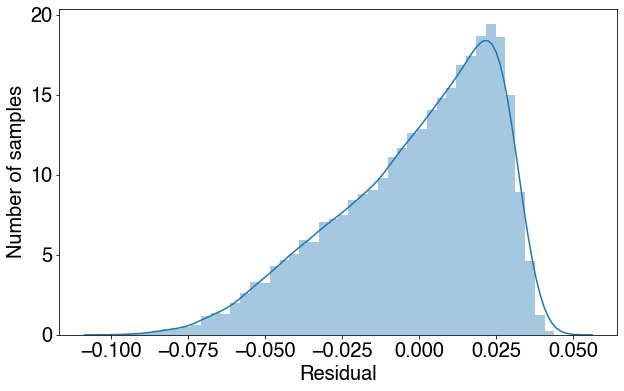

In [8]:
# Plot histogram of errors
residual = predictions - y
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(residual)
ax.set(xlabel= 'Residual', ylabel = 'Number of samples')
plt.show()

In [2751]:
score_NN_policy(GA_optimize, [1.0, 150.0, 0, 0], num_iterations = 20)

0.21132967139852585

## Training the UNCONSTRAINED Q-network

In [1427]:
# Initialize Q-network
Q_net = torch.nn.Sequential(
        torch.nn.Linear(6,   200, bias = True), # 6 input nodes
        torch.nn.LeakyReLU(),    # apply ReLU activation function
        torch.nn.Linear(200, 200, bias = True), 
        torch.nn.LeakyReLU(),    # apply ReLU activation function
        torch.nn.Linear(200,   1, bias = True), # 1 output node
    ).double()

In [1429]:
# ========== 1) GENERATING INITIAL BATCH OF SAMPLES FOR REPLAY BUFFER ==========
epsilon       = 0.99
replay_buffer = collections.deque(maxlen = 3000) # Max capacity of 3000

for i in range(100): # Generate 100 episodes
    episode       = generate_episode_with_NN(NN = GA_optimize,
                                             initial_state = [1.0, 150.0, 0, 0],
                                             epsilon = epsilon)
    replay_buffer = update_replay_buffer(replay_buffer, episode, discount_factor = 0.9) # Add to replay buffer
print(len(replay_buffer))

# ================================= 2) TRAINING THE Q-NETWORK =================================
epsilon            = 0.99 # Initial epsilon
score_list         = [] # For plotting score of policy visited over time
iteration_list     = []
policy_mean_list   = [] # For plotting evolution of policy visited over time
policy_std_list    = [] # For plotting evolution of policy visited over time
training_loss_list = [] # For plotting loss of NN (after 20 epochs) over time
episode_bank       = [] # A list of list of lists - Tertiary list  -> Iterations
                        #                         - Secondary list -> Episodes
                        #                         - Primary list   -> Steps
                        #                         For plotting evolution of states visited over time            

for iteration in range(1000):
    # SCORE EXISTING POLICY
    print('=========== TRAINING ITERATION %.0f ===========' % iteration)
    print('Current epsilon = ', epsilon)
    current_score = score_NN_policy(GA_optimize, [1.0, 150.0, 0, 0], num_iterations = 10)
    print('AVERAGE SCORE = '  , current_score)
    print('')
    
    # GENERATE EPISODES & ADD TO REPLAY BUFFER
    for j in range(100):
        episode       = generate_episode_with_NN(NN = GA_optimize,
                                             initial_state = [1.0, 150.0, 0, 0],
                                             epsilon = epsilon)
        replay_buffer = update_replay_buffer(replay_buffer, episode, discount_factor = 0.9) # Add to replay buffer
    
    # SAMPLE EPISODES FROM REPLAY BUFFER
    combined_inputs  = [] # List of lists to be converted into input tensor
    combined_targets = [] # List to be converted into target tensor
    samples          = random.sample(replay_buffer, 100) # Draw random samples from replay buffer
    
    for inputs, target in samples:
        combined_inputs  += [inputs]
        combined_targets += [[target]]
    combined_inputs  = torch.tensor(combined_inputs)  # Convert list to tensor
    combined_targets = torch.tensor(combined_targets) # Convert list to tensor
    
    # TRAIN THE NEURAL NETWORK
    optimizer = torch.optim.Adam(Q_net.parameters(), lr=1e-3) # Initialize Adam optimizer
    loss_func = torch.nn.SmoothL1Loss()                     # Define loss function
    

    for epoch in range(20):
        prediction = Q_net(combined_inputs)                    # Input x and predict based on x
        loss       = loss_func(prediction, combined_targets) # Must be (1. nn output, 2. target)

        optimizer.zero_grad()   # Clear gradients for next train
        loss.backward()         # Backpropagation, compute gradients
        optimizer.step()        # Apply gradients
#         print('Epoch = ', epoch, 'Loss = %.4f' % loss.data.numpy())

    score_list         += [current_score] # Store score for each iteration
    training_loss_list += [loss.data.numpy()]                                # Store training loss after 20 epochs for each iteration
    iteration_list     += [iteration]                                        # Store iteration
    
    # INVESTIGATING EVOLUTION OF POLICY OVER TRAINING ITERATIONS
    if iteration in np.arange(0,5000,10): # Every 10 iterations
        list_of_policies  = score_NN_policy(GA_optimize, [1.0, 150.0, 0, 0], num_iterations = 100, get_control = True)[1] # add policies
        policy_mean       = np.mean(list_of_policies, axis = 0) # Calculate mean of policies
        policy_std        = np.std(list_of_policies, axis = 0)  # Calculate std of policies
        policy_mean_list += [policy_mean] # Save mean policy for plotting
        policy_std_list  += [policy_std]  # Save std of policy for plotting
    
    # INVESTIGATING EVOLUTION OF STATES VISITED OVER TRAINING ITERATIONS
    if iteration in np.arange(0, 5000, 10): # Every 10 iterations
        pool_of_episodes = [] # A *list of lists* of episodes
        for i in range(10):   # Generate 10 sample episodes and store them
            pool_of_episodes += [generate_episode_with_NN(NN = GA_optimize,
                                             initial_state = [1.0, 150.0, 0, 0],
                                             epsilon = 0)]
        episode_bank         += [pool_of_episodes]
    
    epsilon *= 0.99 # Decay epsilon

1300
=========== TRAINING ITERATION 0 ===========
Current epsilon =  0.99
AVERAGE SCORE =  0.0469546594969021

=========== TRAINING ITERATION 1 ===========
Current epsilon =  0.9801
AVERAGE SCORE =  0.16681827477301764

=========== TRAINING ITERATION 2 ===========
Current epsilon =  0.9702989999999999
AVERAGE SCORE =  0.19205790737200937

=========== TRAINING ITERATION 3 ===========
Current epsilon =  0.96059601
AVERAGE SCORE =  0.18985025321303653

=========== TRAINING ITERATION 4 ===========
Current epsilon =  0.9509900498999999
AVERAGE SCORE =  0.18041386964774603

=========== TRAINING ITERATION 5 ===========
Current epsilon =  0.9414801494009999
AVERAGE SCORE =  0.15763484392269506

=========== TRAINING ITERATION 6 ===========
Current epsilon =  0.9320653479069899
AVERAGE SCORE =  0.17876313476791444

=========== TRAINING ITERATION 7 ===========
Current epsilon =  0.92274469442792
AVERAGE SCORE =  0.1879825664556811

=========== TRAINING ITERATION 8 ===========
Current epsilon =  0

=========== TRAINING ITERATION 68 ===========
Current epsilon =  0.4998370298991989
AVERAGE SCORE =  0.14499011185800872

=========== TRAINING ITERATION 69 ===========
Current epsilon =  0.49483865960020695
AVERAGE SCORE =  0.19109135181282338

=========== TRAINING ITERATION 70 ===========
Current epsilon =  0.4898902730042049
AVERAGE SCORE =  0.19266918256626392

=========== TRAINING ITERATION 71 ===========
Current epsilon =  0.48499137027416284
AVERAGE SCORE =  0.1827263907719213

=========== TRAINING ITERATION 72 ===========
Current epsilon =  0.4801414565714212
AVERAGE SCORE =  0.20556556462326245

=========== TRAINING ITERATION 73 ===========
Current epsilon =  0.475340042005707
AVERAGE SCORE =  0.18792382614325404

=========== TRAINING ITERATION 74 ===========
Current epsilon =  0.47058664158564995
AVERAGE SCORE =  0.11991360549959693

=========== TRAINING ITERATION 75 ===========
Current epsilon =  0.4658807751697934
AVERAGE SCORE =  0.20907992513573834

=========== TRAINING IT

=========== TRAINING ITERATION 135 ===========
Current epsilon =  0.2549097606963092
AVERAGE SCORE =  0.19598761962654887

=========== TRAINING ITERATION 136 ===========
Current epsilon =  0.2523606630893461
AVERAGE SCORE =  0.20643233414048603

=========== TRAINING ITERATION 137 ===========
Current epsilon =  0.24983705645845267
AVERAGE SCORE =  0.18109045547332098

=========== TRAINING ITERATION 138 ===========
Current epsilon =  0.24733868589386815
AVERAGE SCORE =  0.20132286763000637

=========== TRAINING ITERATION 139 ===========
Current epsilon =  0.24486529903492946
AVERAGE SCORE =  0.20272155205906506

=========== TRAINING ITERATION 140 ===========
Current epsilon =  0.24241664604458016
AVERAGE SCORE =  0.1732398984525862

=========== TRAINING ITERATION 141 ===========
Current epsilon =  0.23999247958413436
AVERAGE SCORE =  0.20665608134948737

=========== TRAINING ITERATION 142 ===========
Current epsilon =  0.23759255478829303
AVERAGE SCORE =  0.1908332305985928

=========== 

AVERAGE SCORE =  0.20037246469258174

=========== TRAINING ITERATION 202 ===========
Current epsilon =  0.13000034453500542
AVERAGE SCORE =  0.19177357707606135

=========== TRAINING ITERATION 203 ===========
Current epsilon =  0.12870034108965536
AVERAGE SCORE =  0.046627288519461005

=========== TRAINING ITERATION 204 ===========
Current epsilon =  0.12741333767875881
AVERAGE SCORE =  0.17289461487222185

=========== TRAINING ITERATION 205 ===========
Current epsilon =  0.12613920430197123
AVERAGE SCORE =  0.18844508288745707

=========== TRAINING ITERATION 206 ===========
Current epsilon =  0.12487781225895152
AVERAGE SCORE =  0.18439494697994932

=========== TRAINING ITERATION 207 ===========
Current epsilon =  0.123629034136362
AVERAGE SCORE =  0.180330619307194

=========== TRAINING ITERATION 208 ===========
Current epsilon =  0.12239274379499838
AVERAGE SCORE =  0.1700309922285809

=========== TRAINING ITERATION 209 ===========
Current epsilon =  0.1211688163570484
AVERAGE SCORE

=========== TRAINING ITERATION 268 ===========
Current epsilon =  0.066968002747864
AVERAGE SCORE =  0.21074476243223916

=========== TRAINING ITERATION 269 ===========
Current epsilon =  0.06629832272038537
AVERAGE SCORE =  0.20237130507933804

=========== TRAINING ITERATION 270 ===========
Current epsilon =  0.06563533949318151
AVERAGE SCORE =  0.2065661430709293

=========== TRAINING ITERATION 271 ===========
Current epsilon =  0.06497898609824969
AVERAGE SCORE =  0.20910766967862848

=========== TRAINING ITERATION 272 ===========
Current epsilon =  0.0643291962372672
AVERAGE SCORE =  0.20704087901108995

=========== TRAINING ITERATION 273 ===========
Current epsilon =  0.06368590427489453
AVERAGE SCORE =  0.20722168868023552

=========== TRAINING ITERATION 274 ===========
Current epsilon =  0.06304904523214558
AVERAGE SCORE =  0.19556671777952297

=========== TRAINING ITERATION 275 ===========
Current epsilon =  0.06241855477982412
AVERAGE SCORE =  0.20425263981791955

=========== 

AVERAGE SCORE =  0.20104055559055017

=========== TRAINING ITERATION 335 ===========
Current epsilon =  0.03415272685621234
AVERAGE SCORE =  0.19942217510100232

=========== TRAINING ITERATION 336 ===========
Current epsilon =  0.03381119958765021
AVERAGE SCORE =  0.187965981685881

=========== TRAINING ITERATION 337 ===========
Current epsilon =  0.03347308759177371
AVERAGE SCORE =  0.2061193898832568

=========== TRAINING ITERATION 338 ===========
Current epsilon =  0.03313835671585597
AVERAGE SCORE =  0.19933948174270813

=========== TRAINING ITERATION 339 ===========
Current epsilon =  0.03280697314869741
AVERAGE SCORE =  0.20771141166906712

=========== TRAINING ITERATION 340 ===========
Current epsilon =  0.032478903417210436
AVERAGE SCORE =  0.1753608385010424

=========== TRAINING ITERATION 341 ===========
Current epsilon =  0.032154114383038335
AVERAGE SCORE =  0.20691204133620006

=========== TRAINING ITERATION 342 ===========
Current epsilon =  0.03183257323920795
AVERAGE SC

AVERAGE SCORE =  0.20449874225409914

=========== TRAINING ITERATION 401 ===========
Current epsilon =  0.017593337264871736
AVERAGE SCORE =  0.20666303482484077

=========== TRAINING ITERATION 402 ===========
Current epsilon =  0.01741740389222302
AVERAGE SCORE =  0.20791857397087585

=========== TRAINING ITERATION 403 ===========
Current epsilon =  0.01724322985330079
AVERAGE SCORE =  0.018461449446759703

=========== TRAINING ITERATION 404 ===========
Current epsilon =  0.017070797554767782
AVERAGE SCORE =  0.20763752526957982

=========== TRAINING ITERATION 405 ===========
Current epsilon =  0.016900089579220106
AVERAGE SCORE =  0.2086089471643548

=========== TRAINING ITERATION 406 ===========
Current epsilon =  0.016731088683427906
AVERAGE SCORE =  0.207874782331263

=========== TRAINING ITERATION 407 ===========
Current epsilon =  0.016563777796593626
AVERAGE SCORE =  0.208491827291342

=========== TRAINING ITERATION 408 ===========
Current epsilon =  0.016398140018627688
AVERAG

AVERAGE SCORE =  0.20760825137800382

=========== TRAINING ITERATION 467 ===========
Current epsilon =  0.009062981044490808
AVERAGE SCORE =  0.2081075821107287

=========== TRAINING ITERATION 468 ===========
Current epsilon =  0.0089723512340459
AVERAGE SCORE =  0.20608738668856366

=========== TRAINING ITERATION 469 ===========
Current epsilon =  0.00888262772170544
AVERAGE SCORE =  0.2087566524153436

=========== TRAINING ITERATION 470 ===========
Current epsilon =  0.008793801444488386
AVERAGE SCORE =  0.2088697832124855

=========== TRAINING ITERATION 471 ===========
Current epsilon =  0.008705863430043502
AVERAGE SCORE =  0.21027367606766276

=========== TRAINING ITERATION 472 ===========
Current epsilon =  0.008618804795743068
AVERAGE SCORE =  0.20515877237480568

=========== TRAINING ITERATION 473 ===========
Current epsilon =  0.008532616747785637
AVERAGE SCORE =  0.20747332062609553

=========== TRAINING ITERATION 474 ===========
Current epsilon =  0.00844729058030778
AVERAGE

AVERAGE SCORE =  0.21072660204234

=========== TRAINING ITERATION 533 ===========
Current epsilon =  0.004668677930525566
AVERAGE SCORE =  0.21122025610946177

=========== TRAINING ITERATION 534 ===========
Current epsilon =  0.00462199115122031
AVERAGE SCORE =  0.20974069582616095

=========== TRAINING ITERATION 535 ===========
Current epsilon =  0.004575771239708107
AVERAGE SCORE =  0.21145900400775947

=========== TRAINING ITERATION 536 ===========
Current epsilon =  0.004530013527311026
AVERAGE SCORE =  0.20963145872900749

=========== TRAINING ITERATION 537 ===========
Current epsilon =  0.004484713392037916
AVERAGE SCORE =  0.20871608458265728

=========== TRAINING ITERATION 538 ===========
Current epsilon =  0.004439866258117537
AVERAGE SCORE =  0.21132278700480325

=========== TRAINING ITERATION 539 ===========
Current epsilon =  0.004395467595536362
AVERAGE SCORE =  0.21017113992695027

=========== TRAINING ITERATION 540 ===========
Current epsilon =  0.004351512919580998
AVER

AVERAGE SCORE =  0.2093140501580144

=========== TRAINING ITERATION 599 ===========
Current epsilon =  0.002405009291311067
AVERAGE SCORE =  0.21086975085021073

=========== TRAINING ITERATION 600 ===========
Current epsilon =  0.0023809591983979563
AVERAGE SCORE =  0.2113904384886678

=========== TRAINING ITERATION 601 ===========
Current epsilon =  0.0023571496064139765
AVERAGE SCORE =  0.21007166968476326

=========== TRAINING ITERATION 602 ===========
Current epsilon =  0.0023335781103498367
AVERAGE SCORE =  0.2104672490807626

=========== TRAINING ITERATION 603 ===========
Current epsilon =  0.002310242329246338
AVERAGE SCORE =  0.21033370630311882

=========== TRAINING ITERATION 604 ===========
Current epsilon =  0.002287139905953875
AVERAGE SCORE =  0.21054415062685541

=========== TRAINING ITERATION 605 ===========
Current epsilon =  0.0022642685068943362
AVERAGE SCORE =  0.2099763011637478

=========== TRAINING ITERATION 606 ===========
Current epsilon =  0.002241625821825393


AVERAGE SCORE =  0.21005227810572485

=========== TRAINING ITERATION 665 ===========
Current epsilon =  0.0012389095537034477
AVERAGE SCORE =  0.21031491714524644

=========== TRAINING ITERATION 666 ===========
Current epsilon =  0.0012265204581664133
AVERAGE SCORE =  0.21112732845251053

=========== TRAINING ITERATION 667 ===========
Current epsilon =  0.0012142552535847491
AVERAGE SCORE =  0.21075533238213923

=========== TRAINING ITERATION 668 ===========
Current epsilon =  0.0012021127010489016
AVERAGE SCORE =  0.21101650125520152

=========== TRAINING ITERATION 669 ===========
Current epsilon =  0.0011900915740384126
AVERAGE SCORE =  0.21095368646002655

=========== TRAINING ITERATION 670 ===========
Current epsilon =  0.0011781906582980285
AVERAGE SCORE =  0.21085091528119343

=========== TRAINING ITERATION 671 ===========
Current epsilon =  0.0011664087517150481
AVERAGE SCORE =  0.21095719547080405

=========== TRAINING ITERATION 672 ===========
Current epsilon =  0.001154744664

=========== TRAINING ITERATION 730 ===========
Current epsilon =  0.0006446548446905099
AVERAGE SCORE =  0.21129893415219456

=========== TRAINING ITERATION 731 ===========
Current epsilon =  0.0006382082962436048
AVERAGE SCORE =  0.21141170892381167

=========== TRAINING ITERATION 732 ===========
Current epsilon =  0.0006318262132811687
AVERAGE SCORE =  0.211325272027935

=========== TRAINING ITERATION 733 ===========
Current epsilon =  0.000625507951148357
AVERAGE SCORE =  0.21161544657393166

=========== TRAINING ITERATION 734 ===========
Current epsilon =  0.0006192528716368734
AVERAGE SCORE =  0.21134544764650348

=========== TRAINING ITERATION 735 ===========
Current epsilon =  0.0006130603429205046
AVERAGE SCORE =  0.2116032931666504

=========== TRAINING ITERATION 736 ===========
Current epsilon =  0.0006069297394912996
AVERAGE SCORE =  0.2117574610722539

=========== TRAINING ITERATION 737 ===========
Current epsilon =  0.0006008604420963866
AVERAGE SCORE =  0.2115666701780454

AVERAGE SCORE =  0.21156848209156381

=========== TRAINING ITERATION 796 ===========
Current epsilon =  0.00033208563842715866
AVERAGE SCORE =  0.21172827481566836

=========== TRAINING ITERATION 797 ===========
Current epsilon =  0.0003287647820428871
AVERAGE SCORE =  0.2107966511379626

=========== TRAINING ITERATION 798 ===========
Current epsilon =  0.00032547713422245825
AVERAGE SCORE =  0.21169908056548975

=========== TRAINING ITERATION 799 ===========
Current epsilon =  0.00032222236288023367
AVERAGE SCORE =  0.21135760296421405

=========== TRAINING ITERATION 800 ===========
Current epsilon =  0.00031900013925143135
AVERAGE SCORE =  0.21117413230927246

=========== TRAINING ITERATION 801 ===========
Current epsilon =  0.000315810137858917
AVERAGE SCORE =  0.21132857310765857

=========== TRAINING ITERATION 802 ===========
Current epsilon =  0.00031265203648032783
AVERAGE SCORE =  0.19376442471358227

=========== TRAINING ITERATION 803 ===========
Current epsilon =  0.000309525

AVERAGE SCORE =  0.21193954756885472

=========== TRAINING ITERATION 861 ===========
Current epsilon =  0.0001727976146638485
AVERAGE SCORE =  0.21152636429716973

=========== TRAINING ITERATION 862 ===========
Current epsilon =  0.00017106963851721
AVERAGE SCORE =  0.2113786987388974

=========== TRAINING ITERATION 863 ===========
Current epsilon =  0.0001693589421320379
AVERAGE SCORE =  0.21105830588625607

=========== TRAINING ITERATION 864 ===========
Current epsilon =  0.00016766535271071751
AVERAGE SCORE =  0.2118100813898281

=========== TRAINING ITERATION 865 ===========
Current epsilon =  0.00016598869918361034
AVERAGE SCORE =  0.21207468891859982

=========== TRAINING ITERATION 866 ===========
Current epsilon =  0.00016432881219177425
AVERAGE SCORE =  0.2061149751454371

=========== TRAINING ITERATION 867 ===========
Current epsilon =  0.0001626855240698565
AVERAGE SCORE =  0.2116392713333588

=========== TRAINING ITERATION 868 ===========
Current epsilon =  0.000161058668829

AVERAGE SCORE =  0.21148865692800517

=========== TRAINING ITERATION 926 ===========
Current epsilon =  8.991360112691314e-05
AVERAGE SCORE =  0.21136074062071253

=========== TRAINING ITERATION 927 ===========
Current epsilon =  8.901446511564401e-05
AVERAGE SCORE =  0.21137258371632045

=========== TRAINING ITERATION 928 ===========
Current epsilon =  8.812432046448757e-05
AVERAGE SCORE =  0.21122309126124733

=========== TRAINING ITERATION 929 ===========
Current epsilon =  8.72430772598427e-05
AVERAGE SCORE =  0.21163699002445174

=========== TRAINING ITERATION 930 ===========
Current epsilon =  8.637064648724426e-05
AVERAGE SCORE =  0.21126158194708125

=========== TRAINING ITERATION 931 ===========
Current epsilon =  8.550694002237182e-05
AVERAGE SCORE =  0.21188241673232772

=========== TRAINING ITERATION 932 ===========
Current epsilon =  8.46518706221481e-05
AVERAGE SCORE =  0.2121672750438774

=========== TRAINING ITERATION 933 ===========
Current epsilon =  8.380535191592662

=========== TRAINING ITERATION 991 ===========
Current epsilon =  4.678569020374915e-05
AVERAGE SCORE =  0.21174987079748106

=========== TRAINING ITERATION 992 ===========
Current epsilon =  4.6317833301711654e-05
AVERAGE SCORE =  0.21135094346972277

=========== TRAINING ITERATION 993 ===========
Current epsilon =  4.585465496869454e-05
AVERAGE SCORE =  0.21141235796553265

=========== TRAINING ITERATION 994 ===========
Current epsilon =  4.5396108419007594e-05
AVERAGE SCORE =  0.21088885583500255

=========== TRAINING ITERATION 995 ===========
Current epsilon =  4.494214733481752e-05
AVERAGE SCORE =  0.21154166104775074

=========== TRAINING ITERATION 996 ===========
Current epsilon =  4.449272586146935e-05
AVERAGE SCORE =  0.2112963030776213

=========== TRAINING ITERATION 997 ===========
Current epsilon =  4.404779860285465e-05
AVERAGE SCORE =  0.21153776693169882

=========== TRAINING ITERATION 998 ===========
Current epsilon =  4.36073206168261e-05
AVERAGE SCORE =  0.21152043007

In [2975]:
# # Save neural network
# torch.save(Q_net, './NN_models/CS1_Q_net_unconstrained')

# # Load pre-trained neural network
# Q_net = torch.load('./NN_models/CS1_Q_net_unconstrained')
# Q_net.eval()

Sequential(
  (0): Linear(in_features=6, out_features=200, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=200, out_features=200, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=200, out_features=1, bias=True)
)

No handles with labels found to put in legend.


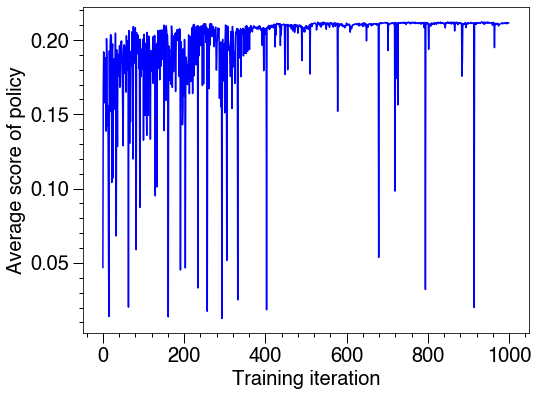

No handles with labels found to put in legend.


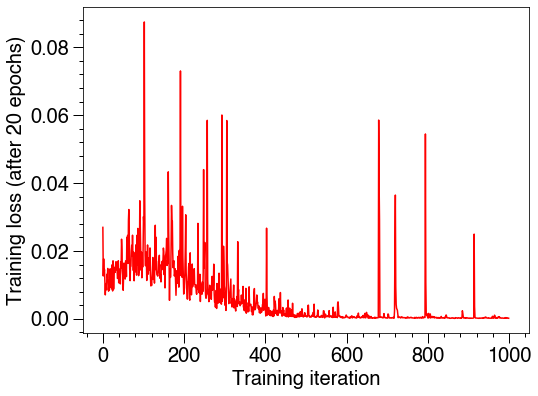

In [2753]:
# Save data
# with open('./Data/CS1_score_GA_unconstrained', 'wb') as f:
#     pickle.dump(score_list, f, pickle.HIGHEST_PROTOCOL)
# with open('./Data/CS1_loss_GA_unconstrained', 'wb') as f:
#     pickle.dump(training_loss_list, f, pickle.HIGHEST_PROTOCOL)

# Load pre-run data
# with open('./Data/CS1_score_GA_unconstrained', 'rb') as f:
#     score_list = pickle.load(f)
# with open('./Data/CS1_loss_GA_unconstrained', 'rb') as f:
#     training_loss_list = pickle.load(f)

# Plot score vs. training iteration
fig, ax = plt.subplots(figsize=(8,6))
ax.minorticks_on()
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(which='major', length=10, width=1, direction='out')
ax.tick_params(which='minor', length=4, width=1, direction='out')
plt.plot(iteration_list, score_list, color = 'b')
plt.legend(frameon =  0)
plt.ylabel('Average score of policy', fontsize = 20)
plt.xlabel('Training iteration', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

# Plot training loss vs. training iteration
fig, ax = plt.subplots(figsize=(8,6))
ax.minorticks_on()
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(which='major', length=10, width=1, direction='out')
ax.tick_params(which='minor', length=4, width=1, direction='out')
plt.plot(iteration_list, training_loss_list, color = 'r')
plt.legend(frameon =  0)
plt.ylabel('Training loss (after 20 epochs)', fontsize = 20)
plt.xlabel('Training iteration', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [14]:
# Q_net = torch.nn.Sequential(
#         torch.nn.Linear(6,   200, bias = True), # 6 input nodes
#         torch.nn.LeakyReLU(),    # apply ReLU activation function
#         torch.nn.Linear(200, 200, bias = True), 
#         torch.nn.LeakyReLU(),    # apply ReLU activation function
#         torch.nn.Linear(200,   1, bias = True), # 1 output node
#     ).double()

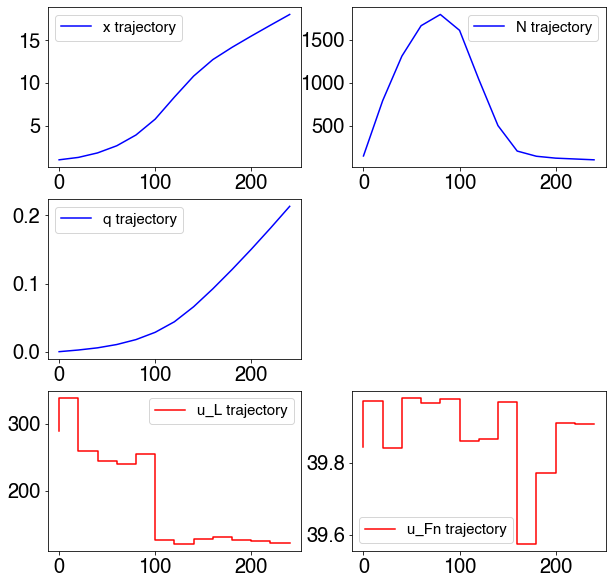

Score: 0.2132957972354426


In [3089]:
episode = generate_episode_with_NN(NN = max_action, initial_state = [1.0, 150.0, 0, 0], epsilon = 0)
plot_episode(episode) 

In [1298]:
score_NN_policy(GA_optimize, [1.0, 150.0, 0, 0], num_iterations = 100)

0.20795865725499407

## Genetic algorithm

In [226]:
# Source: Ahmed Gad - https://github.com/ahmedfgad/GeneticAlgorithmPython/tree/master/Tutorial%20Project
def cal_pop_fitness(population, initial_state):
    # Calculating the fitness value of each solution in the current population.
    # The fitness function calulates the sum of products between each input and its corresponding weight.
    state = []
    population = population.tolist() # convert 2D array to list of lists
    for i in range(len(population)):
        s = initial_state + population[i] # Append action to state 
        s = standardize_state_Q(s) # Standardize
        state += [s]
    state = torch.tensor(state).double()
    fitness = Q_net(state).detach().numpy()
    return fitness

def cal_pop_fitness_constrained(population, initial_state, g1_threshold, g2_threshold):
    # Calculating the fitness value of each solution in the current population.
    # The fitness function calulates the sum of products between each input and its corresponding weight.
    
    # CALCULATE Q-FITNESS
    state = []
    population = population.tolist() # convert 2D array to list of lists
    for i in range(len(population)):
        s = initial_state + population[i] # Append action to state 
        s = standardize_state_Q(s) # Standardize using Q-network mean & std
        state += [s]
    state = torch.tensor(state).double()
    fitness_Q = (Q_net(state).detach().numpy() * y_std_Q) + y_mean_Q # Unstandardized Q-network fitness
#     print('fitness_Q:', fitness_Q)
    # CALCULATE C-FITNESS 
    state = []
    
    initial_state_for_C = copy.deepcopy(initial_state)
    initial_state_for_C[3] = 240. - initial_state_for_C[3] #### NEED TO TRANSFORM T TO T_F- T #####
#     print('population:', population)
    for i in range(len(population)):
        s = initial_state_for_C + population[i] # Append action to state 
#         print('non-standardized state:',s)
        s = standardize_state_C(s) # Standardize using C-network mean & std
#         print('standardized state:',s)
        state += [s]
    state = torch.tensor(state).double()
    state_copy = copy.deepcopy(state) # Just to be sure
    
    fitness_g1 = -1*((g1_net(state).detach().numpy() * y_std_C[0]) + y_mean_C[0])  # Unstandardized C-network fitness - NEGATIVE SIGN because -ve g1_net values denote higher fitness!
    fitness_g2 = -1*((g2_net(state_copy).detach().numpy() * y_std_C[1]) + y_mean_C[1])
#     print('fitness_g1:', fitness_g1)
#     print('fitness_g2:', fitness_g2)
    # COMBINE Q-FITNESS AND C-FITNESS
    fitness_overall = []
    for i in range(len(population)):
        
        # include gl and g2 only for now
        f = max(0, fitness_Q[i].item()) + 100*min(0, fitness_g1[i].item() + g1_threshold) + 10000*min(0, fitness_g2[i].item() + g2_threshold)
        fitness_overall += [f]
    
    return fitness_overall

def select_mating_pool(pop, fitness, num_parents):
    # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    parents = np.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99999999999     # Make the current parent the most unfit
    return parents

def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    # The point at which crossover takes place between two parents. Usually, it is at the center.
    crossover_point = np.uint8(offspring_size[1]/2) # Returns 1 in this case (because 2 values)

    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = k%parents.shape[0]
        # Index of the second parent to mate.
        parent2_idx = (k+1)%parents.shape[0]
        # The new offspring will have its first half of its genes taken from the first parent.
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        # The new offspring will have its second half of its genes taken from the second parent.
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

def mutation(offspring_crossover, mut_percen):

    for idx in range(offspring_crossover.shape[0]): # Iterate over individual offspring
        for feature in range(offspring_crossover.shape[1]): # Iterate over its features 
            r = np.random.uniform(0, 1)
            
            if r < mut_percen: # If mutation occurs
#                 print('Mutated')
                if feature == 0: # If u_L 
                    offspring_crossover[idx, feature] = np.random.uniform(120, 400) # Pick random u_L
                else:            # Else u_Fn
                    offspring_crossover[idx, feature] = np.random.uniform(0, 40) # Pick random u_Fn
    return offspring_crossover

def generate_random_episode_constrained(initial_state, g1_threshold = 0): 
    '''Generates an episode using RANDOM policy
    threshold is the tolerance of the limit, where 
    0            : Limit itself (as per defined in extract_constraint_values_from_episode() function)
    +ve threshold: Looser limit   
    -ve threshold: Stricter limit 
    '''
    episode = []
    state = initial_state  # Initial state
    for i in range(13):   # Take (12 + 1) steps
        predicted_c = np.inf # Initialize constraint
        while predicted_c > g1_threshold: # Keep choosing a different action this until constraint is LESS THAN zero
            old_state = state # Old state for storing into episode
            old_state_without_action = old_state
            old_state = list(old_state)
            old_state[3] = 240.0 - old_state[3] # Convert to t to (t - t_f)
            u_L  = np.random.uniform(120, 400) # Pick random u_L
            u_Fn = np.random.uniform(0, 40)    # Pick random u_Fn
            action = [u_L, u_Fn]
            old_state += action     # Append action to state

            old_state_standardized = old_state.copy()
            old_state_standardized = standardize_state_C(old_state_standardized)

            old_state_standardized = torch.tensor(old_state_standardized)
            predicted_c = ((g1_net(old_state_standardized).detach().numpy())*y_std_C) + y_mean_C # Update predicted constraint
#             print('predicted_c:', predicted_c)
        state, reward  = transition(state, action)     # Evolve to get new state 
        episode       += [[list(old_state_without_action), action, reward]] # Update step
    return episode
# generate_random_episode_constrained(initial_state = [1.0,150.0,0.,0.], g1_threshold = 0)

def GA_optimize(state, mut_percen = 0.1):
    '''Argument: State [Cx, Cn, Cq, t]
       Output: Control [u_L, u_Fn] that maximizes Q 
    '''
    num_features       = 2  # Number of features (u_L and u_Fn)
    sol_per_pop        = 10 # Number of individuals per population
    num_parents_mating = 5  # Numbers of parents selected from each generation
    num_generations    = 10 # Number of generations
    
    mut_percen = mut_percen # Initial probability of mutation

    #Creating the initial population.
    new_pop = []
    for i in range(200): # Initial pop
        u_L  = np.random.uniform(120, 400) # Pick random u_L
        u_Fn = np.random.uniform(0, 40)    # Pick random u_Fn
        new_pop += [[u_L, u_Fn]]
    new_pop = np.array(new_pop)
#     print('new_pop',new_pop)

    decay_factor = (0.01/mut_percen)**(1/num_generations) # Define decay factor for mut_percen

    state = state
    avg_fitness_list = [] # Store average fitness scores
    max_fitness_list = [] # Store max fitness scores
    generation_list = []  # Store generation index

    for generation in range(num_generations):
        
        # Measuring the fitness of each chromosome in the population.
        fitness = cal_pop_fitness(new_pop, state)

        avg_fit = np.mean(fitness) # Average fitness
        max_fit = np.max(fitness)  # Max fitness of the generation
    #     print('==== Generation %.0f ====' % generation)
    #     print('Average fitness:', avg_fit)
    #     print('Max fitness:', max_fit)
    #     print('')
        avg_fitness_list += [avg_fit]    # Save average fitness score for plotting
        max_fitness_list += [max_fit]    # Save average fitness score for plotting
        generation_list  += [generation] # Save generation index

        # Selecting the best parents in the population for mating
        parents = select_mating_pool(new_pop, fitness, num_parents_mating)
#         print('parents:',parents)

        # Generating next generation using crossover
        offspring_crossover = crossover(parents, offspring_size=(sol_per_pop-parents.shape[0], num_features))
#         print('offspring_crossover',offspring_crossover)

        offspring_mutation = mutation(offspring_crossover, mut_percen = mut_percen)
#         print('offspring_mutation',offspring_mutation)

        # Creating the new population based on the parents and offspring
        new_pop[0:parents.shape[0], :] = parents
        new_pop[parents.shape[0]:sol_per_pop, :] = offspring_mutation

        # Cull excess initial population
        new_pop = new_pop[0:sol_per_pop,:]

    #     mut_percen = 0.5*e**(-1*generation/(num_generations/3)) # Decay
        mut_percen *= decay_factor
    
    max_action = new_pop[0] # Select the fittest action from final population
    return max_action
# GA_optimize([1.0, 150.0, 0, 0], mut_percen = 0.25) # Test function

# def GA_optimize_constrained(state, g1_threshold, g2_threshold, init_mut_percen = 0.01):
#     '''Argument: State [Cx, Cn, Cq, t]
#        Output: Control [u_L, u_Fn] that maximizes Q and avoids violation of constraints
#     '''
#     num_features       = 2  # Number of features (u_L and u_Fn)
#     sol_per_pop        = 10 # Number of individuals per population
#     num_parents_mating = 5  # Numbers of parents selected from each generation
#     num_generations    = 10 # Number of generations
    
#     max_fitness = -np.inf # Initialize fitness
    
#     while max_fitness < 0: # Keep running this loop until no violations (no -ve fitness) occurs
    
#         mut_percen = init_mut_percen # Initial probability of mutation

#         #Creating the initial population.
#         new_pop = []
#         for i in range(200): # Initial pop
#             u_L  = np.random.uniform(120, 400) # Pick random u_L
#             u_Fn = np.random.uniform(0, 40)    # Pick random u_Fn
#             new_pop += [[u_L, u_Fn]]
#         new_pop = np.array(new_pop)
#     #     print('new_pop',new_pop)

#         decay_factor = (0.01/mut_percen)**(1/num_generations) # Define decay factor for mut_percen

#         state = state
#         avg_fitness_list = [] # Store average fitness scores
#         max_fitness_list = [] # Store max fitness scores
#         generation_list = []  # Store generation index

#         for generation in range(num_generations):

#             # Measuring the fitness of each chromosome in the population.
#             fitness = cal_pop_fitness_constrained(new_pop, state, g1_threshold = g1_threshold, g2_threshold = g2_threshold)

#             avg_fit = np.mean(fitness) # Average fitness
#             max_fit = np.max(fitness)  # Max fitness of the generation
#         #     print('==== Generation %.0f ====' % generation)
#         #     print('Average fitness:', avg_fit)
#         #     print('Max fitness:', max_fit)
#         #     print('')
#             avg_fitness_list += [avg_fit]    # Save average fitness score for plotting
#             max_fitness_list += [max_fit]    # Save average fitness score for plotting
#             generation_list  += [generation] # Save generation index

#             # Selecting the best parents in the population for mating
#             parents = select_mating_pool(new_pop, fitness, num_parents_mating)
#     #         print('parents:',parents)

#             # Generating next generation using crossover
#             offspring_crossover = crossover(parents, offspring_size=(sol_per_pop-parents.shape[0], num_features))
#     #         print('offspring_crossover',offspring_crossover)

#             offspring_mutation = mutation(offspring_crossover, mut_percen = mut_percen)
#     #         print('offspring_mutation',offspring_mutation)

#             # Creating the new population based on the parents and offspring
#             new_pop[0:parents.shape[0], :] = parents
#             new_pop[parents.shape[0]:sol_per_pop, :] = offspring_mutation

#             # Cull excess initial population
#             new_pop = new_pop[0:sol_per_pop,:]

#         #     mut_percen = 0.5*e**(-1*generation/(num_generations/3)) # Decay
#     #         mut_percen *= decay_factor

#         max_action = new_pop[0] # Select the fittest action from final population
#         max_fitness = max_fitness_list[-1] # Update max_fitness
# #     plt.figure()
# #     plt.plot(generation_list, avg_fitness_list, label = 'Avg (%.3f)'%avg_fitness_list[-1])
# #     plt.plot(generation_list, max_fitness_list, label = 'Max (%.3f)'%max_fitness_list[-1])
# #     plt.legend()
# #     plt.show()
# #     print(max_fitness)
    
#     return max_action
# GA_optimize_constrained([1.0, 150.0, 0, 0], g1_threshold = g1_threshold, g2_threshold = g2_threshold ) # Test function

In [227]:
def GA_optimize_constrained(state, g1_threshold, g2_threshold, init_mut_percen = 0.01):
    '''Argument: State [Cx, Cn, Cq, t]
       Output: Control [u_L, u_Fn] that maximizes Q and avoids violation of constraints
    '''
    max_fitness = -np.inf # Initialize fitness
    
    while max_fitness < 0: # Keep running this loop until no violations (no -ve fitness) occurs
    
        #Creating the initial population.
        new_pop = []
        for i in range(1000): # Initial pop
            u_L  = np.random.uniform(120, 400) # Pick random u_L
            u_Fn = np.random.uniform(0, 40)    # Pick random u_Fn
            new_pop += [[u_L, u_Fn]]
            
        new_pop = np.array(new_pop)

        fitness = cal_pop_fitness_constrained(new_pop, state, g1_threshold = g1_threshold, g2_threshold = g2_threshold)
        max_idx = np.argmax(fitness)
        max_action  = new_pop[max_idx]
        max_fitness = fitness[max_idx]
            
    return max_action
# GA_optimize_constrained([1.0, 150.0, 0, 0], g1_threshold = 1000, g2_threshold = 100 ) # Test function

In [4]:
episode = generate_episode_with_NN(GA_optimize_constrained, [1.0, 150.0, 0, 0], epsilon = 0, 
                                   g1_threshold = g1_threshold,
                                   g2_threshold = g2_threshold)
episode

NameError: name 'g1_threshold' is not defined

In [431]:
#test constrained
sol_per_pop = 200 # Number of individuals per population
num_features = 2 # Number of features (u_L and u_Fn)
num_parents_mating = 2
num_generations = 10
mut_percen = 0.1
state = [1.0, 150.0, 0, 0]
new_pop = []
for i in range(sol_per_pop): # Initial pop
    u_L  = np.random.uniform(120, 400) # Pick random u_L
    u_Fn = np.random.uniform(0, 40)    # Pick random u_Fn
    new_pop += [[u_L, u_Fn]]
new_pop = np.array(new_pop)
print(new_pop)

[[2.93083547e+02 3.22624666e+01]
 [1.92780699e+02 2.48295058e+01]
 [1.70116380e+02 1.35786097e+01]
 [3.95616952e+02 1.95813957e+01]
 [2.26379559e+02 1.31499445e+01]
 [3.76940597e+02 1.48982379e+01]
 [2.45815655e+02 3.23222244e+01]
 [3.09199664e+02 3.62348922e+01]
 [2.48453206e+02 3.15649529e+01]
 [1.52743026e+02 2.35441583e+01]
 [3.74621151e+02 4.93943561e+00]
 [1.78878158e+02 2.54669460e+01]
 [1.56592445e+02 1.22421087e+01]
 [1.20397320e+02 3.81016335e+01]
 [1.74228325e+02 1.13460636e+01]
 [1.57770204e+02 3.69530870e+01]
 [3.45485678e+02 3.20157658e+01]
 [3.05767360e+02 3.96142016e+01]
 [2.00637825e+02 1.70570328e+01]
 [2.54826611e+02 1.68495815e+01]
 [3.33773245e+02 1.34065968e+01]
 [2.27877233e+02 2.56301383e+01]
 [3.32913952e+02 2.61600912e+01]
 [3.15734581e+02 5.82722733e+00]
 [1.76222790e+02 1.18058624e+01]
 [3.31161743e+02 2.56055826e+00]
 [2.84323212e+02 1.00010402e+01]
 [2.59571498e+02 1.90416854e+01]
 [2.24235810e+02 1.87460198e+01]
 [2.13090921e+02 3.88554490e+01]
 [2.959237

In [441]:
fitness = cal_pop_fitness_constrained(new_pop, [1.0, 150.0, 0, 0], 
                                      g1_threshold = 500, 
                                      g2_threshold = 0.004)
fitness

[0.037545224516673525,
 0.038041887948617736,
 0.033701583910184116,
 0.03284086624562786,
 0.03464541243430473,
 0.032629542530599534,
 0.03993464557353284,
 0.03743482060722952,
 0.03971201100151314,
 0.035876401010263965,
 0.029402192981725604,
 0.0378770853863862,
 0.0334460492910301,
 0.04170221364391549,
 0.033896381163334724,
 0.04196719823427368,
 0.035056844019289546,
 0.038026168554077214,
 0.03486844935201707,
 0.03576804116716378,
 0.034038533870605736,
 0.038455156978232284,
 0.03603086253066762,
 0.03242237291550744,
 0.033898605963132614,
 0.030699379944658753,
 0.03398200897998137,
 0.036593294399123025,
 0.03593544409303877,
 0.04200490042781145,
 0.03594523049051178,
 0.04077513846466409,
 0.03386702414222559,
 0.032693039115608113,
 0.03759436916645501,
 0.03651310377419087,
 0.033734576681278494,
 0.0370703564709844,
 0.035323519389704267,
 0.03349651844360801,
 0.03440611635847486,
 0.034441130002026074,
 0.0372495440561936,
 0.03527813277260091,
 0.041189014707151

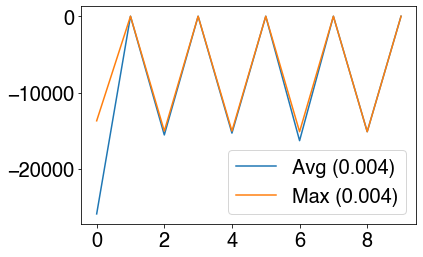

array([379.75412521,   2.26208791])

In [440]:
GA_optimize_constrained([1.0, 150.0, 0, 0], g1_threshold = 0, g2_threshold = 0, init_mut_percen = 0.01)

new_pop [[1.81211496e+02 3.05246017e+01]
 [3.66489746e+02 1.58744306e+00]
 [2.92928939e+02 5.79655101e+00]
 [3.07457448e+02 2.80108055e+01]
 [2.43509642e+02 1.30770081e+00]
 [3.83399417e+02 3.82602683e-01]
 [3.98013401e+02 2.68004595e+01]
 [2.15331826e+02 1.50913508e+01]
 [2.72530442e+02 3.74622065e+01]
 [1.80721262e+02 1.23045924e+01]
 [1.27394965e+02 3.03444751e+01]
 [1.95803695e+02 3.30698993e+01]
 [2.44791102e+02 7.54029615e+00]
 [2.42028887e+02 1.98059296e+01]
 [2.00782451e+02 5.80052282e+00]
 [2.73956813e+02 1.45351603e+01]]
parents: [[195.80369457  33.06989933]
 [181.21149575  30.52460172]
 [127.39496493  30.34447507]
 [242.02888667  19.80592958]
 [272.53044246  37.46220653]
 [215.3318256   15.09135077]
 [273.95681302  14.53516025]
 [307.45744796  28.01080548]]
offspring_crossover [[195.80369457  30.52460172]
 [181.21149575  30.34447507]
 [127.39496493  19.80592958]
 [242.02888667  37.46220653]
 [272.53044246  15.09135077]
 [215.3318256   14.53516025]
 [273.95681302  28.01080548

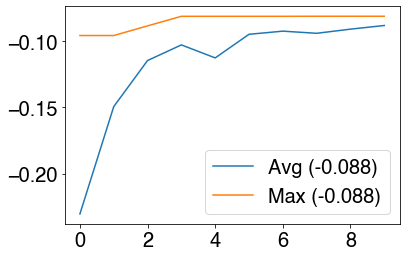

In [1405]:
sol_per_pop = 16 # Number of individuals per population
num_features = 2 # Number of features (u_L and u_Fn)
num_parents_mating = 8
num_generations = 10
mut_percen = 0.1

decay_factor = (0.01/mut_percen)**(1/num_generations) # Define decay factor for mut_percen
state = [1.0, 150.0, 0, 0]
avg_fitness_list = []
max_fitness_list = []
generation_list = []

#Creating the initial population.
new_pop = []
for i in range(sol_per_pop): # Initial pop
    u_L  = np.random.uniform(120, 400) # Pick random u_L
    u_Fn = np.random.uniform(0, 40)    # Pick random u_Fn
    new_pop += [[u_L, u_Fn]]
new_pop = np.array(new_pop)
print('new_pop',new_pop)

for generation in range(num_generations):
        # Measuring the fitness of each chromosome in the population.
    fitness = cal_pop_fitness(new_pop, state)
    
    avg_fit = np.mean(fitness)
    max_fit = np.max(fitness)
    avg_fitness_list += [avg_fit]    # Save average fitness score for plotting
    max_fitness_list += [max_fit]    # Save average fitness score for plotting
    generation_list  += [generation] # Save generation index

        # Selecting the best parents in the population for mating.
    parents = select_mating_pool(new_pop, fitness, num_parents_mating)
    print('parents:',parents)

        # Generating next generation using crossover.
    offspring_crossover = crossover(parents, offspring_size=(sol_per_pop-parents.shape[0], num_features))
    print('offspring_crossover',offspring_crossover)

    offspring_mutation = mutation(offspring_crossover, mut_percen = mut_percen)
    print('offspring_mutation',offspring_mutation)

        # Creating the new population based on the parents and offspring.
    new_pop[0:parents.shape[0], :] = parents
    new_pop[parents.shape[0]:sol_per_pop, :] = offspring_mutation

        # Cull excess
    new_pop = new_pop[0:sol_per_pop,:]

    #     mut_percen = 0.5*e**(-1*generation/(num_generations/3)) # Decay
    #     mut_percen *= decay_factor
    print('Mut_percen:', mut_percen)
    print('new_pop',new_pop)

plt.figure()
plt.plot(generation_list, avg_fitness_list, label = 'Avg (%.3f)'%avg_fitness_list[-1])
plt.plot(generation_list, max_fitness_list, label = 'Max (%.3f)'%avg_fitness_list[-1])
plt.legend()
plt.show()

new_pop [[1.20763215e+02 3.63771522e+01]
 [1.82185173e+02 9.79185940e-03]
 [1.88919402e+02 7.96462500e+00]
 [2.70810444e+02 2.25450981e+01]
 [2.64681597e+02 1.42065928e+01]
 [3.36304174e+02 2.97004334e+01]
 [3.89137778e+02 2.75539665e+01]
 [1.92059897e+02 4.41183515e+00]
 [1.59832108e+02 1.05676672e+01]
 [1.20815316e+02 1.76080594e+01]
 [2.83246277e+02 1.96534382e+01]
 [2.51090465e+02 3.92791381e+01]
 [3.79864022e+02 1.86859345e+01]
 [1.50971979e+02 1.98787630e+01]
 [1.37434996e+02 2.64851089e+01]
 [1.52077675e+02 1.82547963e+01]
 [1.62411976e+02 1.75672305e+01]
 [2.18755770e+02 2.81747050e+01]
 [2.42040546e+02 2.42773980e+01]
 [2.23823086e+02 3.82709577e+01]
 [2.31444400e+02 2.36154036e+01]
 [2.36698413e+02 3.14414183e+01]
 [3.31266643e+02 1.19902283e+01]
 [3.74656737e+02 2.31034703e+01]
 [3.96874623e+02 3.44678898e+00]
 [2.18969961e+02 3.71700072e+01]
 [1.24125990e+02 9.14123330e+00]
 [3.85618627e+02 1.89360889e+01]
 [3.24492800e+02 3.06438990e+01]
 [2.54405934e+02 3.94357322e+00]
 [

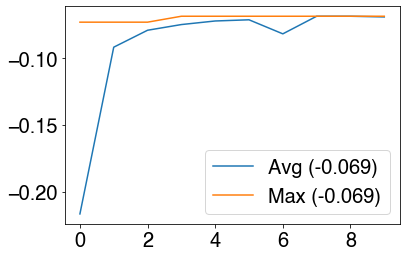

In [1352]:
sol_per_pop = 10 # Number of individuals per population
num_features = 2 # Number of features (u_L and u_Fn)
mut_percen = 0.1

#Creating the initial population.
new_pop = []
for i in range(200): # Initial pop
    u_L  = np.random.uniform(120, 400) # Pick random u_L
    u_Fn = np.random.uniform(0, 40)    # Pick random u_Fn
    new_pop += [[u_L, u_Fn]]
new_pop = np.array(new_pop)
print('new_pop',new_pop)

num_generations = 10
decay_factor = (0.01/mut_percen)**(1/num_generations) # Define decay factor for mut_percen
num_parents_mating = 5
state = [1.0, 150.0, 0, 0]
avg_fitness_list = []
max_fitness_list = []
generation_list = []

for generation in range(num_generations):
    # Measuring the fitness of each chromosome in the population.
    fitness = cal_pop_fitness(new_pop, state)
    
    avg_fit = np.mean(fitness)
    max_fit = np.max(fitness)
#     print('==== Generation %.0f ====' % generation)
#     print('Average fitness:', avg_fit)
#     print('Max fitness:', max_fit)
#     print('')
    avg_fitness_list += [avg_fit]    # Save average fitness score for plotting
    max_fitness_list += [max_fit]    # Save average fitness score for plotting
    generation_list  += [generation] # Save generation index
    
    # Selecting the best parents in the population for mating.
    parents = select_mating_pool(new_pop, fitness, num_parents_mating)
    print('parents:',parents)

    # Generating next generation using crossover.
    offspring_crossover = crossover(parents, offspring_size=(sol_per_pop-parents.shape[0], num_features))
    print('offspring_crossover',offspring_crossover)

    offspring_mutation = mutation(offspring_crossover, mut_percen = mut_percen)
    print('offspring_mutation',offspring_mutation)

    # Creating the new population based on the parents and offspring.
    new_pop[0:parents.shape[0], :] = parents
    new_pop[parents.shape[0]:sol_per_pop, :] = offspring_mutation

    # Cull excess
    new_pop = new_pop[0:sol_per_pop,:]
    
#     mut_percen = 0.5*e**(-1*generation/(num_generations/3)) # Decay
#     mut_percen *= decay_factor
    print('Mut_percen:', mut_percen)
    print('new_pop',new_pop)
plt.figure()
plt.plot(generation_list, avg_fitness_list, label = 'Avg (%.3f)'%avg_fitness_list[-1])
plt.plot(generation_list, max_fitness_list, label = 'Max (%.3f)'%avg_fitness_list[-1])
plt.legend()
plt.show()

In [26]:
# Inspecting the spread of actions predicted by GA
start = time.time()  # For timing purposes
u_L_pool  = []
u_Fn_pool = []
for i in range(500):
    u_L, u_Fn = GA_optimize_constrained([1.0, 150.0, 0, 0], g1_threshold = 0, g2_threshold = 0, init_mut_percen = 0.01)
    u_L_pool  += [u_L]
    u_Fn_pool += [u_Fn]
end = time.time()  # For timing purposes
print(end - start)
plt.figure()
plt.scatter(u_L_pool, u_Fn_pool, s = 0.5)
plt.scatter(np.mean(u_L_pool), np.mean(u_Fn_pool), color = 'r')
plt.xlim(120, 400)
plt.ylim(0,40)
plt.xlabel('u_L')
plt.ylabel('u_Fn')

KeyboardInterrupt: 

6.305979013442993


Text(0, 0.5, 'u_Fn')

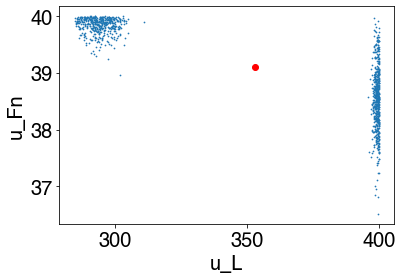

In [2513]:
# Inspecting the spread of predicted max_actions
start = time.time()  # For timing purposes
u_L_pool  = []
u_Fn_pool = []
for i in range(1000):
    u_L, u_Fn = max_action([1.0, 150.0, 0, 0])
    u_L_pool += [u_L]
    u_Fn_pool += [u_Fn]
end = time.time()  # For timing purposes
print(end - start)
plt.figure()
plt.scatter(u_L_pool, u_Fn_pool, s = 0.5)
plt.scatter(np.mean(u_L_pool), np.mean(u_Fn_pool), color = 'r')
# plt.xlim(120, 250)
# plt.ylim(35,41)
plt.xlabel('u_L')
plt.ylabel('u_Fn')

# Introducing constraints
The goal is to train a 2nd neural network to predict a constraint value given a state-action pair. The data used to train this NN will generated using a random policy in the cells below.

### Method 1: Training Q-network and C-network separately

In [21]:
episode = generate_random_episode(initial_state = [1.0,150.0,0,0]) 
episode

[[[1.0, 150.0, 0, 0], [385.4330527694228, 36.399866325867045], 0],
 [[1.2629873326272418, 734.1180076369025, 0.0022591486173569424, 20.0],
  [327.3480304392167, 37.83984025977543],
  0],
 [[1.7705310171678752, 1219.7687709662446, 0.005425173423517918, 40.0],
  [242.8729189316441, 39.80906742415014],
  0],
 [[2.5705898324392567, 1590.71859577154, 0.0102199775116497, 60.0],
  [155.27021477664582, 9.36741882515777],
  0],
 [[3.6056781743526196, 1224.9582762313864, 0.017350016817213855, 80.0],
  [307.43150425886483, 17.668442168358904],
  0],
 [[5.081510563136995, 790.222419702922, 0.026552656986763967, 100.0],
  [362.7597371424092, 5.300944151141134],
  0],
 [[6.4120112274561345, 166.38445688572796, 0.0381378940667493, 120.0],
  [206.67455273872355, 18.053441092983466],
  0],
 [[7.104322201605452, 109.84581744266178, 0.05196450239966164, 140.0],
  [254.50527662905523, 12.923384489451767],
  0],
 [[7.561283963505287, 63.595085207028546, 0.06482769085473657, 160.0],
  [134.0729855950401, 11

In [29]:
extract_constraint_values_from_episode(episode)

([[1.0, 150.0, 0, 240.0, 277.52653196864594, 22.921261254187563],
  [1.2256781055078272,
   483.5064687923391,
   0.0023996740391579443,
   220.0,
   152.234967369794,
   28.720160064144054],
  [1.599495664251366,
   855.2229494437751,
   0.00564623822616382,
   200.0,
   383.331025006073,
   8.273743522048518],
  [2.1775647957117257,
   710.130564408416,
   0.009437127172721927,
   180.0,
   344.63098300356273,
   25.94075399958331],
  [2.970936733826186,
   802.9596938639012,
   0.014720127254524523,
   160.0,
   310.53872115558977,
   24.686594042275907],
  [4.0650384031407265,
   709.4793141830538,
   0.0221174414872079,
   140.0,
   338.87620021837836,
   28.73924481629919],
  [5.431507278547316,
   547.19563778063,
   0.031874167156737736,
   120.0,
   342.15010614129505,
   0.13852803574633477],
  [6.316053563835549,
   43.280718578899275,
   0.04316470324241774,
   100.0,
   342.0278444279795,
   4.284494435939212],
  [6.399453696845697,
   22.645843774163087,
   0.050575409411

In [15]:
# Generate UNCONSTRAINED data for training the constraint neural network

start = time.time()  # For timing purposes
state_action = []    # To store state and action [Cx, Cn, Cq, t-t_f, u_L, u_Fn]
g1_constraint   = []    # To store g1 constraint 
g2_constraint   = []    # To store g1 constraint 
num_episodes = 10000 # Number of episodes to generate

for j in range(num_episodes):
    generated_episode = generate_random_episode(initial_state = [1.0,150.0,0,0])  # Generate one episode
#     generated_episode = generate_episode_with_NN(GA_optimize, [1.0, 150.0, 0, 0], epsilon = 0.5)  # Generate one episode    
#     generated_episode = generate_random_episode_constrained(initial_state = [1.0,150.0,0,0], g1_threshold = 60)
    s_a, g1, g2 = extract_constraint_values_from_episode(generated_episode)            # Extract data from episode
    
    state_action += s_a             # Append state and action 
    g1_constraint   += g1           # Append g1 constraint
    g2_constraint   += g2           # Append g1 constraint

end = time.time() # For timing purposes

state_action = np.array(state_action)
g1_constraint   = np.array(g1_constraint)
g2_constraint   = np.array(g2_constraint)
print('')
print('Time taken:', end - start)
print('==========INPUT [Cx, Cn, Cq, t_f-t, u_L, u_Fn]==========')
print(state_action)
print('')
print('==========TARGET VALUES [g1]==========')
print(g1_constraint)
print('==========TARGET VALUES [g2]==========')
print(g2_constraint)


Time taken: 85.20657205581665
==========INPUT [Cx, Cn, Cq, t_f-t, u_L, u_Fn]==========
[[1.00000000e+00 1.50000000e+02 0.00000000e+00 2.40000000e+02
  2.49404494e+02 3.49697425e+01]
 [1.26559958e+00 7.04185667e+02 2.48114766e-03 2.20000000e+02
  3.81264618e+02 3.38023478e+01]
 [1.75052734e+00 1.12056678e+03 5.51177391e-03 2.00000000e+02
  3.33915279e+02 2.73205090e+01]
 ...
 [7.79180451e+00 2.03505105e+02 7.24185956e-02 6.00000000e+01
  2.76381603e+02 7.29339065e+00]
 [8.25830285e+00 3.22178160e+01 8.43518538e-02 4.00000000e+01
  1.64689497e+02 1.77679808e+00]
 [8.21259194e+00 7.57676075e+00 8.66155941e-02 2.00000000e+01
  2.21768807e+02 1.49378134e+01]]

==========TARGET VALUES [g1]==========
[[ 465.49054874]
 [ 465.49054874]
 [ 465.49054874]
 ...
 [-736.34418489]
 [-736.34418489]
 [-736.34418489]]
==========TARGET VALUES [g2]==========
[[-0.01144045]
 [-0.01374403]
 [-0.01761123]
 ...
 [-0.00648948]
 [-0.00372292]
 [ 0.00389571]]


No handles with labels found to put in legend.


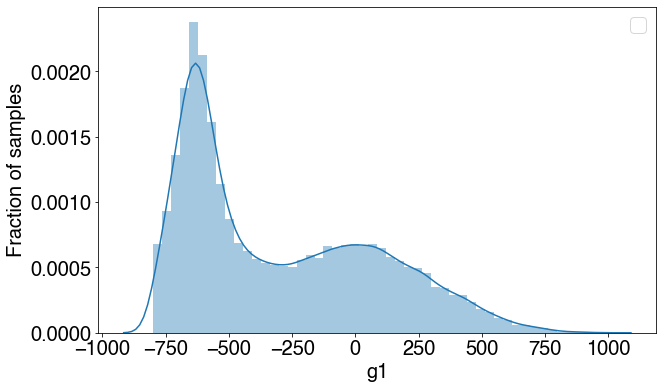

No handles with labels found to put in legend.


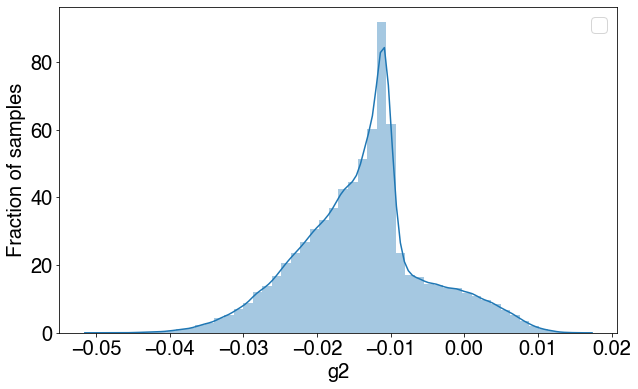

In [16]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(g1_constraint)
ax.set(xlabel= 'g1', ylabel = 'Fraction of samples')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(g2_constraint)
ax.set(xlabel= 'g2', ylabel = 'Fraction of samples')
plt.legend()
plt.show()

In [17]:
# Combine g1_constraint and g2_constraint into a (n x 2) array for standardization purposes
g1g2_constraint = []
for i in range(len(g1_constraint)):
    g1g2_constraint += [[g1_constraint[i][0], g2_constraint[i][0]]]
g1g2_constraint = np.array(g1g2_constraint)
g1g2_constraint

array([[ 4.65490549e+02, -1.14404477e-02],
       [ 4.65490549e+02, -1.37440269e-02],
       [ 4.65490549e+02, -1.76112326e-02],
       ...,
       [-7.36344185e+02, -6.48947755e-03],
       [-7.36344185e+02, -3.72291723e-03],
       [-7.36344185e+02,  3.89570713e-03]])

In [18]:
# Standardize data for C-network
X = state_action
y = g1g2_constraint

scaler_X = StandardScaler().fit(X)
scaler_y = StandardScaler().fit(y)

# Get mean and std
x_mean_C = scaler_X.mean_
x_std_C  = scaler_X.scale_
y_mean_C = scaler_y.mean_
y_std_C  = scaler_y.scale_

# Scale x
X_scaled = np.zeros(X.shape)
for feature in range(len(x_mean_C)): 
    X_scaled[:,feature] = (X[:,feature] - x_mean_C[feature])/x_std_C[feature]

# Scale g1
g1_scaled = np.zeros([y.shape[0],1])
g1_scaled[:] = (g1_constraint[:] - y_mean_C[0])/y_std_C[0] # Use 0th index of y_mean and y_std

# Scale g2
g2_scaled = np.zeros([y.shape[0],1])
g2_scaled[:] = (g2_constraint[:] - y_mean_C[1])/y_std_C[1] # Use 1st index of y_mean and y_std

# Convert into tensors
X_scaled = torch.tensor(X_scaled)
g1_scaled = torch.tensor(g1_scaled)
g2_scaled = torch.tensor(g2_scaled)
X_scaled, g1_scaled, g2_scaled

(tensor([[-1.2198, -0.7504, -1.1115,  1.5933, -0.1338,  1.3002],
         [-1.1277,  0.9487, -1.0323,  1.3036,  1.4996,  1.1991],
         [-0.9595,  2.2253, -0.9357,  1.0139,  0.9130,  0.6381],
         ...,
         [ 1.1358, -0.5863,  1.1986, -1.0139,  0.2004, -1.0955],
         [ 1.2976, -1.1115,  1.5793, -1.3036, -1.1832, -1.5730],
         [ 1.2817, -1.1870,  1.6515, -1.5933, -0.4761, -0.4338]],
        dtype=torch.float64),
 tensor([[ 2.0143],
         [ 2.0143],
         [ 2.0143],
         ...,
         [-1.1572],
         [-1.1572],
         [-1.1572]], dtype=torch.float64),
 tensor([[ 0.2682],
         [ 0.0021],
         [-0.4447],
         ...,
         [ 0.8403],
         [ 1.1599],
         [ 2.0402]], dtype=torch.float64))

In [19]:
len(X_scaled), len(g1_scaled), len(g2_scaled)

(120000, 120000, 120000)

### Training g1-net

In [ ]:
g1_net = torch.nn.Sequential(
        torch.nn.Linear(6, 200, bias = True), # 6 input nodes (Cx, Cn, Cq, t_f - t, u_L, u_Fn)
        torch.nn.LeakyReLU(),                
        torch.nn.Linear(200, 200, bias = True), 
        torch.nn.LeakyReLU(),                
        torch.nn.Linear(200, 100, bias = True), 
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 50, bias = True), 
        torch.nn.LeakyReLU(),
        torch.nn.Linear(50, 1, bias = True), # 1 output node
    ).double()

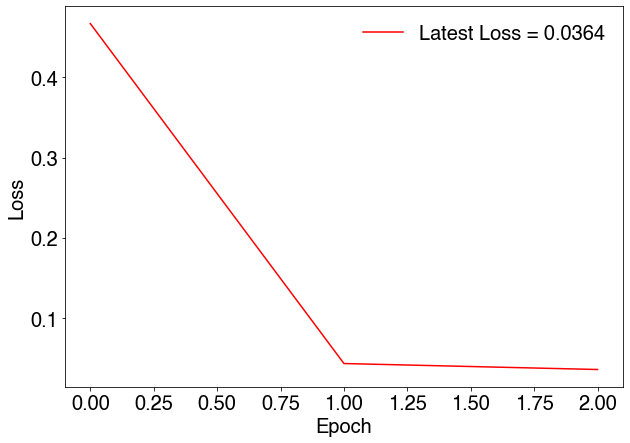

Current Epoch = 2
Latest Loss = 0.03641895434408924


KeyboardInterrupt: 

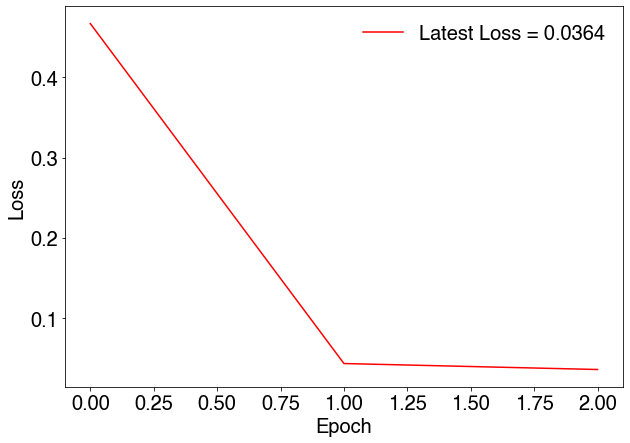

In [749]:
# Define dataset
torch_dataset = torch.utils.data.TensorDataset(X_scaled, g1_scaled)

optimizer = torch.optim.Adam(g1_net.parameters(), lr = 1e-4, amsgrad= True) # Initialize Adam optimizer
loss_func = torch.nn.SmoothL1Loss()  # this is for regression mean squared loss

BATCH_SIZE = 200 # Batch size
EPOCH      = 500   # No. of epochs

# Splitting dataset into batches
loader = torch.utils.data.DataLoader(dataset     = torch_dataset, 
                         batch_size  = BATCH_SIZE, 
                         shuffle     = True, 
                         num_workers = 0)

# my_images = []  # For saving into gif
fig, ax = plt.subplots(figsize=(10,7))

epoch_list = [] # Save epoch for plotting
loss_list  = [] # Save loss for plotting

# Start training
for epoch in range(EPOCH):
    epoch_list += [epoch]
    for step, (batch_x, batch_y) in enumerate(loader): # for each training step

        prediction = g1_net(batch_x.double())          # input x and predict based on x

        loss       = loss_func(prediction, batch_y) # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients

        if step == 1:
            # plot and show learning process
            plt.cla()
            loss_list += [loss.data.numpy()]
            plt.plot(epoch_list, loss_list, label = 'Latest Loss = %.4f' % loss.data.numpy(), color = 'r')
            plt.xlabel('Epoch', fontsize = 20)
            plt.ylabel('Loss', fontsize = 20)
            plt.xticks(fontsize = 20)
            plt.yticks(fontsize = 20)
            plt.legend(fontsize = 20, frameon= 0)
            
            display.clear_output(wait = True) #these two lines plots the data in real time
            display.display(fig)
            print('Current Epoch =', epoch)
            print('Latest Loss =', loss.data.numpy())

In [2982]:
# # Save neural network
# torch.save(g1_net, './NN_models/CS1_g1_combined')

# # Load pre-trained neural network
# g1_net = torch.load('./NN_models/CS1_g1_combined')
# g1_net.eval()

Sequential(
  (0): Linear(in_features=6, out_features=200, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=200, out_features=200, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=200, out_features=100, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=100, out_features=50, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=50, out_features=1, bias=True)
)

Very poor prediction of first transition [1.0, 150.0, 0, 240, u_L, u_Fn] --> cannot predict -ve values of g1

In [220]:
print('g1_net predictions of g1:',  (g1_net(X_scaled[0:200:12]).detach().numpy()*y_std_C[0])+y_mean_C[0]   )
print('Actual labels:',  g1_constraint[0:200:12]   )

g1_net predictions of g1: [[169.88598475]
 [192.16665927]
 [277.96121581]
 [168.94059048]
 [ 49.9956065 ]
 [ 19.36737399]
 [105.84107779]
 [339.76878869]
 [ 47.18078534]
 [281.01348606]
 [ 24.07480609]
 [109.42772014]
 [297.25347707]
 [ 37.70378133]
 [181.43995365]
 [163.2190903 ]
 [143.60078228]]
Actual labels: [[  77.73519622]
 [ 638.94362711]
 [ 176.46875385]
 [ 431.98459369]
 [ 401.34313084]
 [ 587.24721208]
 [ 338.53076033]
 [ 294.07330344]
 [-137.29324356]
 [ 278.98456649]
 [  17.84313246]
 [  12.3166078 ]
 [ 301.80490414]
 [ -22.61426158]
 [ 157.30346801]
 [ -50.66123331]
 [  62.18762976]]


### Training g2-net

In [753]:
g2_net = torch.nn.Sequential(
        torch.nn.Linear(6, 200, bias = True), # 6 input nodes (Cx, Cn, Cq, t_f - t, u_L, u_Fn)
        torch.nn.LeakyReLU(),                
        torch.nn.Linear(200, 200, bias = True), 
        torch.nn.LeakyReLU(),                
        torch.nn.Linear(200, 100, bias = True), 
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 50, bias = True), 
        torch.nn.LeakyReLU(),
        torch.nn.Linear(50, 1, bias = True), # 1 output node
    ).double()

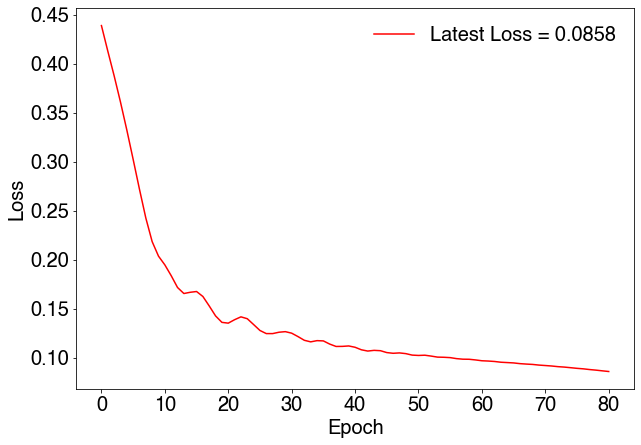

Current Epoch = 80
Latest Loss = 0.08576015739642467


KeyboardInterrupt: 

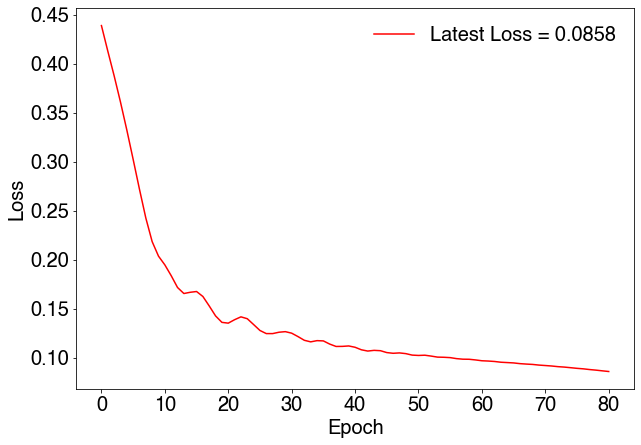

In [751]:
# for overfitting
# Define dataset
torch_dataset = torch.utils.data.TensorDataset(X_scaled, g2_scaled)

optimizer = torch.optim.Adam(g2_net.parameters(), lr = 1e-3, amsgrad= True) # Initialize Adam optimizer
loss_func = torch.nn.SmoothL1Loss()  # this is for regression mean squared loss


EPOCH      = 1000   # No. of epochs

# my_images = []  # For saving into gif
fig, ax = plt.subplots(figsize=(10,7))

epoch_list = [] # Save epoch for plotting
loss_list  = [] # Save loss for plotting

# Start training
for epoch in range(EPOCH):
    epoch_list += [epoch]
    

    prediction = g2_net(X_scaled)          # input x and predict based on x

    loss       = loss_func(prediction, g2_scaled) # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients


            # plot and show learning process
    plt.cla()
    loss_list += [loss.data.numpy()]
    plt.plot(epoch_list, loss_list, label = 'Latest Loss = %.4f' % loss.data.numpy(), color = 'r')
    plt.xlabel('Epoch', fontsize = 20)
    plt.ylabel('Loss', fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.legend(fontsize = 20, frameon= 0)
            
    display.clear_output(wait = True) #these two lines plots the data in real time
    display.display(fig)
    print('Current Epoch =', epoch)
    print('Latest Loss =', loss.data.numpy())

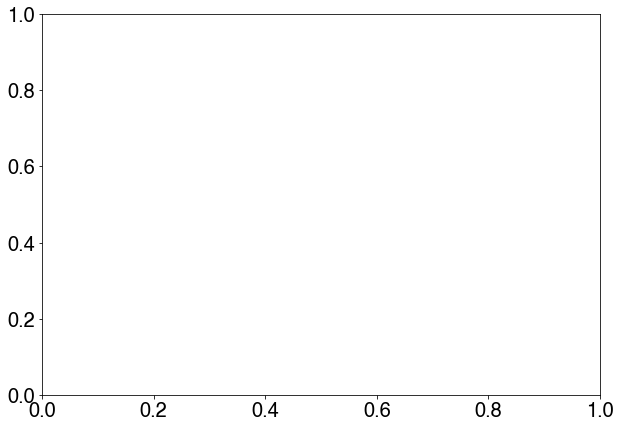

In [488]:
# Define dataset
torch_dataset = torch.utils.data.TensorDataset(X_scaled, g2_scaled)

optimizer = torch.optim.Adam(g2_net.parameters(), lr = 1e-4, amsgrad= True) # Initialize Adam optimizer
loss_func = torch.nn.SmoothL1Loss()  # this is for regression mean squared loss

BATCH_SIZE = 200 # Batch size
EPOCH      = 500   # No. of epochs

# Splitting dataset into batches
loader = torch.utils.data.DataLoader(dataset     = torch_dataset, 
                         batch_size  = BATCH_SIZE, 
                         shuffle     = True, 
                         num_workers = 0)

# my_images = []  # For saving into gif
fig, ax = plt.subplots(figsize=(10,7))

epoch_list = [] # Save epoch for plotting
loss_list  = [] # Save loss for plotting

# Start training
for epoch in range(EPOCH):
    epoch_list += [epoch]
    for step, (batch_x, batch_y) in enumerate(loader): # for each training step

        prediction = g2_net(batch_x.double())          # input x and predict based on x

        loss       = loss_func(prediction, batch_y) # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients

        if step == 1:
            # plot and show learning process
            plt.cla()
            loss_list += [loss.data.numpy()]
            plt.plot(epoch_list, loss_list, label = 'Latest Loss = %.4f' % loss.data.numpy(), color = 'r')
            plt.xlabel('Epoch', fontsize = 20)
            plt.ylabel('Loss', fontsize = 20)
            plt.xticks(fontsize = 20)
            plt.yticks(fontsize = 20)
            plt.legend(fontsize = 20, frameon= 0)
            
            display.clear_output(wait = True) #these two lines plots the data in real time
            display.display(fig)
            print('Current Epoch =', epoch)
            print('Latest Loss =', loss.data.numpy())

Poor prediction by g2_net in general (as shown by the high losses above)

In [228]:
print('g2_net predictions of g2:',  (g2_net(X_scaled[20:40]).detach().numpy()*y_std_C[1])+y_mean_C[1]   )
print('Actual labels:',  g2_constraint[20:40]   )

g2_net predictions of g2: [[ 0.00234046]
 [ 0.00488032]
 [ 0.002773  ]
 [ 0.00406091]
 [ 0.0047795 ]
 [ 0.00485463]
 [ 0.00445504]
 [ 0.0033243 ]
 [ 0.00295055]
 [ 0.00388676]
 [ 0.00386802]
 [ 0.00216321]
 [-0.00125155]
 [-0.00067009]
 [-0.00247181]
 [-0.00452562]
 [ 0.00319862]
 [ 0.00496048]
 [ 0.00425856]
 [ 0.00403404]]
Actual labels: [[ 0.00425832]
 [ 0.00425832]
 [ 0.00425832]
 [ 0.00425832]
 [-0.00551784]
 [-0.00551784]
 [-0.00551784]
 [-0.00551784]
 [-0.00551784]
 [-0.00551784]
 [-0.00551784]
 [-0.00551784]
 [-0.00551784]
 [-0.00551784]
 [-0.00551784]
 [-0.00551784]
 [ 0.00548473]
 [ 0.00548473]
 [ 0.00548473]
 [ 0.00548473]]


In [427]:
min(g2_net(X_scaled).detach().numpy()*y_std_C[1])+y_mean_C[1]

array([-0.01654878])

## Plotting state space and visualize violation of constraints

### Random **unconstrained** policy

In [236]:
# Generate data using random policy
plotting_state_data = []
for i in range(1000):
    episode = generate_random_episode(initial_state = [1.0,150.0,0,0]) # Generate 1 episode
    data = extract_data_from_episode(episode, discount_factor = 0.9)   # Extract datapoint from episode
    for j in data:
        j = j[:-1]
        plotting_state_data += j  # Add datapoints to training set
# plotting_state_data
plotting_state_data = pd.DataFrame(plotting_state_data)
plotting_state_data_g1_violated = plotting_state_data[plotting_state_data[1] - 800 > 0] # Conpath 1
plotting_state_data_g2_violated = plotting_state_data[plotting_state_data[2] - 0.011*plotting_state_data[0] > 0] # Conpath 2
plotting_state_data_g3_violated = plotting_state_data[(plotting_state_data[3] == 240.0) & (plotting_state_data[1] - 150 > 0)] # Terminal constraint

print('No. of states visited:',len(plotting_state_data))
print('No. of states where g1 violated:',len(plotting_state_data_g1_violated))
print('No. of states where g2 violated:',len(plotting_state_data_g2_violated))
print('No. of states where g3 violated:',len(plotting_state_data_g3_violated))

Cx_all = plotting_state_data[0]
Cn_all = plotting_state_data[1]
Cq_all = plotting_state_data[2]

Cx_g1 = plotting_state_data_g1_violated[0]
Cn_g1 = plotting_state_data_g1_violated[1]
Cq_g1 = plotting_state_data_g1_violated[2]

Cx_g2 = plotting_state_data_g2_violated[0]
Cn_g2 = plotting_state_data_g2_violated[1]
Cq_g2 = plotting_state_data_g2_violated[2]

Cx_g3 = plotting_state_data_g3_violated[0]
Cn_g3 = plotting_state_data_g3_violated[1]
Cq_g3 = plotting_state_data_g3_violated[2]

@interact(ns=(-90,90,0.1),ew=(-90,90,0.1))
def interact_poly(ns,ew):
    fig = plt.figure(figsize = (10,7))
    ax = plt.axes(projection='3d')

    # Data for a three-dimensional line
    ax.plot3D(Cx_all, Cn_all, Cq_all, 'g', label = 'no violation', linestyle = '', marker = 'o', markersize = 1)
    ax.plot3D(Cx_g1, Cn_g1, Cq_g1, 'r', label = 'g1', linestyle = '', marker = 'o', markersize = 1)
    ax.plot3D(Cx_g2, Cn_g2, Cq_g2, 'b', label = 'g2', linestyle = '', marker = 'o', markersize = 1)
    ax.plot3D(Cx_g3, Cn_g3, Cq_g3, 'black', label = 'g3', linestyle = '', marker = 'o', markersize = 1)
    plt.xlabel('$C_x$', labelpad=30)
    plt.ylabel('$C_n$', labelpad=50)
    ax.set_zlabel('$C_q$', fontsize=20, labelpad=20)
    plt.legend()
    plt.xticks(rotation=90)
    plt.yticks(rotation=90)
    plt.xlim(0,16)
    plt.ylim(0,2200)
    ax.set_zlim(0, 0.25)
    ax.view_init(ns,ew)
    plt.show()

No. of states visited: 13000
No. of states where g1 violated: 1639
No. of states where g2 violated: 909
No. of states where g3 violated: 191


interactive(children=(FloatSlider(value=0.0, description='ns', max=90.0, min=-90.0), FloatSlider(value=0.0, de…

### Random **g1-constrained** policy

In [2463]:
# Generate data using random policy
plotting_state_data = []
for i in range(1000):
    episode = generate_random_episode_constrained(initial_state = [1.0,150.0,0,0], g1_threshold = 0) # Generate 1 episode
    data = extract_data_from_episode(episode, discount_factor = 0.9)   # Extract datapoint from episode
    for j in data:
        j = j[:-1]
        plotting_state_data += j  # Add datapoints to training set
# plotting_state_data
plotting_state_data = pd.DataFrame(plotting_state_data)
plotting_state_data_g1_violated = plotting_state_data[plotting_state_data[1] - 800 > 0] # Conpath 1
plotting_state_data_g2_violated = plotting_state_data[plotting_state_data[2] - 0.011*plotting_state_data[0] > 0] # Conpath 2
plotting_state_data_g3_violated = plotting_state_data[(plotting_state_data[3] == 240.0) & (plotting_state_data[1] - 150 > 0)] # Terminal constraint

print('No. of states visited:',len(plotting_state_data))
print('No. of states where g1 violated:',len(plotting_state_data_g1_violated))
print('No. of states where g2 violated:',len(plotting_state_data_g2_violated))
print('No. of states where g3 violated:',len(plotting_state_data_g3_violated))

Cx_all = plotting_state_data[0]
Cn_all = plotting_state_data[1]
Cq_all = plotting_state_data[2]

Cx_g1 = plotting_state_data_g1_violated[0]
Cn_g1 = plotting_state_data_g1_violated[1]
Cq_g1 = plotting_state_data_g1_violated[2]

Cx_g2 = plotting_state_data_g2_violated[0]
Cn_g2 = plotting_state_data_g2_violated[1]
Cq_g2 = plotting_state_data_g2_violated[2]

Cx_g3 = plotting_state_data_g3_violated[0]
Cn_g3 = plotting_state_data_g3_violated[1]
Cq_g3 = plotting_state_data_g3_violated[2]

@interact(ns=(-90,90,0.1),ew=(-90,90,0.1))
def interact_poly(ns,ew):
    fig = plt.figure(figsize = (10,7))
    ax = plt.axes(projection='3d')

    # Data for a three-dimensional line
    ax.plot3D(Cx_all, Cn_all, Cq_all, 'g', label = 'no violation', linestyle = '', marker = 'o', markersize = 1)
    ax.plot3D(Cx_g1, Cn_g1, Cq_g1, 'r', label = 'g1', linestyle = '', marker = 'o', markersize = 1)
    ax.plot3D(Cx_g2, Cn_g2, Cq_g2, 'b', label = 'g2', linestyle = '', marker = 'o', markersize = 1)
    ax.plot3D(Cx_g3, Cn_g3, Cq_g3, 'black', label = 'g3', linestyle = '', marker = 'o', markersize = 1)
    plt.title('States visited by random constrained policy')
    plt.xlabel('Cx', labelpad=20)
    plt.ylabel('Cn', labelpad=20)
    plt.legend()
    # plt.zlabel('Cq')
    ax.view_init(ns,ew)
    plt.show()

No. of states visited: 1300
No. of states where g1 violated: 0
No. of states where g2 violated: 44
No. of states where g3 violated: 36


interactive(children=(FloatSlider(value=0.0, description='ns', max=90.0, min=-90.0), FloatSlider(value=0.0, de…

### Trained **unconstrained** policy

In [2746]:
# Generate data using random policy
plotting_state_data = []
for i in range(1000):
    episode = generate_episode_with_NN(GA_optimize, [1.0, 150.0, 0, 0], epsilon = 0) # Generate 1 episode
    data = extract_data_from_episode(episode, discount_factor = 0.9)   # Extract datapoint from episode
    for j in data:
        j = j[:-1]
        plotting_state_data += j  # Add datapoints to training set
# plotting_state_data
plotting_state_data = pd.DataFrame(plotting_state_data)
plotting_state_data_g1_violated = plotting_state_data[plotting_state_data[1] - 800 > 0] # Conpath 1
plotting_state_data_g2_violated = plotting_state_data[plotting_state_data[2] - 0.011*plotting_state_data[0] > 0] # Conpath 2
plotting_state_data_g3_violated = plotting_state_data[(plotting_state_data[3] == 240.0) & (plotting_state_data[1] - 150 > 0)] # Terminal constraint

print('No. of states visited:',len(plotting_state_data))
print('No. of states where g1 violated:',len(plotting_state_data_g1_violated))
print('No. of states where g2 violated:',len(plotting_state_data_g2_violated))
print('No. of states where g3 violated:',len(plotting_state_data_g3_violated))

Cx_all = plotting_state_data[0]
Cn_all = plotting_state_data[1]
Cq_all = plotting_state_data[2]

Cx_g1 = plotting_state_data_g1_violated[0]
Cn_g1 = plotting_state_data_g1_violated[1]
Cq_g1 = plotting_state_data_g1_violated[2]

Cx_g2 = plotting_state_data_g2_violated[0]
Cn_g2 = plotting_state_data_g2_violated[1]
Cq_g2 = plotting_state_data_g2_violated[2]

Cx_g3 = plotting_state_data_g3_violated[0]
Cn_g3 = plotting_state_data_g3_violated[1]
Cq_g3 = plotting_state_data_g3_violated[2]

@interact(ns=(-90,90,0.1),ew=(-90,90,0.1))
def interact_poly(ns,ew):
    fig = plt.figure(figsize = (10,7))
    ax = plt.axes(projection='3d')

    # Data for a three-dimensional line
    ax.plot3D(Cx_all, Cn_all, Cq_all, 'g', label = 'no violation', linestyle = '', marker = 'o', markersize = 1)
    ax.plot3D(Cx_g1, Cn_g1, Cq_g1, 'r', label = 'g1', linestyle = '', marker = 'o', markersize = 1)
    ax.plot3D(Cx_g2, Cn_g2, Cq_g2, 'b', label = 'g2', linestyle = '', marker = 'o', markersize = 1)
    ax.plot3D(Cx_g3, Cn_g3, Cq_g3, 'black', label = 'g3', linestyle = '', marker = 'o', markersize = 1)
    plt.xlabel('$C_x$', labelpad=20)
    plt.ylabel('$C_n$', labelpad=20)
    ax.set_zlabel('$C_q$', fontsize=20, labelpad=20)
    plt.legend()
    # plt.zlabel('Cq')
    ax.view_init(ns,ew)
    plt.show()

No. of states visited: 13000
No. of states where g1 violated: 5004
No. of states where g2 violated: 1000
No. of states where g3 violated: 0


interactive(children=(FloatSlider(value=0.0, description='ns', max=90.0, min=-90.0), FloatSlider(value=0.0, de…

### Trained **g1-constrained** policy

In [660]:
# Generate data using random policy
plotting_state_data = []
for i in range(1):
    episode = generate_episode_with_NN(GA_optimize_constrained, [1.0, 150.0, 0, 0], epsilon = 0,
                                      g1_threshold = g1_threshold,
                                      g2_threshold = g2_threshold) # Generate 1 episode
    data = extract_data_from_episode(episode, discount_factor = 0.9)   # Extract datapoint from episode
    for j in data:
        j = j[:-1]
        plotting_state_data += j  # Add datapoints to training set
# plotting_state_data
plotting_state_data = pd.DataFrame(plotting_state_data)
plotting_state_data_g1_violated = plotting_state_data[plotting_state_data[1] - 800 > 0] # Conpath 1
plotting_state_data_g2_violated = plotting_state_data[plotting_state_data[2] - 0.011*plotting_state_data[0] > 0] # Conpath 2
plotting_state_data_g3_violated = plotting_state_data[(plotting_state_data[3] == 240.0) & (plotting_state_data[1] - 150 > 0)] # Terminal constraint

print('No. of states visited:',len(plotting_state_data))
print('No. of states where g1 violated:',len(plotting_state_data_g1_violated))
print('No. of states where g2 violated:',len(plotting_state_data_g2_violated))
print('No. of states where g3 violated:',len(plotting_state_data_g3_violated))

Cx_all = plotting_state_data[0]
Cn_all = plotting_state_data[1]
Cq_all = plotting_state_data[2]

Cx_g1 = plotting_state_data_g1_violated[0]
Cn_g1 = plotting_state_data_g1_violated[1]
Cq_g1 = plotting_state_data_g1_violated[2]

Cx_g2 = plotting_state_data_g2_violated[0]
Cn_g2 = plotting_state_data_g2_violated[1]
Cq_g2 = plotting_state_data_g2_violated[2]

Cx_g3 = plotting_state_data_g3_violated[0]
Cn_g3 = plotting_state_data_g3_violated[1]
Cq_g3 = plotting_state_data_g3_violated[2]

@interact(ns=(-90,90,0.1),ew=(-90,90,0.1))
def interact_poly(ns,ew):
    fig = plt.figure(figsize = (10,7))
    ax = plt.axes(projection='3d')

    # Data for a three-dimensional line
    ax.plot3D(Cx_all, Cn_all, Cq_all, 'g', label = 'no violation', linestyle = '', marker = 'o', markersize = 1)
    ax.plot3D(Cx_g1, Cn_g1, Cq_g1, 'r', label = 'g1', linestyle = '', marker = 'o', markersize = 1)
    ax.plot3D(Cx_g2, Cn_g2, Cq_g2, 'b', label = 'g2', linestyle = '', marker = 'o', markersize = 1)
    ax.plot3D(Cx_g3, Cn_g3, Cq_g3, 'black', label = 'g3', linestyle = '', marker = 'o', markersize = 1)
    plt.xlabel('$C_x$', labelpad=20)
    plt.ylabel('$C_n$', labelpad=20)
    ax.set_zlabel('$C_q$', fontsize=20, labelpad=20)
    plt.legend()
    # plt.zlabel('Cq')
    ax.view_init(ns,ew)
    plt.show()

KeyboardInterrupt: 

### Method 2: Training Q-network and C-network simultaneously

In [20]:
# Initialize Q-network
Q_net = torch.nn.Sequential(
        torch.nn.Linear(6,   200, bias = True), # 6 input nodes
        torch.nn.LeakyReLU(),    # apply ReLU activation function
        torch.nn.Linear(200, 200, bias = True), 
        torch.nn.LeakyReLU(),    # apply ReLU activation function
        torch.nn.Linear(200,   1, bias = True), # 1 output node
    ).double()

# Initialize g1_network
g1_net = torch.nn.Sequential(
        torch.nn.Linear(6, 200, bias = True), # 4 input nodes (Cx, Cn, Cq, t_f - t, u_L, u_Fn)
        torch.nn.LeakyReLU(),                
        torch.nn.Linear(200, 200, bias = True), 
        torch.nn.LeakyReLU(),                
        torch.nn.Linear(200, 100, bias = True), 
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 50, bias = True), 
        torch.nn.LeakyReLU(),
        torch.nn.Linear(50, 1, bias = True), # 1 output node
    ).double()

# Initialize g2_network
g2_net = torch.nn.Sequential(
        torch.nn.Linear(6, 200, bias = True), # 4 input nodes (Cx, Cn, Cq, t_f - t, u_L, u_Fn)
        torch.nn.LeakyReLU(),                
        torch.nn.Linear(200, 200, bias = True), 
        torch.nn.LeakyReLU(),                
        torch.nn.Linear(200, 100, bias = True), 
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 50, bias = True), 
        torch.nn.LeakyReLU(),
        torch.nn.Linear(50, 1, bias = True), # 1 output node
    ).double()

In [16]:
# # ========== 1) GENERATING INITIAL BATCH OF SAMPLES FOR REPLAY BUFFER ==========
# epsilon       = 0.99 # Initial epsilon
# g1_threshold  = 500  # Initial g1_threshold
# g2_threshold  = 0.050  # Initial g2_threshold
# replay_buffer = collections.deque(maxlen = 3000) # Max capacity of 3k
# g1_buffer     = collections.deque(maxlen = 30000) # Max capacity of 30k
# g2_buffer     = collections.deque(maxlen = 30000) # Max capacity of 30k

# for i in range(100): # Generate 100 episodes
#     episode       = generate_episode_with_NN(NN = GA_optimize_constrained,
#                                              initial_state = [1.0, 150.0, 0, 0],
#                                              epsilon = epsilon, 
#                                              g1_threshold = g1_threshold,
#                                              g2_threshold = g2_threshold)
#     episode_copy = copy.deepcopy(episode) # Copied to ensure same episodes are fed into Q and C
#     episode_copy2 = copy.deepcopy(episode) # Copied to ensure same episodes are fed into Q and C
#     replay_buffer = update_replay_buffer(replay_buffer, episode, discount_factor = 0.9) # Add to replay buffer
#     g1_buffer     = update_g1_buffer(g1_buffer, episode_copy) # Add to g1 buffer
#     g2_buffer     = update_g2_buffer(g2_buffer, episode_copy2) # Add to g2 buffer
# print('Initial size of replay buffer:', len(replay_buffer))
# print('Initial size of g1 buffer:', len(g1_buffer))
# print('Initial size of g2 buffer:', len(g2_buffer))

# # ================================= 2) TRAINING THE Q-NETWORK =================================
# g1_threshold_list  = []
# g2_threshold_list  = []
# epsilon_list       = []
# score_list         = [] # For plotting score of policy visited over time
# iteration_list     = []
# policy_mean_list   = [] # For plotting evolution of policy visited over time
# policy_std_list    = [] # For plotting evolution of policy visited over time
# training_loss_list = [] # For plotting loss of NN (after 20 epochs) over time
# episode_bank       = [] # A list of list of lists - Tertiary list  -> Iterations
#                         #                         - Secondary list -> Episodes
#                         #                         - Primary list   -> Steps
#                         #                         For plotting evolution of states visited over time            

# for iteration in range(1000):
#     # Save thresholds and epsilons
#     g1_threshold_list  += [g1_threshold]
#     g2_threshold_list  += [g2_threshold]
#     epsilon_list       += [epsilon]
    
#     # SCORE EXISTING POLICY
#     print('=========== TRAINING ITERATION %.0f ===========' % iteration)
#     print('Current epsilon = ', epsilon)
#     print('Current g1_threshold = ', g1_threshold)
#     print('Current g2_threshold = ', g2_threshold)
#     current_score = score_NN_policy(GA_optimize_constrained, 
#                                     initial_state = [1.0, 150.0, 0, 0], 
#                                     num_iterations = 3, 
#                                     get_control = False, 
#                                     g1_threshold = g1_threshold,
#                                     g2_threshold = g2_threshold)
#     print('AVERAGE SCORE = ', current_score)
#     print('')
    
#     # GENERATE EPISODES & ADD TO REPLAY BUFFER
#     for j in range(50):
#         episode       = generate_episode_with_NN(NN = GA_optimize_constrained,
#                                              initial_state = [1.0, 150.0, 0, 0],
#                                              epsilon = epsilon, 
#                                              g1_threshold = g1_threshold,
#                                              g2_threshold = g2_threshold)
#         episode_copy = copy.deepcopy(episode) # Copied to ensure same episodes are fed into Q and C
#         episode_copy2 = copy.deepcopy(episode)
#         replay_buffer = update_replay_buffer(replay_buffer, episode, discount_factor = 0.9) # Add to replay buffer
#         g1_buffer     = update_g1_buffer(g1_buffer, episode_copy) # Add to g1 buffer
#         g2_buffer     = update_g2_buffer(g2_buffer, episode_copy2) # Add to g2 buffer
    
#     # === TRAIN Q_NETWORK NETWORK ===
#     combined_inputs_Q  = [] # List of lists to be converted into input tensor
#     combined_targets_Q = [] # List to be converted into target tensor
#     samples_Q          = random.sample(replay_buffer, 100) # Draw random samples from replay buffer
    
#     for inputs, target in samples_Q:
#         combined_inputs_Q  += [inputs]
#         combined_targets_Q += [[target]]
#     combined_inputs_Q  = torch.tensor(combined_inputs_Q).double()  # Convert list to tensor
#     combined_targets_Q = torch.tensor(combined_targets_Q).double() # Convert list to tensor

#     Q_optimizer = torch.optim.Adam(Q_net.parameters(), lr=1e-3) # Initialize Adam optimizer
#     loss_func = torch.nn.SmoothL1Loss()                     # Define loss function
    
#     for epoch in range(20):
#         prediction = Q_net(combined_inputs_Q)                    # Input x and predict based on x
#         Q_loss       = loss_func(prediction, combined_targets_Q) # Must be (1. nn output, 2. target)

#         Q_optimizer.zero_grad()   # Clear gradients for next train
#         Q_loss.backward()         # Backpropagation, compute gradients
#         Q_optimizer.step()        # Apply gradients
# #         print('Epoch = ', epoch, 'Loss = %.4f' % Q_loss.data.numpy())
    
#     # === TRAIN g1_NETWORK ===
#     combined_inputs_g1  = [] # List of lists to be converted into input tensor
#     combined_targets_g1 = [] # List to be converted into target tensor
#     samples_g1          = random.sample(g1_buffer, 500) # Draw random samples from replay buffer
    
#     for inputs, target in samples_g1:
#         combined_inputs_g1  += [inputs]
#         combined_targets_g1 += [[target]]

#     combined_inputs_g1  = torch.tensor(combined_inputs_g1).double()  # Convert list to tensor
#     combined_targets_g1 = torch.tensor(combined_targets_g1).double() # Convert list to tensor

#     g1_optimizer = torch.optim.Adam(g1_net.parameters(), lr=1e-4) # Initialize Adam optimizer
#     loss_func = torch.nn.SmoothL1Loss()                     # Define loss function
    
#     for epoch in range(10):
#         prediction = g1_net(combined_inputs_g1)                    # Input x and predict based on x
#         g1_loss    = loss_func(prediction, combined_targets_g1) # Must be (1. nn output, 2. target)

#         g1_optimizer.zero_grad()   # Clear gradients for next train
#         g1_loss.backward()         # Backpropagation, compute gradients
#         g1_optimizer.step()        # Apply gradients
# #         print('Epoch = ', epoch, 'Loss = %.4f' % g1_loss.data.numpy())
    
#     # === TRAIN g2_NETWORK ===
#     combined_inputs_g2  = [] # List of lists to be converted into input tensor
#     combined_targets_g2 = [] # List to be converted into target tensor
#     samples_g2          = random.sample(g2_buffer, 1000) # Draw random samples from replay buffer
    
#     for inputs, target in samples_g2:
#         combined_inputs_g2  += [inputs]
#         combined_targets_g2 += [[target]]

#     combined_inputs_g2  = torch.tensor(combined_inputs_g2).double()  # Convert list to tensor
#     combined_targets_g2 = torch.tensor(combined_targets_g2).double() # Convert list to tensor

#     g2_optimizer = torch.optim.Adam(g2_net.parameters(), lr=1e-4) # Initialize Adam optimizer
#     loss_func = torch.nn.SmoothL1Loss()                     # Define loss function
    
#     for epoch in range(10):
#         prediction = g2_net(combined_inputs_g2)                    # Input x and predict based on x
#         g2_loss    = loss_func(prediction, combined_targets_g2) # Must be (1. nn output, 2. target)

#         g2_optimizer.zero_grad()   # Clear gradients for next train
#         g2_loss.backward()         # Backpropagation, compute gradients
#         g2_optimizer.step()        # Apply gradients
# #         print('Epoch = ', epoch, 'Loss = %.4f' % g2_loss.data.numpy())
    
#     score_list         += [current_score] # Store score for each iteration
#     training_loss_list += [Q_loss.data.numpy()]                                # Store training loss after 20 epochs for each iteration
#     iteration_list     += [iteration]                                        # Store iteration
    
# #     # INVESTIGATING EVOLUTION OF POLICY OVER TRAINING ITERATIONS
# #     if iteration in np.arange(0,5000,10): # Every 10 iterations
# #         list_of_policies  = score_NN_policy(GA_optimize, [1.0, 150.0, 0, 0], num_iterations = 100, get_control = True)[1] # add policies
# #         policy_mean       = np.mean(list_of_policies, axis = 0) # Calculate mean of policies
# #         policy_std        = np.std(list_of_policies, axis = 0)  # Calculate std of policies
# #         policy_mean_list += [policy_mean] # Save mean policy for plotting
# #         policy_std_list  += [policy_std]  # Save std of policy for plotting
    
#     # INVESTIGATING EVOLUTION OF STATES VISITED OVER TRAINING ITERATIONS
#     if iteration in np.arange(0, 5000, 10): # Every 10 iterations
#         pool_of_episodes = [] # A *list of lists* of episodes
#         for i in range(10):   # Generate 10 sample episodes and store them
#             pool_of_episodes += [generate_episode_with_NN(NN = GA_optimize_constrained,
#                                              initial_state = [1.0, 150.0, 0, 0],
#                                              epsilon = 0, 
#                                              g1_threshold = g1_threshold,
#                                              g2_threshold = g2_threshold)]
#         episode_bank         += [pool_of_episodes]
    
#     epsilon      *= 0.99 # Decay epsilon
#     g1_threshold *= 0.995 # Decay threshold
#     g2_threshold *= 0.995 # Decay threshold

Initial size of replay buffer: 1300
Initial size of g1 buffer: 1200
Initial size of g2 buffer: 1200
=========== TRAINING ITERATION 0 ===========
Current epsilon =  0.99
Current g1_threshold =  500
Current g2_threshold =  0.05
AVERAGE SCORE =  0.09213803296989986

=========== TRAINING ITERATION 1 ===========
Current epsilon =  0.9801
Current g1_threshold =  497.5
Current g2_threshold =  0.04975
AVERAGE SCORE =  0.19551749611301084

=========== TRAINING ITERATION 2 ===========
Current epsilon =  0.9702989999999999
Current g1_threshold =  495.0125
Current g2_threshold =  0.049501250000000004
AVERAGE SCORE =  0.14398440726566167

=========== TRAINING ITERATION 3 ===========
Current epsilon =  0.96059601
Current g1_threshold =  492.5374375
Current g2_threshold =  0.04925374375
AVERAGE SCORE =  0.17733718971663892

=========== TRAINING ITERATION 4 ===========
Current epsilon =  0.9509900498999999
Current g1_threshold =  490.0747503125
Current g2_threshold =  0.049007475031250004
AVERAGE SCOR

KeyboardInterrupt: 

In [74]:
# # SMALLER NUMBER OF EPISODES AND SMALLER BUFFERS

# # ========== 1) GENERATING INITIAL BATCH OF SAMPLES FOR REPLAY BUFFER ==========
# epsilon       = 0.99 # Initial epsilon
# g1_threshold  = 500  # Initial g1_threshold
# g2_threshold  = 0.050  # Initial g2_threshold
# replay_buffer = collections.deque(maxlen = 3000) # Max capacity of 3k
# g1_buffer     = collections.deque(maxlen = 30000) # Max capacity of 30k
# g2_buffer     = collections.deque(maxlen = 30000) # Max capacity of 30k

# for i in range(100): # Generate 100 episodes
#     episode       = generate_episode_with_NN(NN = GA_optimize_constrained,
#                                              initial_state = [1.0, 150.0, 0, 0],
#                                              epsilon = epsilon, 
#                                              g1_threshold = g1_threshold,
#                                              g2_threshold = g2_threshold)
#     episode_copy  = copy.deepcopy(episode) # Copied to ensure same episodes are fed into Q and C
#     episode_copy2 = copy.deepcopy(episode) # Copied to ensure same episodes are fed into Q and C
#     replay_buffer = update_replay_buffer(replay_buffer, episode, discount_factor = 0.9) # Add to replay buffer
#     g1_buffer     = update_g1_buffer(g1_buffer, episode_copy) # Add to g1 buffer
#     g2_buffer     = update_g2_buffer(g2_buffer, episode_copy2) # Add to g2 buffer
# print('Initial size of replay buffer:', len(replay_buffer))
# print('Initial size of g1 buffer:', len(g1_buffer))
# print('Initial size of g2 buffer:', len(g2_buffer))

# # ================================= 2) TRAINING THE Q-NETWORK =================================
# g1_threshold_list  = []
# g2_threshold_list  = []
# epsilon_list       = []
# score_list         = [] # For plotting score of policy visited over time
# iteration_list     = []
# policy_mean_list   = [] # For plotting evolution of policy visited over time
# policy_std_list    = [] # For plotting evolution of policy visited over time
# training_loss_list = [] # For plotting loss of NN (after 20 epochs) over time
# episode_bank       = [] # A list of list of lists - Tertiary list  -> Iterations
#                         #                         - Secondary list -> Episodes
#                         #                         - Primary list   -> Steps
#                         #                         For plotting evolution of states visited over time            


for iteration in range(2000):
    # Save thresholds and epsilons
    g1_threshold_list  += [g1_threshold]
    g2_threshold_list  += [g2_threshold]
    epsilon_list       += [epsilon]
    
    # SCORE EXISTING POLICY
    print('=========== TRAINING ITERATION %.0f ===========' % iteration)
    print('Current epsilon = ', epsilon)
    print('Current g1_threshold = ', g1_threshold)
    print('Current g2_threshold = ', g2_threshold)
    current_score = score_NN_policy(GA_optimize_constrained, 
                                    initial_state = [1.0, 150.0, 0, 0], 
                                    num_iterations = 3, 
                                    get_control = False, 
                                    g1_threshold = g1_threshold,
                                    g2_threshold = g2_threshold)
    print('AVERAGE SCORE = ', current_score)
    print('')
    
    # GENERATE EPISODES & ADD TO REPLAY BUFFER
    for j in range(1):
        episode      = generate_episode_with_NN(NN = GA_optimize_constrained,
                                             initial_state = [1.0, 150.0, 0, 0],
                                             epsilon = epsilon, 
                                             g1_threshold = g1_threshold,
                                             g2_threshold = g2_threshold)
        episode_copy  = copy.deepcopy(episode) # Copied to ensure same episodes are fed into Q and C
        episode_copy2 = copy.deepcopy(episode)
        replay_buffer = update_replay_buffer(replay_buffer, episode, discount_factor = 0.9) # Add to replay buffer
        g1_buffer     = update_g1_buffer(g1_buffer, episode_copy) # Add to g1 buffer
        g2_buffer     = update_g2_buffer(g2_buffer, episode_copy2) # Add to g2 buffer
        if j in np.arange(0, 100, 10):
            print('%.0f th episode generated' % j)
            
    # === TRAIN Q_NETWORK NETWORK ===
    combined_inputs_Q  = [] # List of lists to be converted into input tensor
    combined_targets_Q = [] # List to be converted into target tensor
    samples_Q          = random.sample(replay_buffer, 100) # Draw random samples from replay buffer
    
    for inputs, target in samples_Q:
        combined_inputs_Q  += [inputs]
        combined_targets_Q += [[target]]
    combined_inputs_Q  = torch.tensor(combined_inputs_Q).double()  # Convert list to tensor
    combined_targets_Q = torch.tensor(combined_targets_Q).double() # Convert list to tensor

    Q_optimizer = torch.optim.Adam(Q_net.parameters(), lr=1e-3) # Initialize Adam optimizer
    loss_func = torch.nn.SmoothL1Loss()                     # Define loss function
    
    for epoch in range(20):
        prediction = Q_net(combined_inputs_Q)                    # Input x and predict based on x
        Q_loss     = loss_func(prediction, combined_targets_Q) # Must be (1. nn output, 2. target)

        Q_optimizer.zero_grad()   # Clear gradients for next train
        Q_loss.backward()         # Backpropagation, compute gradients
        Q_optimizer.step()        # Apply gradients
#         print('Epoch = ', epoch, 'Loss = %.4f' % Q_loss.data.numpy())
    print('Q-network trained')
    # === TRAIN g1_NETWORK ===
    combined_inputs_g1  = [] # List of lists to be converted into input tensor
    combined_targets_g1 = [] # List to be converted into target tensor
    samples_g1          = random.sample(g1_buffer, 500) # Draw random samples from replay buffer
    
    for inputs, target in samples_g1:
        combined_inputs_g1  += [inputs]
        combined_targets_g1 += [[target]]

    combined_inputs_g1  = torch.tensor(combined_inputs_g1).double()  # Convert list to tensor
    combined_targets_g1 = torch.tensor(combined_targets_g1).double() # Convert list to tensor

    g1_optimizer = torch.optim.Adam(g1_net.parameters(), lr=1e-4) # Initialize Adam optimizer
    loss_func = torch.nn.SmoothL1Loss()                     # Define loss function
    
    for epoch in range(10):
        prediction = g1_net(combined_inputs_g1)                    # Input x and predict based on x
        g1_loss    = loss_func(prediction, combined_targets_g1) # Must be (1. nn output, 2. target)

        g1_optimizer.zero_grad()   # Clear gradients for next train
        g1_loss.backward()         # Backpropagation, compute gradients
        g1_optimizer.step()        # Apply gradients
#         print('Epoch = ', epoch, 'Loss = %.4f' % g1_loss.data.numpy())
    print('g1-network trained')
    # === TRAIN g2_NETWORK ===
    combined_inputs_g2  = [] # List of lists to be converted into input tensor
    combined_targets_g2 = [] # List to be converted into target tensor
    samples_g2          = random.sample(g2_buffer, 1000) # Draw random samples from replay buffer
    
    for inputs, target in samples_g2:
        combined_inputs_g2  += [inputs]
        combined_targets_g2 += [[target]]

    combined_inputs_g2  = torch.tensor(combined_inputs_g2).double()  # Convert list to tensor
    combined_targets_g2 = torch.tensor(combined_targets_g2).double() # Convert list to tensor

    g2_optimizer = torch.optim.Adam(g2_net.parameters(), lr=1e-3) # Initialize Adam optimizer
    loss_func = torch.nn.SmoothL1Loss()                     # Define loss function
    
    for epoch in range(100):
        prediction = g2_net(combined_inputs_g2)                    # Input x and predict based on x
        g2_loss    = loss_func(prediction, combined_targets_g2) # Must be (1. nn output, 2. target)

        g2_optimizer.zero_grad()   # Clear gradients for next train
        g2_loss.backward()         # Backpropagation, compute gradients
        g2_optimizer.step()        # Apply gradients
#         print('Epoch = ', epoch, 'Loss = %.4f' % g2_loss.data.numpy())
    print('g2-network trained')
    score_list         += [current_score] # Store score for each iteration
    training_loss_list += [Q_loss.data.numpy()]                                # Store training loss after 20 epochs for each iteration
    iteration_list     += [iteration]                                        # Store iteration
    
#     # INVESTIGATING EVOLUTION OF POLICY OVER TRAINING ITERATIONS
#     if iteration in np.arange(0,5000,10): # Every 10 iterations
#         list_of_policies  = score_NN_policy(GA_optimize, [1.0, 150.0, 0, 0], num_iterations = 100, get_control = True)[1] # add policies
#         policy_mean       = np.mean(list_of_policies, axis = 0) # Calculate mean of policies
#         policy_std        = np.std(list_of_policies, axis = 0)  # Calculate std of policies
#         policy_mean_list += [policy_mean] # Save mean policy for plotting
#         policy_std_list  += [policy_std]  # Save std of policy for plotting
    
    # INVESTIGATING EVOLUTION OF STATES VISITED OVER TRAINING ITERATIONS
    if iteration in np.arange(0, 5000, 10): # Every 10 iterations
        pool_of_episodes = [] # A *list of lists* of episodes
        for i in range(3):   # Generate 10 sample episodes and store them
            pool_of_episodes += [generate_episode_with_NN(NN = GA_optimize_constrained,
                                             initial_state = [1.0, 150.0, 0, 0],
                                             epsilon = 0, 
                                             g1_threshold = g1_threshold,
                                             g2_threshold = g2_threshold)]
        episode_bank         += [pool_of_episodes]
    
    epsilon      *= 0.99 # Decay epsilon
    g1_threshold *= 0.995 # Decay threshold
    g2_threshold *= 0.995 # Decay threshold

=========== TRAINING ITERATION 0 ===========
Current epsilon =  0.00888262772170544
Current g1_threshold =  47.642536358841625
Current g2_threshold =  0.004764253635884175
AVERAGE SCORE =  0.11935939530675894



KeyboardInterrupt: 

In [1013]:
# Comparing predictions with labels
((g2_net(X_scaled).detach().numpy() * y_std_C[1]) + y_mean_C[1])[0:24], g2_constraint[0:24]

(array([[-0.05225748],
        [-0.00972299],
        [-0.0094365 ],
        [-0.01241317],
        [-0.01696398],
        [-0.0184923 ],
        [-0.02081322],
        [-0.01475475],
        [-0.01282484],
        [-0.01280205],
        [-0.00550325],
        [-0.00256683],
        [-0.0116937 ],
        [-0.01288833],
        [-0.01632179],
        [-0.02104021],
        [-0.02647762],
        [-0.03475114],
        [-0.03487598],
        [-0.02892553],
        [-0.02079804],
        [-0.01540157],
        [-0.01049621],
        [-0.0021311 ]]),
 array([[-9.80949327e-03],
        [-9.44030895e-03],
        [-1.06243861e-02],
        [-1.35505666e-02],
        [-1.76561267e-02],
        [-1.86558360e-02],
        [-1.72434621e-02],
        [-1.46167185e-02],
        [-1.34622536e-02],
        [-8.87302538e-03],
        [-4.39408644e-03],
        [-6.04206763e-05],
        [-1.16927411e-02],
        [-1.28886713e-02],
        [-1.63008188e-02],
        [-2.10016819e-02],
        [-2.65

In [251]:
score_NN_policy(GA_optimize_constrained, 
                                    initial_state = [1.0, 150.0, 0, 0], 
                                    num_iterations = 1, 
                                    get_control = False, 
                                    g1_threshold = g1_threshold,
                                    g2_threshold = g2_threshold)

0.17520202352422515

In [252]:
episode = generate_episode_with_NN(GA_optimize_constrained, [1.0, 150.0, 0, 0], epsilon = 0, 
                                   g1_threshold = g1_threshold,
                                   g2_threshold = g2_threshold)
episode

[[[1.0, 150.0, 0, 0], [274.95244573153707, 39.53175230096947], 0],
 [[1.2799225584246305, 788.1439632918439, 0.0024542664429021963, 20.0],
  [282.6629287130928, 20.873411571887534],
  0],
 [[1.777048236417022, 939.5560676570661, 0.005750670359304678, 40.0],
  [300.0406494909897, 19.082394271640748],
  0],
 [[2.489549972626005, 940.431109712537, 0.010291660814128497, 60.0],
  [295.62746222760666, 23.927476650101333],
  0],
 [[3.4797586252727286, 889.5793521146206, 0.016653085302421208, 80.0],
  [335.002234578029, 37.48075696281251],
  0],
 [[4.8458257179702375, 908.412407714274, 0.02526714213625314, 100.0],
  [341.62111777023756, 39.812992000481586],
  0],
 [[6.673856046116832, 724.7061452865612, 0.037130425500474566, 120.0],
  [359.49690815401675, 37.166933003449834],
  0],
 [[8.704789469478232, 365.78962919523553, 0.05268752115704601, 140.0],
  [351.138222406155, 32.34261288552814],
  0],
 [[10.221245587523539, 151.50602474033093, 0.07111126835501469, 160.0],
  [264.41328093517365, 39

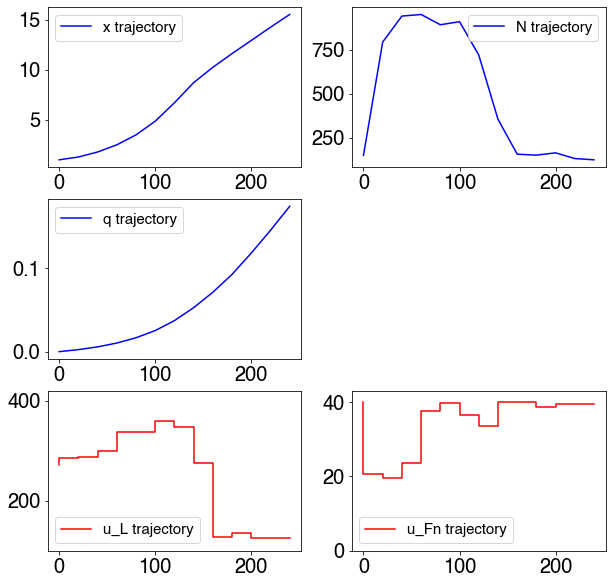

Score: 0.17469595677417296


In [234]:
plot_episode(episode)

In [1048]:
# Save neural network
# torch.save(Q_net, './NN_models/CS1_Q_net_g1_constrained')
# # Save neural network
# torch.save(g1_net, './NN_models/CS1_g1_net_g1_constrained')
# Save neural network
# torch.save(g2_net, './NN_models/CS1_g2_net_1400_ep')


# # Load pre-trained neural network
# Q_net = torch.load('./NN_models/CS1_Q_net_g1_constrained')
# Q_net.eval()
# # Load pre-trained neural network
# g1_net = torch.load('./NN_models/CS1_g1_net_g1_constrained')
# g1_net.eval()
# # Load pre-trained neural network
# g2_net = torch.load('./NN_models/CS1_g2_net_1400_ep')
# g2_net.eval()

Sequential(
  (0): Linear(in_features=6, out_features=200, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=200, out_features=200, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=200, out_features=100, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=100, out_features=50, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=50, out_features=1, bias=True)
)

## Plot objective score and Q-network loss

No handles with labels found to put in legend.


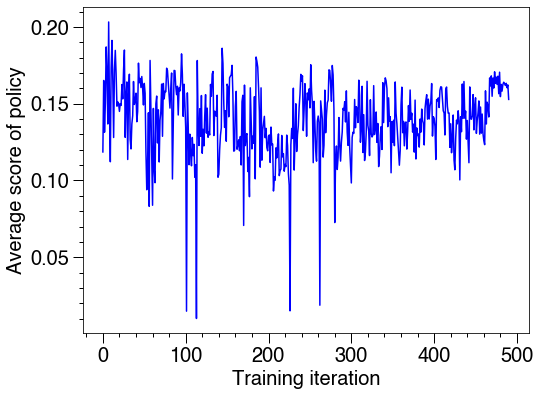

No handles with labels found to put in legend.


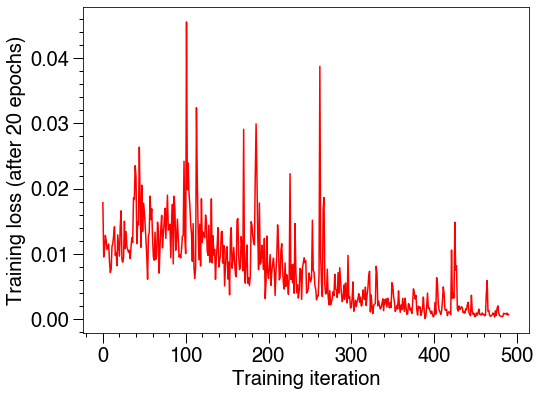

In [39]:
# Save data
# with open('./Data/CS1_score_g2_1400_ep', 'wb') as f:
#     pickle.dump(score_list, f, pickle.HIGHEST_PROTOCOL)
# with open('./Data/CS1_loss_g2_1400_ep', 'wb') as f:
#     pickle.dump(training_loss_list, f, pickle.HIGHEST_PROTOCOL)

# Load pre-run data
# with open('./Data/CS1_score_g2_1400_ep', 'rb') as f:
#     score_list = pickle.load(f)
# with open('./Data/CS1_loss_g2_1400_ep', 'rb') as f:
#     training_loss_list = pickle.load(f)

# Plot score vs. training iteration
fig, ax = plt.subplots(figsize=(8,6))
ax.minorticks_on()
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(which='major', length=10, width=1, direction='out')
ax.tick_params(which='minor', length=4, width=1, direction='out')
plt.plot(iteration_list, score_list, color = 'b')
plt.legend(frameon =  0)
plt.ylabel('Average score of policy', fontsize = 20)
plt.xlabel('Training iteration', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

# Plot training loss vs. training iteration
fig, ax = plt.subplots(figsize=(8,6))
ax.minorticks_on()
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(which='major', length=10, width=1, direction='out')
ax.tick_params(which='minor', length=4, width=1, direction='out')
plt.plot(iteration_list, training_loss_list, color = 'r')
plt.legend(frameon =  0)
plt.ylabel('Training loss (after 20 epochs)', fontsize = 20)
plt.xlabel('Training iteration', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [1017]:
# Generate g1_threshold
g1_threshold_list = []
g1_threshold = 500
g2_threshold_list = []
g2_threshold = 0.05
for i in range(2000):
    g1_threshold_list += [g1_threshold]
    g1_threshold *= 0.995
    g2_threshold_list += [g2_threshold]
    g2_threshold *= 0.995

In [986]:
g2_threshold_list

[0.05,
 0.04975,
 0.049501250000000004,
 0.04925374375,
 0.049007475031250004,
 0.048762437656093754,
 0.048518625467813284,
 0.048276032340474215,
 0.04803465217877184,
 0.04779447891787798,
 0.04755550652328859,
 0.047317728990672145,
 0.04708114034571878,
 0.04684573464399019,
 0.04661150597077024,
 0.04637844844091639,
 0.04614655619871181,
 0.04591582341771825,
 0.04568624430062966,
 0.04545781307912651,
 0.04523052401373088,
 0.04500437139366222,
 0.04477934953669391,
 0.044555452789010436,
 0.04433267552506538,
 0.04411101214744006,
 0.04389045708670286,
 0.04367100480126935,
 0.043452649777263,
 0.04323538652837668,
 0.0430192095957348,
 0.04280411354775612,
 0.04259009298001734,
 0.042377142515117254,
 0.04216525680254167,
 0.041954430518528964,
 0.04174465836593632,
 0.04153593507410664,
 0.04132825539873611,
 0.04112161412174243,
 0.04091600605113372,
 0.04071142602087805,
 0.04050786889077366,
 0.04030532954631979,
 0.04010380289858819,
 0.03990328388409525,
 0.039703767464

## Plot MC episodes and explore state space

In [245]:
# Generate data using random policy
plotting_state_data = []
for i in range(10):
    episode = generate_episode_with_NN(GA_optimize_constrained, [1.0, 150.0, 0, 0], epsilon = 0, 
                                   g1_threshold = 0,
                                   g2_threshold = 0) # Generate 1 episode
    data = extract_data_from_episode(episode, discount_factor = 0.9)   # Extract datapoint from episode
    for j in data:
        j = j[:-1]
        plotting_state_data += j  # Add datapoints to training set
# plotting_state_data
plotting_state_data = pd.DataFrame(plotting_state_data)
plotting_state_data_g1_violated = plotting_state_data[plotting_state_data[1] - 800 > 0] # Conpath 1
plotting_state_data_g2_violated = plotting_state_data[plotting_state_data[2] - 0.011*plotting_state_data[0] > 0] # Conpath 2
plotting_state_data_g3_violated = plotting_state_data[(plotting_state_data[3] == 240.0) & (plotting_state_data[1] - 150 > 0)] # Terminal constraint

print('No. of states visited:',len(plotting_state_data))
print('No. of states where g1 violated:',len(plotting_state_data_g1_violated))
print('No. of states where g2 violated:',len(plotting_state_data_g2_violated))
print('No. of states where g3 violated:',len(plotting_state_data_g3_violated))

Cx_all = plotting_state_data[0]
Cn_all = plotting_state_data[1]
Cq_all = plotting_state_data[2]
Cx_g1 = plotting_state_data_g1_violated[0]
Cn_g1 = plotting_state_data_g1_violated[1]
Cq_g1 = plotting_state_data_g1_violated[2]
Cx_g2 = plotting_state_data_g2_violated[0]
Cn_g2 = plotting_state_data_g2_violated[1]
Cq_g2 = plotting_state_data_g2_violated[2]
Cx_g3 = plotting_state_data_g3_violated[0]
Cn_g3 = plotting_state_data_g3_violated[1]
Cq_g3 = plotting_state_data_g3_violated[2]

@interact(ns=(-90,90,0.1),ew=(-90,90,0.1))
def interact_poly(ns,ew):
    fig = plt.figure(figsize = (10,7))
    ax = plt.axes(projection='3d')

    # Data for a three-dimensional line
    ax.plot3D(Cx_all, Cn_all, Cq_all, 'g', label = 'no violation', linestyle = '', marker = 'o', markersize = 1)
    ax.plot3D(Cx_g1, Cn_g1, Cq_g1, 'r', label = 'g1', linestyle = '', marker = 'o', markersize = 1)
    ax.plot3D(Cx_g2, Cn_g2, Cq_g2, 'b', label = 'g2', linestyle = '', marker = 'o', markersize = 1)
    ax.plot3D(Cx_g3, Cn_g3, Cq_g3, 'black', label = 'g3', linestyle = '', marker = 'o', markersize = 1)
    plt.xlabel('$C_x$', labelpad=30)
    plt.ylabel('$C_n$', labelpad=50)
    ax.set_zlabel('$C_q$', fontsize=20, labelpad=20)
    plt.legend()
    plt.xticks(rotation=90)
    plt.yticks(rotation=90)
    plt.xlim(0,16)
    plt.ylim(0,2200)
    ax.set_zlim(0, 0.25)
    ax.view_init(ns,ew)
    plt.show()

No. of states visited: 130
No. of states where g1 violated: 31
No. of states where g2 violated: 10
No. of states where g3 violated: 0


interactive(children=(FloatSlider(value=0.0, description='ns', max=90.0, min=-90.0), FloatSlider(value=0.0, de…

## Plot evolution of state space into gif

No. of states visited: 130
No. of states where g1 violated: 68
No. of states where g2 violated: 0
No. of states where g3 violated: 0


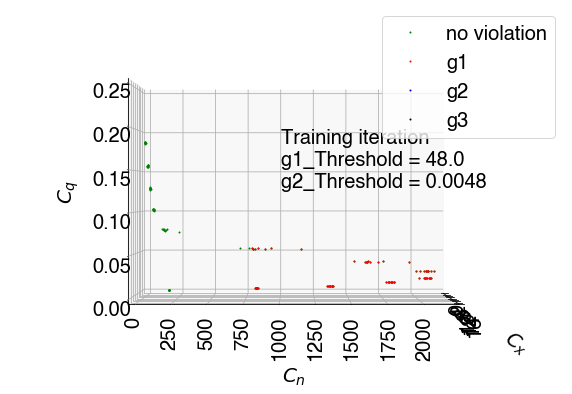

No. of states visited: 130
No. of states where g1 violated: 40
No. of states where g2 violated: 10
No. of states where g3 violated: 0


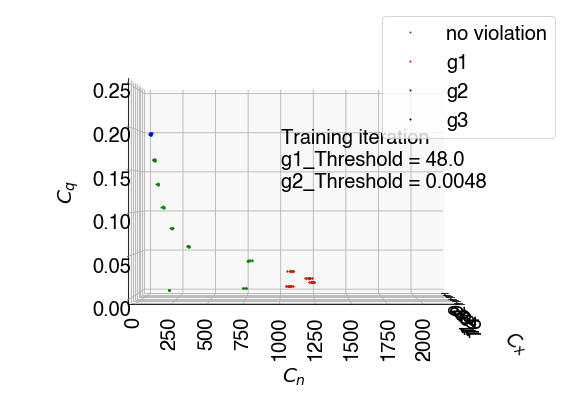

No. of states visited: 130
No. of states where g1 violated: 40
No. of states where g2 violated: 10
No. of states where g3 violated: 0


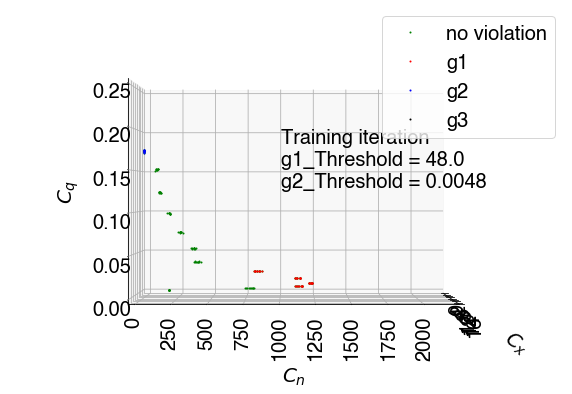

No. of states visited: 130
No. of states where g1 violated: 41
No. of states where g2 violated: 0
No. of states where g3 violated: 0


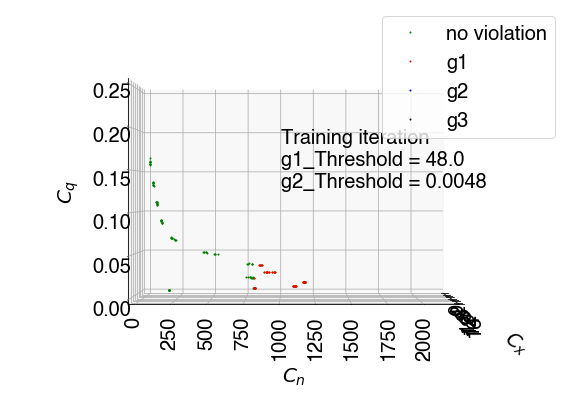

No. of states visited: 130
No. of states where g1 violated: 53
No. of states where g2 violated: 10
No. of states where g3 violated: 0


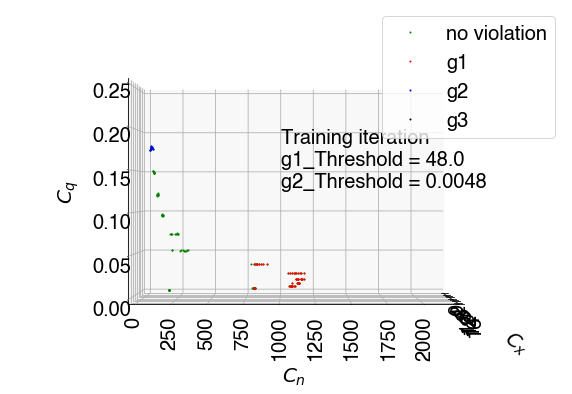

No. of states visited: 130
No. of states where g1 violated: 50
No. of states where g2 violated: 10
No. of states where g3 violated: 0


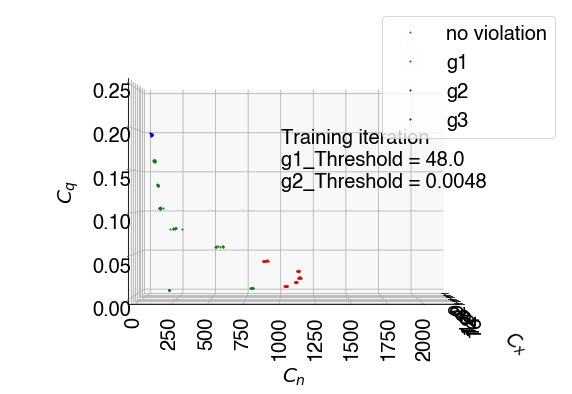

No. of states visited: 130
No. of states where g1 violated: 17
No. of states where g2 violated: 9
No. of states where g3 violated: 6


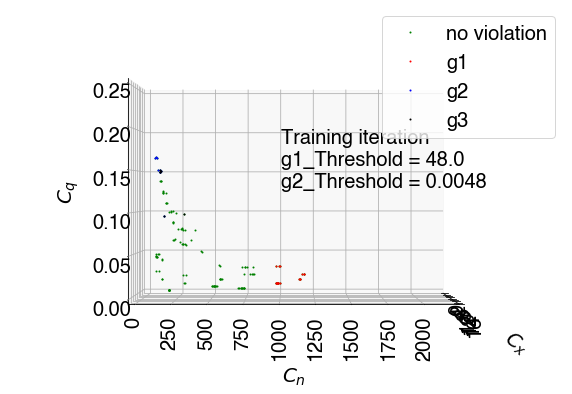

No. of states visited: 130
No. of states where g1 violated: 50
No. of states where g2 violated: 10
No. of states where g3 violated: 0


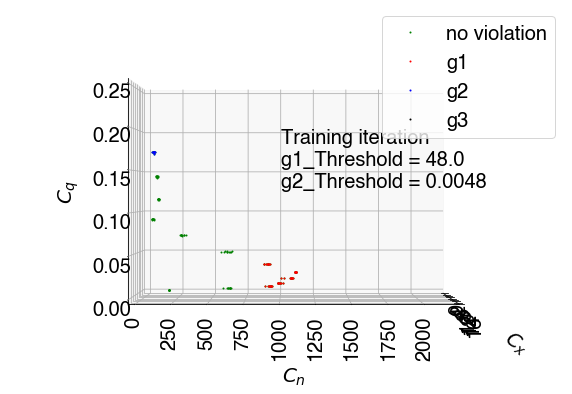

No. of states visited: 130
No. of states where g1 violated: 46
No. of states where g2 violated: 10
No. of states where g3 violated: 0


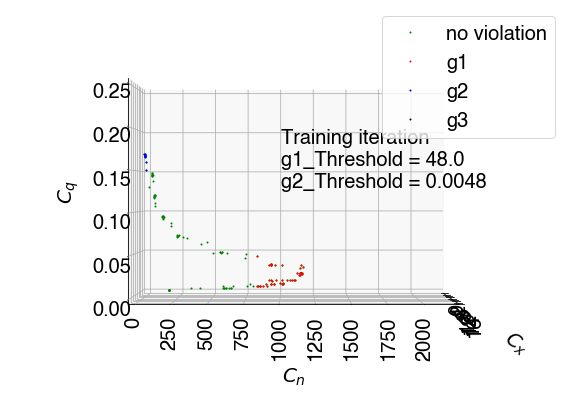

No. of states visited: 130
No. of states where g1 violated: 50
No. of states where g2 violated: 10
No. of states where g3 violated: 0


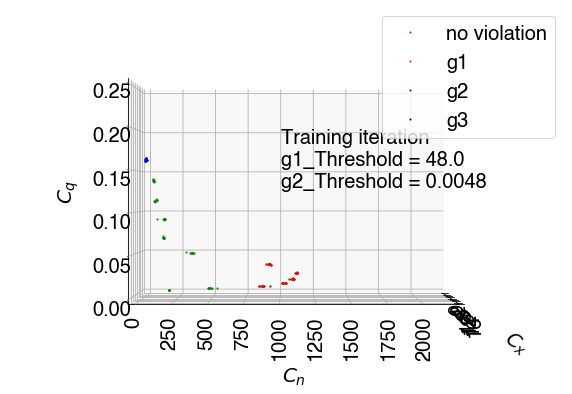

No. of states visited: 130
No. of states where g1 violated: 40
No. of states where g2 violated: 10
No. of states where g3 violated: 0


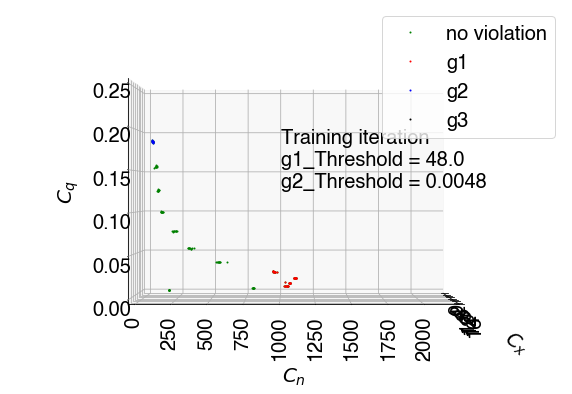

No. of states visited: 130
No. of states where g1 violated: 0
No. of states where g2 violated: 0
No. of states where g3 violated: 0


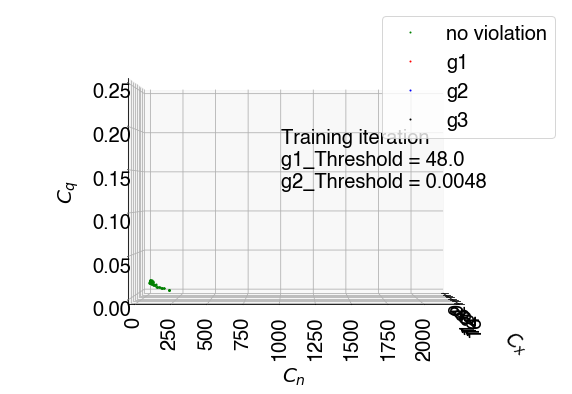

No. of states visited: 130
No. of states where g1 violated: 40
No. of states where g2 violated: 10
No. of states where g3 violated: 0


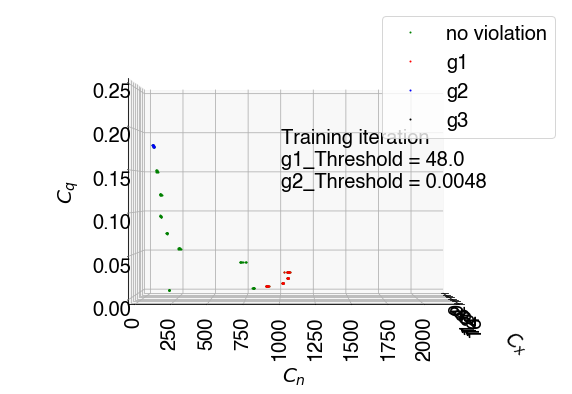

No. of states visited: 130
No. of states where g1 violated: 49
No. of states where g2 violated: 10
No. of states where g3 violated: 0


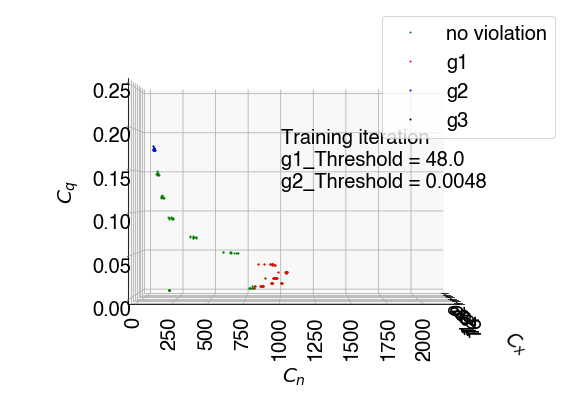

No. of states visited: 130
No. of states where g1 violated: 30
No. of states where g2 violated: 10
No. of states where g3 violated: 0


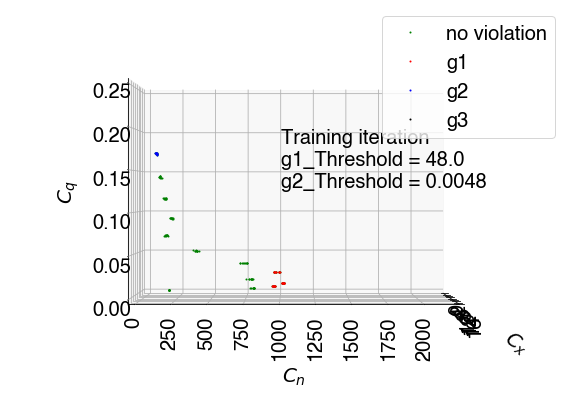

No. of states visited: 130
No. of states where g1 violated: 51
No. of states where g2 violated: 10
No. of states where g3 violated: 0


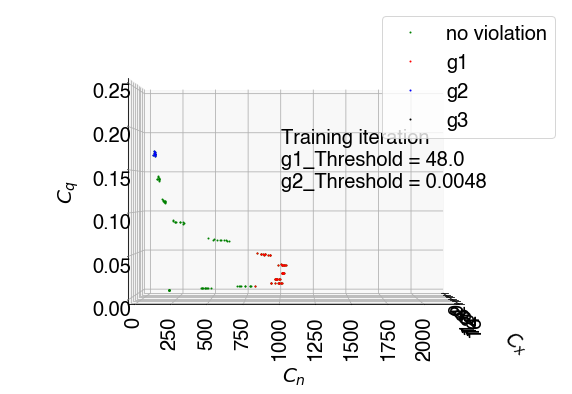

No. of states visited: 130
No. of states where g1 violated: 50
No. of states where g2 violated: 1
No. of states where g3 violated: 0


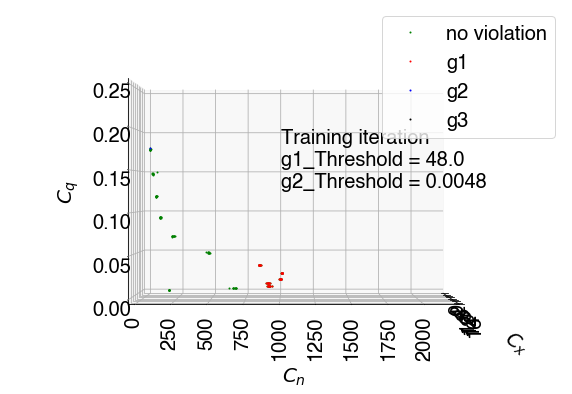

No. of states visited: 130
No. of states where g1 violated: 44
No. of states where g2 violated: 10
No. of states where g3 violated: 0


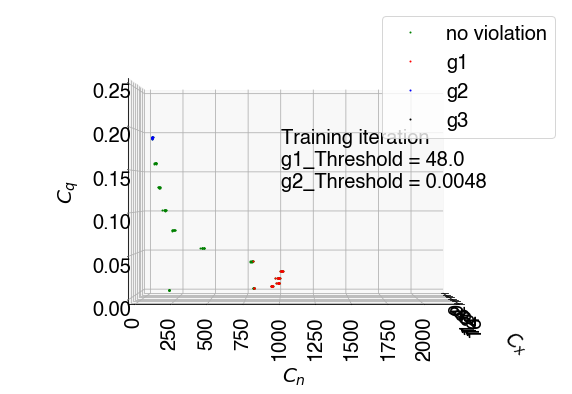

No. of states visited: 130
No. of states where g1 violated: 50
No. of states where g2 violated: 5
No. of states where g3 violated: 0


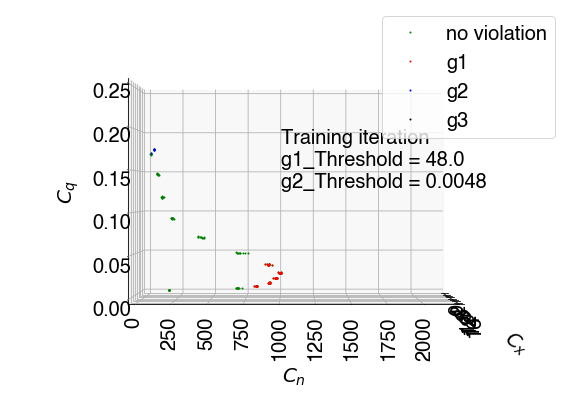

No. of states visited: 130
No. of states where g1 violated: 30
No. of states where g2 violated: 10
No. of states where g3 violated: 0


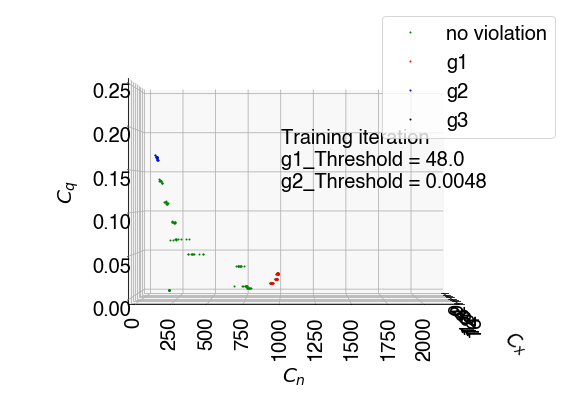

No. of states visited: 130
No. of states where g1 violated: 30
No. of states where g2 violated: 3
No. of states where g3 violated: 0


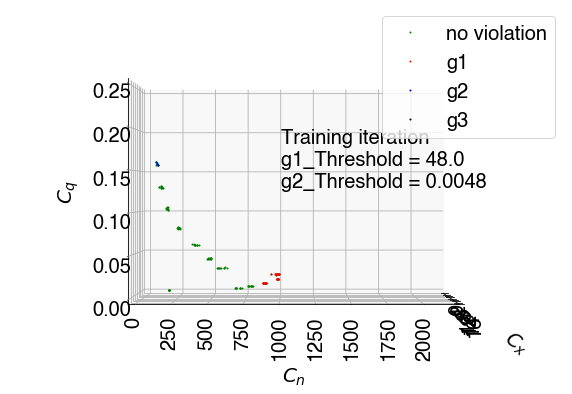

No. of states visited: 130
No. of states where g1 violated: 40
No. of states where g2 violated: 10
No. of states where g3 violated: 0


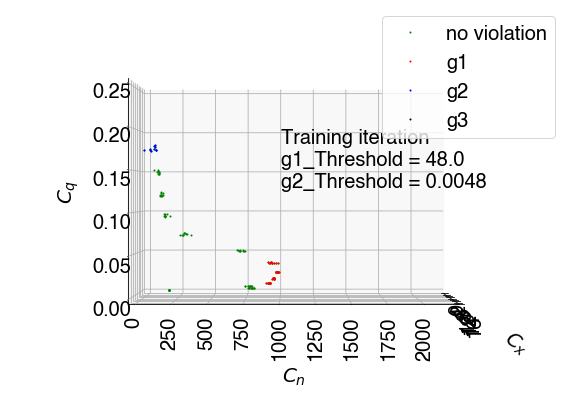

No. of states visited: 130
No. of states where g1 violated: 30
No. of states where g2 violated: 10
No. of states where g3 violated: 7


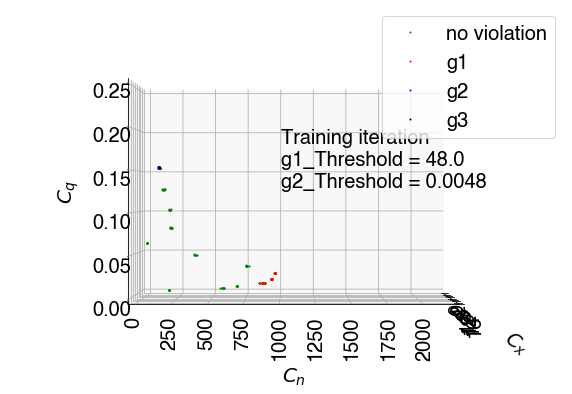

No. of states visited: 130
No. of states where g1 violated: 40
No. of states where g2 violated: 0
No. of states where g3 violated: 0


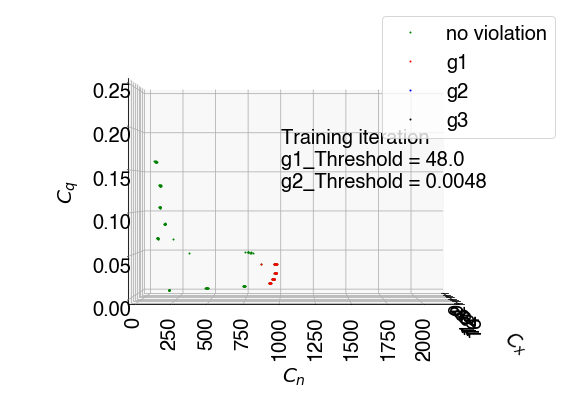

No. of states visited: 130
No. of states where g1 violated: 42
No. of states where g2 violated: 0
No. of states where g3 violated: 0


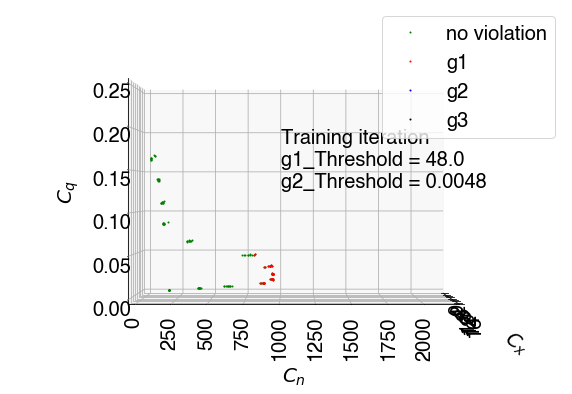

No. of states visited: 130
No. of states where g1 violated: 40
No. of states where g2 violated: 10
No. of states where g3 violated: 0


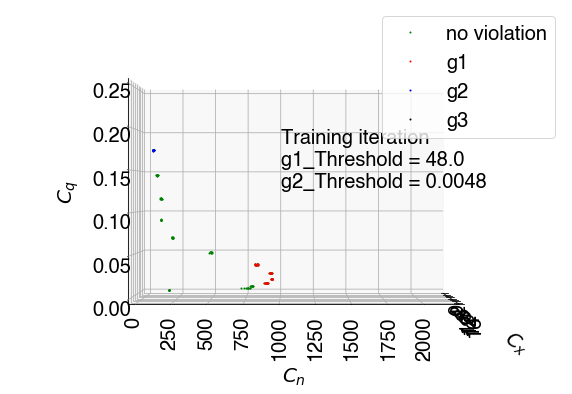

No. of states visited: 130
No. of states where g1 violated: 32
No. of states where g2 violated: 10
No. of states where g3 violated: 0


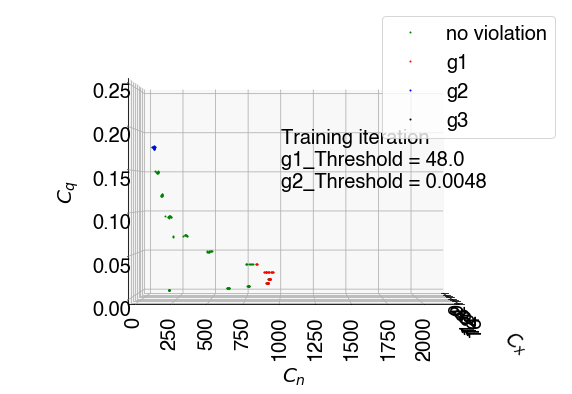

No. of states visited: 130
No. of states where g1 violated: 43
No. of states where g2 violated: 10
No. of states where g3 violated: 0


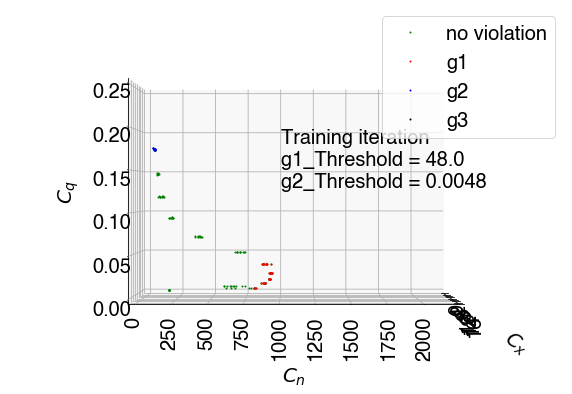

No. of states visited: 130
No. of states where g1 violated: 38
No. of states where g2 violated: 0
No. of states where g3 violated: 0


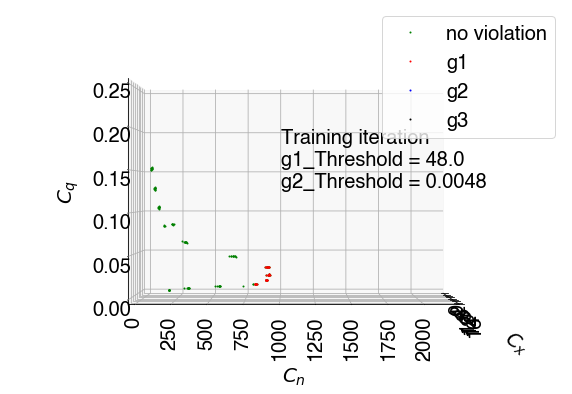

No. of states visited: 130
No. of states where g1 violated: 24
No. of states where g2 violated: 10
No. of states where g3 violated: 0


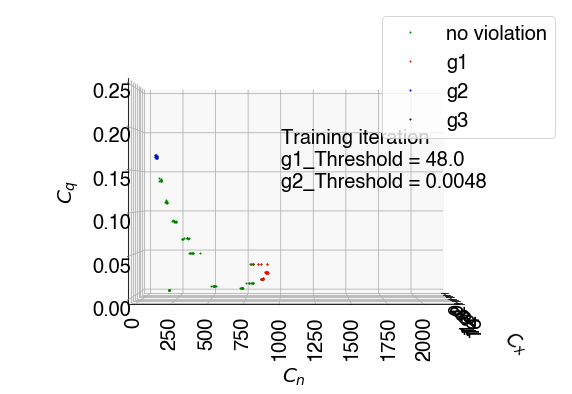

No. of states visited: 130
No. of states where g1 violated: 32
No. of states where g2 violated: 10
No. of states where g3 violated: 0


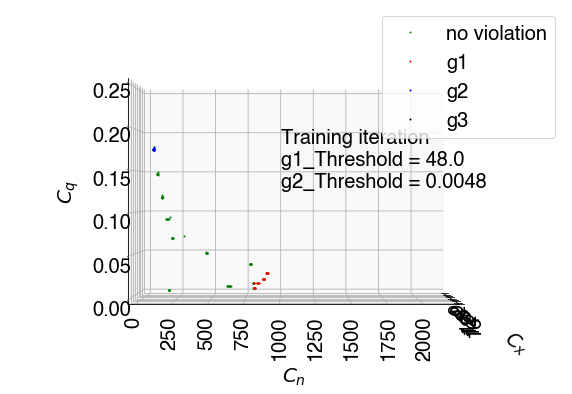

No. of states visited: 130
No. of states where g1 violated: 24
No. of states where g2 violated: 0
No. of states where g3 violated: 0


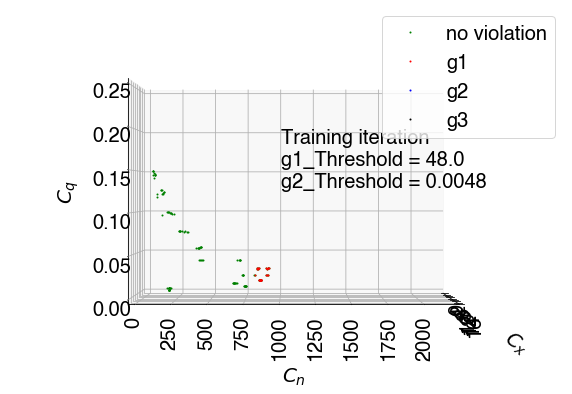

No. of states visited: 130
No. of states where g1 violated: 33
No. of states where g2 violated: 10
No. of states where g3 violated: 0


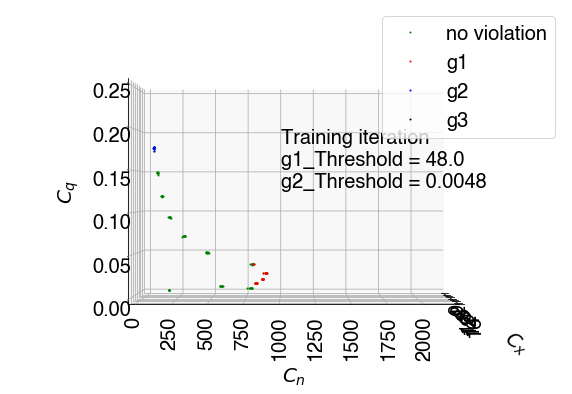

No. of states visited: 130
No. of states where g1 violated: 22
No. of states where g2 violated: 10
No. of states where g3 violated: 0


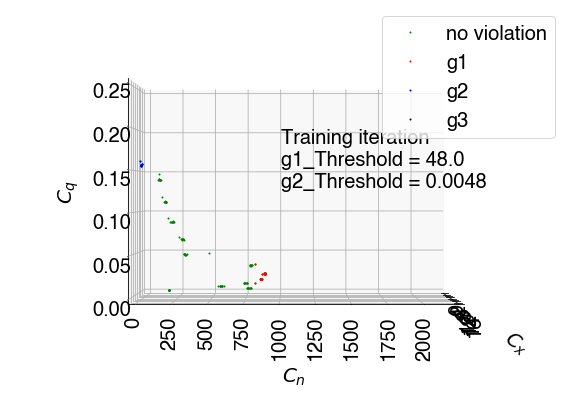

No. of states visited: 130
No. of states where g1 violated: 22
No. of states where g2 violated: 10
No. of states where g3 violated: 0


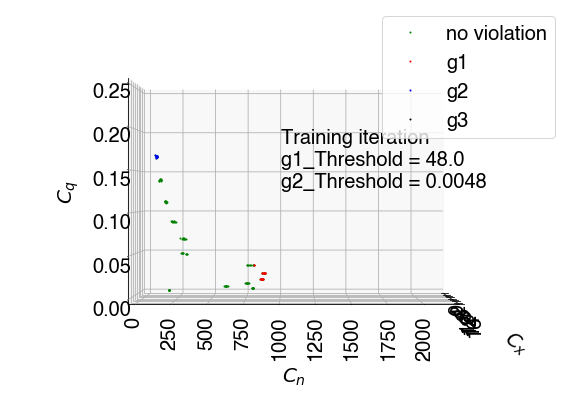

No. of states visited: 130
No. of states where g1 violated: 17
No. of states where g2 violated: 0
No. of states where g3 violated: 0


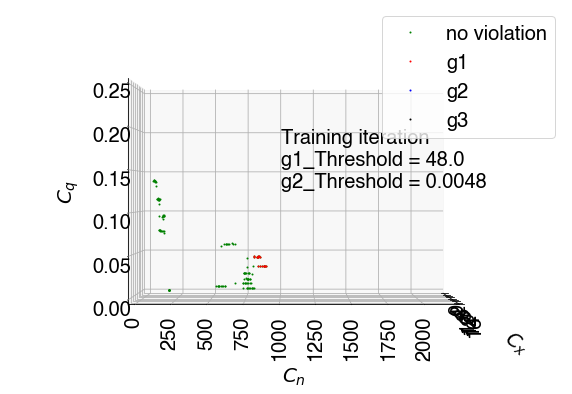

No. of states visited: 130
No. of states where g1 violated: 10
No. of states where g2 violated: 0
No. of states where g3 violated: 0


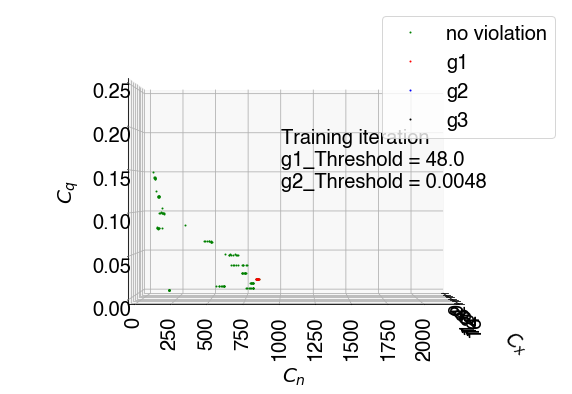

No. of states visited: 130
No. of states where g1 violated: 23
No. of states where g2 violated: 2
No. of states where g3 violated: 0


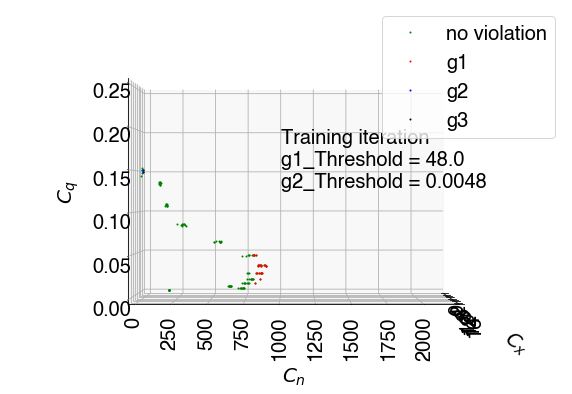

No. of states visited: 130
No. of states where g1 violated: 30
No. of states where g2 violated: 10
No. of states where g3 violated: 0


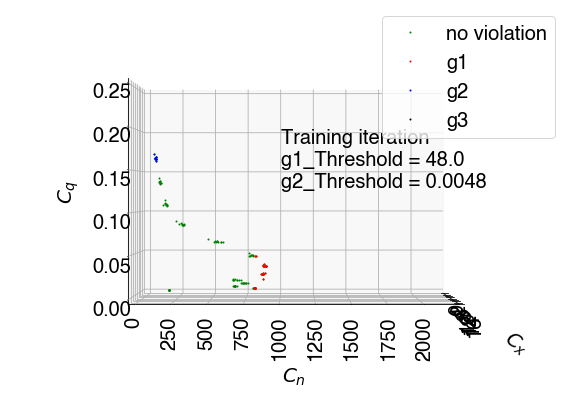

No. of states visited: 130
No. of states where g1 violated: 39
No. of states where g2 violated: 8
No. of states where g3 violated: 0


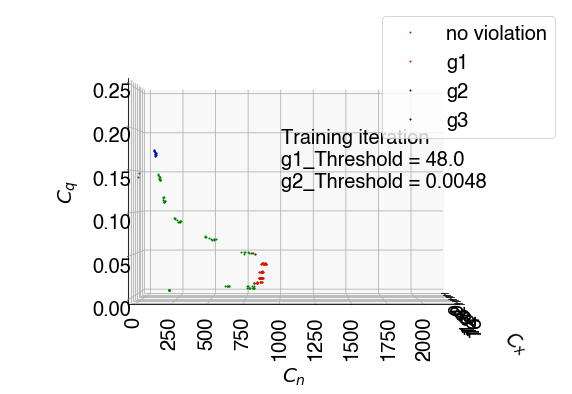

No. of states visited: 130
No. of states where g1 violated: 0
No. of states where g2 violated: 10
No. of states where g3 violated: 3


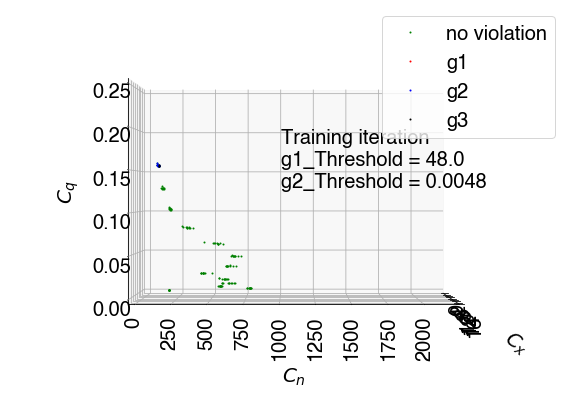

No. of states visited: 130
No. of states where g1 violated: 19
No. of states where g2 violated: 9
No. of states where g3 violated: 0


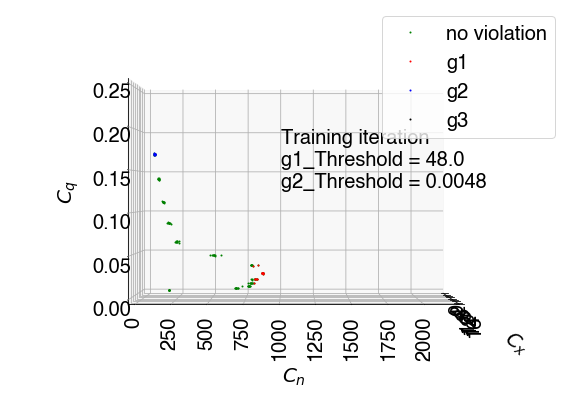

No. of states visited: 130
No. of states where g1 violated: 29
No. of states where g2 violated: 0
No. of states where g3 violated: 0


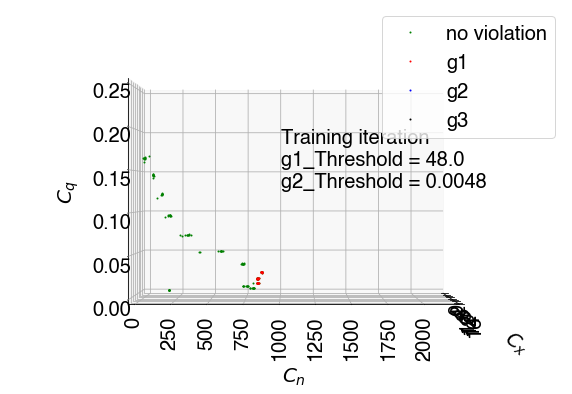

No. of states visited: 130
No. of states where g1 violated: 36
No. of states where g2 violated: 9
No. of states where g3 violated: 0


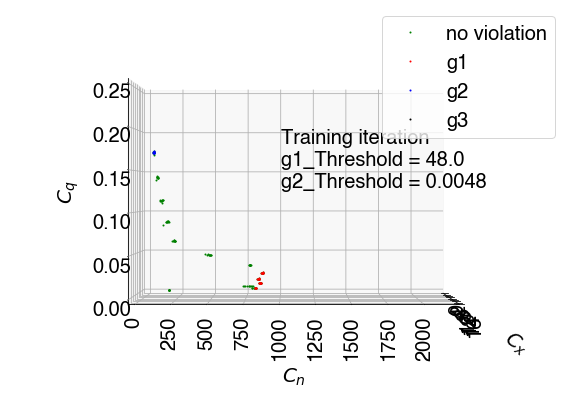

No. of states visited: 130
No. of states where g1 violated: 34
No. of states where g2 violated: 10
No. of states where g3 violated: 0


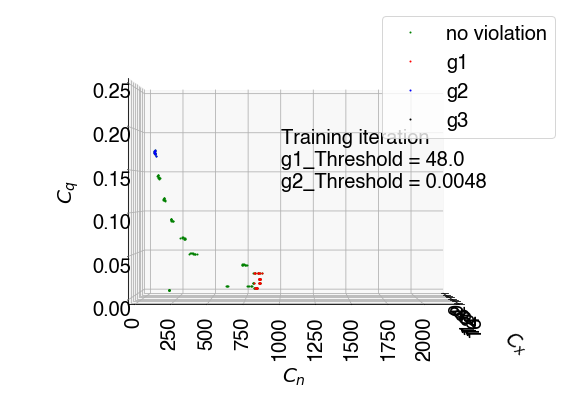

No. of states visited: 130
No. of states where g1 violated: 21
No. of states where g2 violated: 10
No. of states where g3 violated: 0


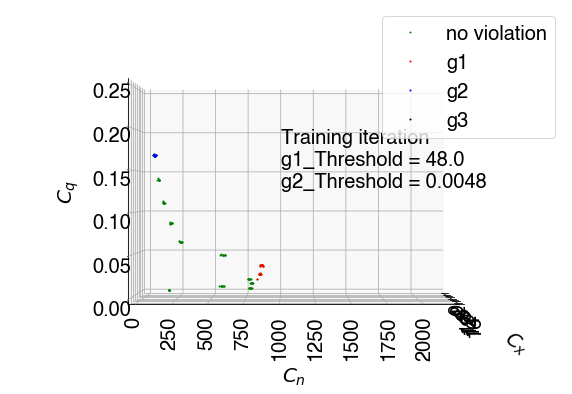

No. of states visited: 130
No. of states where g1 violated: 28
No. of states where g2 violated: 10
No. of states where g3 violated: 0


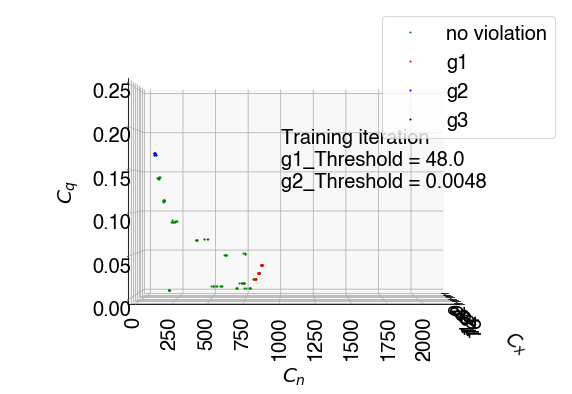

No. of states visited: 130
No. of states where g1 violated: 20
No. of states where g2 violated: 10
No. of states where g3 violated: 0


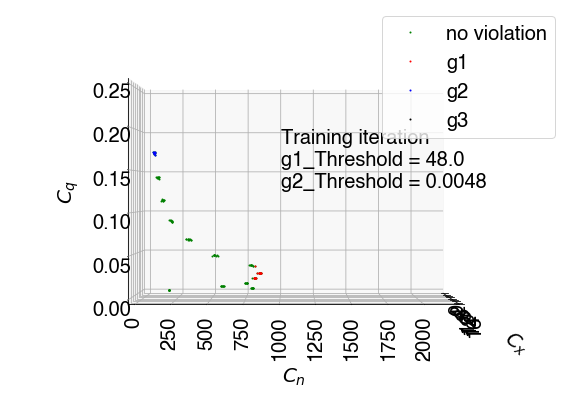

No. of states visited: 130
No. of states where g1 violated: 22
No. of states where g2 violated: 9
No. of states where g3 violated: 1


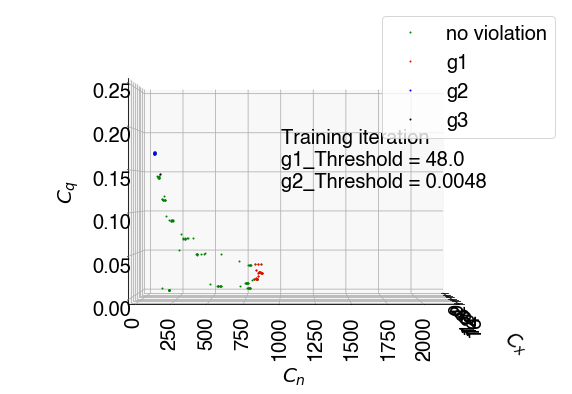

No. of states visited: 130
No. of states where g1 violated: 20
No. of states where g2 violated: 8
No. of states where g3 violated: 0


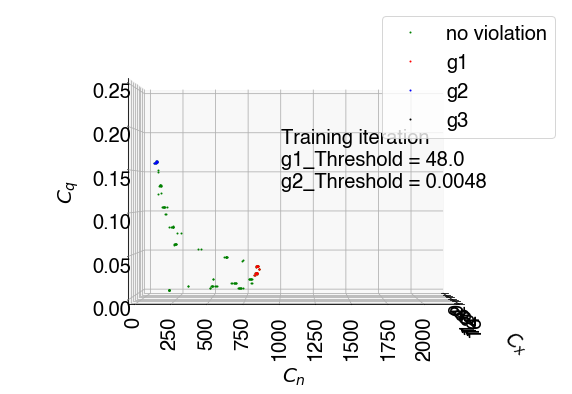

No. of states visited: 130
No. of states where g1 violated: 20
No. of states where g2 violated: 8
No. of states where g3 violated: 0


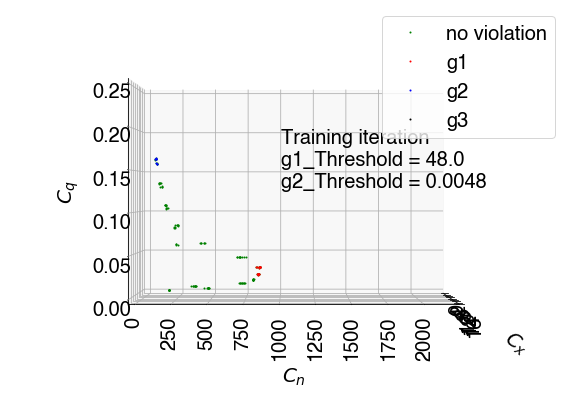

No. of states visited: 130
No. of states where g1 violated: 20
No. of states where g2 violated: 0
No. of states where g3 violated: 7


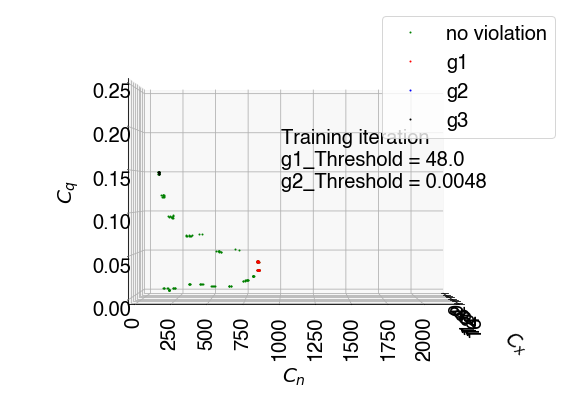

In [224]:
# Plot episode bank
my_images = []  # For saving into gif

for i in range(len(episode_bank)): # i is the index for iteration
    plotting_state_data = []
    
    for j in range(len(episode_bank[i])): # j is the index for different episodes
        episode = episode_bank[i][j]

        data = extract_data_from_episode(episode, discount_factor = 0.9)   # Extract datapoint from episode
        for z in data:
            z = z[:-1]
            plotting_state_data += z  # Add datapoints to training set
    iteration = iteration_list[::10][i] # Record training iteration
    g1_threshold = g1_threshold_list[::10][i] # Record g1_threshold
    g2_threshold = g2_threshold_list[::10][i] # Record g1_threshold
    # plotting_state_data
    plotting_state_data = pd.DataFrame(plotting_state_data)
    plotting_state_data_g1_violated = plotting_state_data[plotting_state_data[1] - 800 > 0] # Conpath 1
    plotting_state_data_g2_violated = plotting_state_data[plotting_state_data[2] - 0.011*plotting_state_data[0] > 0] # Conpath 2
    plotting_state_data_g3_violated = plotting_state_data[(plotting_state_data[3] == 240.0) & (plotting_state_data[1] - 150 > 0)] # Terminal constraint

    print('No. of states visited:',len(plotting_state_data))
    print('No. of states where g1 violated:',len(plotting_state_data_g1_violated))
    print('No. of states where g2 violated:',len(plotting_state_data_g2_violated))
    print('No. of states where g3 violated:',len(plotting_state_data_g3_violated))

    Cx_all = plotting_state_data[0]
    Cn_all = plotting_state_data[1]
    Cq_all = plotting_state_data[2]

    Cx_g1 = plotting_state_data_g1_violated[0]
    Cn_g1 = plotting_state_data_g1_violated[1]
    Cq_g1 = plotting_state_data_g1_violated[2]

    Cx_g2 = plotting_state_data_g2_violated[0]
    Cn_g2 = plotting_state_data_g2_violated[1]
    Cq_g2 = plotting_state_data_g2_violated[2]

    Cx_g3 = plotting_state_data_g3_violated[0]
    Cn_g3 = plotting_state_data_g3_violated[1]
    Cq_g3 = plotting_state_data_g3_violated[2]

    
    fig = plt.figure(figsize = (10,7))
    ax = plt.axes(projection='3d')

    # Data for a three-dimensional line
    ax.plot3D(Cx_all, Cn_all, Cq_all, 'g', label = 'no violation', linestyle = '', marker = 'o', markersize = 1)
    ax.plot3D(Cx_g1, Cn_g1, Cq_g1, 'r', label = 'g1', linestyle = '', marker = 'o', markersize = 1)
    ax.plot3D(Cx_g2, Cn_g2, Cq_g2, 'b', label = 'g2', linestyle = '', marker = 'o', markersize = 1)
    ax.plot3D(Cx_g3, Cn_g3, Cq_g3, 'black', label = 'g3', linestyle = '', marker = 'o', markersize = 1)
    plt.xlabel('$C_x$', labelpad=30)
    plt.ylabel('$C_n$', labelpad=50)
    ax.set_zlabel('$C_q$', fontsize=20, labelpad=20)
    plt.legend()
    plt.xticks(rotation=90)
    plt.yticks(rotation=90)
    plt.xlim(0,16)
    plt.ylim(0,2200)
    ax.set_zlim(0, 0.25)
    plt.legend()
    ax.text(0,1000,0.13,'Training iteration {} \ng1_Threshold = {} \ng2_Threshold = {}'.format(iteration, round(g1_threshold,0), round(g2_threshold,4)),None)
    ax.view_init(0,0)
    plt.show()
        
    # Used to return the plot as an image array 
    # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    my_images.append(image)

# save images as a gif    
# imageio.mimsave('./Data/CS1_training_g2_500_ep.gif', my_images, fps=10)

## Plot trajectory

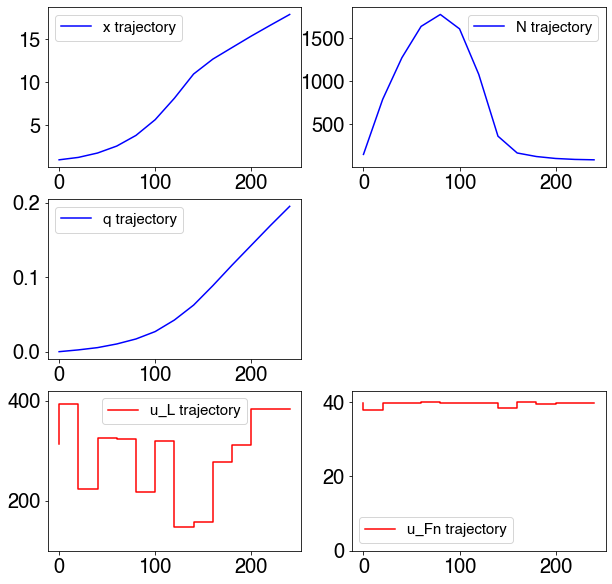

Score: 0.19522008698324972


In [1037]:
# Plot 1 episode
episode = generate_episode_with_NN(GA_optimize_constrained, [1.0, 150.0, 0, 0], epsilon = 0, 
                                   g1_threshold = 10000, g2_threshold = -0.001)
plot_episode(episode)

<ipython-input-999-6d703a435de3>:489: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3,2,1)
<ipython-input-999-6d703a435de3>:497: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3,2,2)
<ipython-input-999-6d703a435de3>:504: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created 

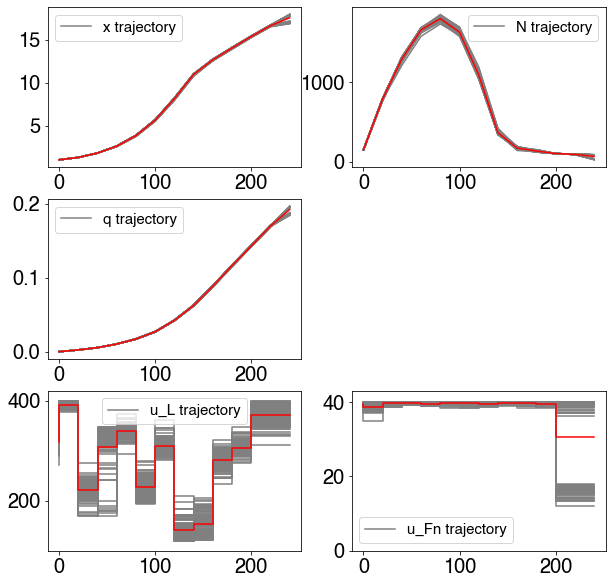

Score: 0.19575603479602127


In [1038]:
# Plot average of 100 episodes
episode_pool = []
for i in range(100):
    episode = generate_episode_with_NN(GA_optimize_constrained, [1.0, 150.0, 0, 0], epsilon = 0, 
                                   g1_threshold = 10000, g2_threshold = -0.001) 
    episode_pool += [episode]
    
plot_episode_pool(episode_pool)

## Distribution of g values

In [332]:
max_g1_list = []
for i in range(1000):
    episode = generate_episode_with_NN(GA_optimize_constrained, [1.0, 150.0, 0, 0], epsilon = 0, 
                                       g1_threshold = 0)
    # WORST violation of this episode
    max_g1 = max(extract_constraint_values_from_episode(episode, N_limit = 800, terminal_N_limit = 150)[1])[0]
    max_g1_list += [max_g1]

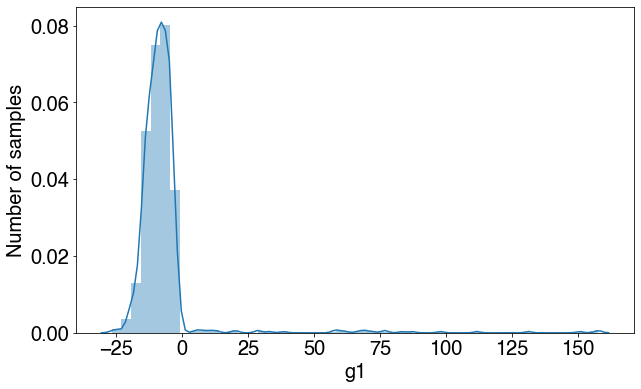

In [333]:
# Plot distribution of g1
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(max_g1_list)
ax.set(xlabel= 'g1', ylabel = 'Number of samples')
plt.show()